In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial
from collections import defaultdict
import random
#from purpleair.sensor import Sensor
#from purpleair.network import SensorList
import pickle
from datetime import datetime, timedelta

import os
import sys
from datetime import datetime
from os.path import expanduser
import urllib
import json

In [2]:
API_KEY = "96602008-3701-466F-982E-7F022DFDBBAD"

## Set the longitude/latitude coordinates of the sensor area
min_lon = -123.948
max_lon = -119.246
min_lat = 35.853
max_lat = 39.724
BBox = ((min_lon, max_lon,      
        min_lat, max_lat))

## Set dates and times over collected data:
start_date = "2021-02-09"
start_hour = "0"
end_date = "2021-02-13"
end_hour = "23"

# start_date = "2021-05-01"
# start_hour = "0"
# end_date = "2021-05-03"
# end_hour = "23"

year = int(end_date[0:4])
month = int(end_date[5:7])
day = int(end_date[8:])

## Map image - insert the correct path on your device
sf_map_img = plt.imread('central_CA_map.png')

In [3]:
# API parameters
options = {}
options["url"] = "https://airnowapi.org/aq/data/"
options["start_date"] = start_date
options["start_hour_utc"] = start_hour
options["end_date"] = end_date
options["end_hour_utc"] = end_hour
options["parameters"] = "pm25"
options["bbox"] = str(min_lon) + "," + str(min_lat) + "," + str(max_lon) + "," + str(max_lat)
options["data_type"] = "a"
options["format"] = "json"
options["ext"] = "json"
options["api_key"] = API_KEY

# API request URL
REQUEST_URL = options["url"] \
              + "?startdate=" + options["start_date"] \
              + "t" + options["start_hour_utc"] \
              + "&enddate=" + options["end_date"] \
              + "t" + options["end_hour_utc"] \
              + "&parameters=" + options["parameters"] \
              + "&bbox=" + options["bbox"] \
              + "&datatype=" + options["data_type"] \
              + "&format=" + options["format"] \
              + "&api_key=" + options["api_key"]

try:
    # Request AirNowAPI data
    print("Requesting AirNowAPI data...")

    # User's home directory.
    home_dir = expanduser("~")
    download_file_name = "AirNowAPI" + datetime.now().strftime("_%Y%M%d%H%M%S." + options["ext"])
    download_file = os.path.join(home_dir, download_file_name)

    # Perform the AirNow API data request
#     api_data = urllib.URLopener()
#     api_data = urllib.request.urlopen(REQUEST_URL)
#     api_data.retrieve(REQUEST_URL, download_file)

    response = urllib.request.urlopen(REQUEST_URL)

    data = json.loads(response.read())

#     data = api_data.read()

    # Download complete
    print("Download URL: %s" % REQUEST_URL)
    print("Download File: %s" % download_file)

except Exception as e:
    print("Unable perform AirNowAPI request. %s" % e)
    sys.exit(1)

Requesting AirNowAPI data...
Download URL: https://airnowapi.org/aq/data/?startdate=2021-02-09t0&enddate=2021-02-13t23&parameters=pm25&bbox=-123.948,35.853,-119.246,39.724&datatype=a&format=json&api_key=96602008-3701-466F-982E-7F022DFDBBAD
Download File: /home/javier/AirNowAPI_20231621121636.json


In [4]:
### Filter for unique long/lat coordinates
data_lat = []
data_lon = []
for sensor in data:
    data_lat.append(sensor['Latitude'])
    data_lon.append(sensor['Longitude'])
    
airnow_sensors = []
for item in zip(data_lon,data_lat):
    if(item not in airnow_sensors):
        airnow_sensors.append(item)

d = len(airnow_sensors)
print("Number of AirNow Sensors: " + str(d))

airnow_lon = []
airnow_lat = []
for sensor in airnow_sensors:
    airnow_lon.append(sensor[0])
    airnow_lat.append(sensor[1])

Number of AirNow Sensors: 63


In [5]:
# with (open('/Users/kgilman/Desktop/aqi-dataset-experiments/bay_df_' + start_date + '-' + end_date + '.pkl', "rb")) as openfile:
#     while True:
#         try:
#             bay_df = pickle.load(openfile)
#         except EOFError:
#             break

In [6]:
import pandas as pd
bay_df = pd.read_pickle(r'bay_df.pkl')

In [7]:
### Sort PurpleAir into Voronoi cells by AirNow sensor location
airnow_purple_dict = defaultdict(list)
for bay_index,pt in enumerate(zip(bay_df.lon.tolist(),bay_df.lat.tolist())):
    index = spatial.KDTree(airnow_sensors).query(pt)[1]
    airnow_key = airnow_sensors[index]
    airnow_purple_dict[airnow_key].append(bay_index)
    
### Remove AirNow sensors with fewer than min_num_purple # of nearby PurpleAir sensors 
min_num_purple = 10
removed = []
for (idx,sensor) in enumerate(airnow_sensors):
    if(len(airnow_purple_dict[sensor]) < min_num_purple):
        del airnow_purple_dict[sensor]
        removed.append(sensor)

for sensor in removed:
    airnow_sensors.remove(sensor)
    
airnow_lat = []
airnow_lon = []
for sensor in airnow_sensors:
    airnow_lat.append(sensor[1])
    airnow_lon.append(sensor[0])

In [8]:
# min_num_purple = min([len(airnow_purple_dict[key]) for key in airnow_purple_dict])
min_num_purple = 10;
nearestkpurple = {}
for key in airnow_purple_dict:
    nearestkpurple[key] = random.sample(airnow_purple_dict[key],min_num_purple) ##for random sensors in each Voronoi cell

#     purple_sensors_idx = airnow_purple_dict[key]
#     purple_sensors = []
#     for item in zip(bay_df.iloc[purple_sensors_idx].lon, bay_df.iloc[purple_sensors_idx].lat):
#         purple_sensors.append(item)

#     nearest_idx = spatial.KDTree(purple_sensors).query(key,k=min_num_purple)[1]
#     candidates = [airnow_purple_dict[key][i] for i in nearest_idx]
#     nearestkpurple_candidates[key] = candidates
    
# nearestkpurple = {}
# for key in nearestkpurple_candidates:
#     nearestkpurple[key] = nearestkpurple_candidates[key][:min_num_purple]

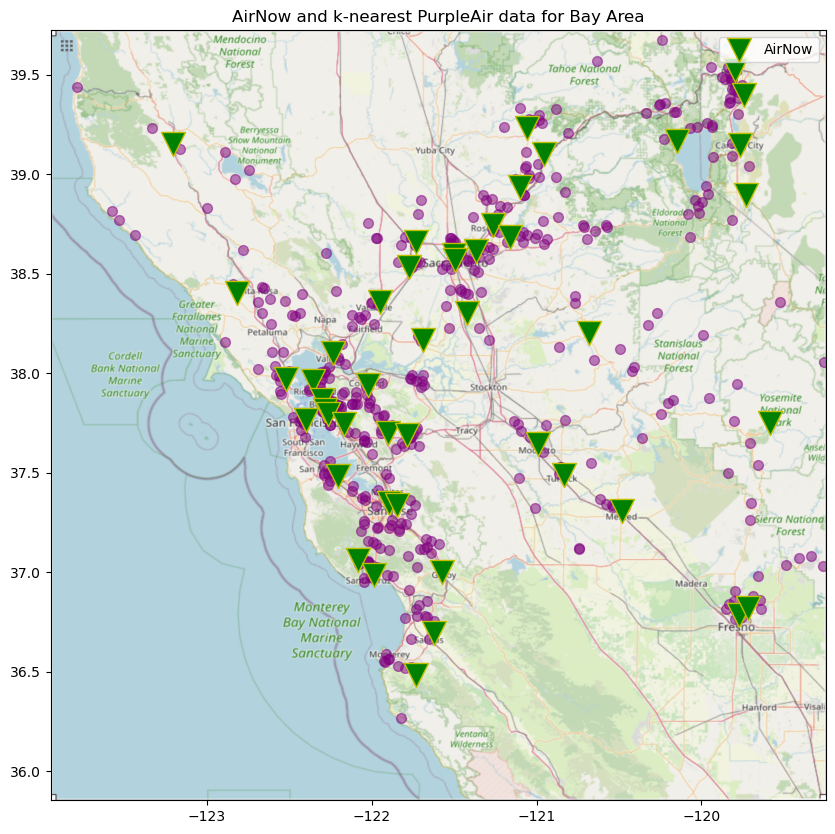

In [9]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(airnow_sensors)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(sf_map_img, zorder=0, extent = BBox, aspect= 'auto')
# voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',line_width=2, line_alpha=1, point_size=2,ax=ax)
# ax.scatter(bay_df.lon, bay_df.lat, zorder=1, alpha= 0.5, c='purple', s=20,label="PurpleAir")

for key in airnow_purple_dict:
    sensor_indices = nearestkpurple[key]
    ax.scatter(bay_df.iloc[sensor_indices].lon, bay_df.iloc[sensor_indices].lat, c='purple', zorder=1, alpha= 0.5, s=50,label="")

##Update these arrays again (find a way to do this without running this code again?)
airnow_lat = []
airnow_lon = []
for sensor in airnow_sensors:
    airnow_lat.append(sensor[1])
    airnow_lon.append(sensor[0])
    
ax.scatter(airnow_lon, airnow_lat, zorder=1, alpha= 1, c='g', s=300,marker="v",edgecolors='y',label="AirNow")
ax.set_title('AirNow and k-nearest PurpleAir data for Bay Area')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
plt.legend()
plt.show()

In [10]:
from pyairnow.conv import aqi_to_concentration, concentration_to_aqi

In [11]:
data

[{'Latitude': 39.150478,
  'Longitude': -123.206528,
  'UTC': '2021-02-09T00:00',
  'Parameter': 'PM2.5',
  'Unit': 'UG/M3',
  'AQI': 32,
  'Category': 1},
 {'Latitude': 38.403765,
  'Longitude': -122.818294,
  'UTC': '2021-02-09T00:00',
  'Parameter': 'PM2.5',
  'Unit': 'UG/M3',
  'AQI': 39,
  'Category': 1},
 {'Latitude': 37.9722,
  'Longitude': -122.5189,
  'UTC': '2021-02-09T00:00',
  'Parameter': 'PM2.5',
  'Unit': 'UG/M3',
  'AQI': 47,
  'Category': 1},
 {'Latitude': 37.7658,
  'Longitude': -122.3978,
  'UTC': '2021-02-09T00:00',
  'Parameter': 'PM2.5',
  'Unit': 'UG/M3',
  'AQI': 43,
  'Category': 1},
 {'Latitude': 37.9604,
  'Longitude': -122.3571,
  'UTC': '2021-02-09T00:00',
  'Parameter': 'PM2.5',
  'Unit': 'UG/M3',
  'AQI': 53,
  'Category': 2},
 {'Latitude': 37.864767,
  'Longitude': -122.302741,
  'UTC': '2021-02-09T00:00',
  'Parameter': 'PM2.5',
  'Unit': 'UG/M3',
  'AQI': 45,
  'Category': 1},
 {'Latitude': 37.8148,
  'Longitude': -122.282402,
  'UTC': '2021-02-09T00:0

In [12]:
time_record = defaultdict(list)      ## make dictionary of all time keys to keep time
airnow_data_dict = defaultdict(list) ## make dictionary hashed by (AirNow sensor coordinates x time) keys
for entry in data:
    airnow_key = (entry['Longitude'],entry['Latitude'])
    time_key = entry['UTC']
    if(time_key not in time_record):
        time_record[time_key]
    airnow_data_dict[(airnow_key,time_key)] = aqi_to_concentration(max(entry['AQI'],0),'PM2.5')

#### AirNow matrix

In [13]:
output_airnow_data = np.zeros((len(time_record),len(airnow_sensors))) ### memory allocate array
for (i,airnow_key) in enumerate(airnow_sensors):
    for t,time_key in enumerate(time_record):
        if(not airnow_data_dict[(airnow_key,time_key)]):
            output_airnow_data[t,i] = np.nan
        else:
            output_airnow_data[t,i] = airnow_data_dict[(airnow_key,time_key)]

In [14]:
output_airnow_data.shape

(120, 46)

In [15]:
### Eliminate any sensor columns with mostly missing entries (10% of entries are missing)
removed_idx = []
removed_sensors = []
for (i,sensor) in enumerate(airnow_sensors):
    if(sum(np.isnan(output_airnow_data[:,i])) > len(time_record)*0.1):
        removed_idx.append(i)
        removed_sensors.append(sensor)

        
output_airnow_data = np.delete(output_airnow_data, removed_idx, axis=1)

for sensor in removed_sensors:
    airnow_sensors.remove(sensor)


In [16]:
output_airnow_data.shape

(120, 40)

In [17]:
(rows, cols) = output_airnow_data.shape
airMatrix = np.zeros([rows,cols])
for i in range(rows):
    for j in range(cols):
        try:
            airMatrix[i,j] = aqi_to_concentration(output_airnow_data[i,j], 'PM2.5')
        except:
            airMatrix[i,j] = np.nan

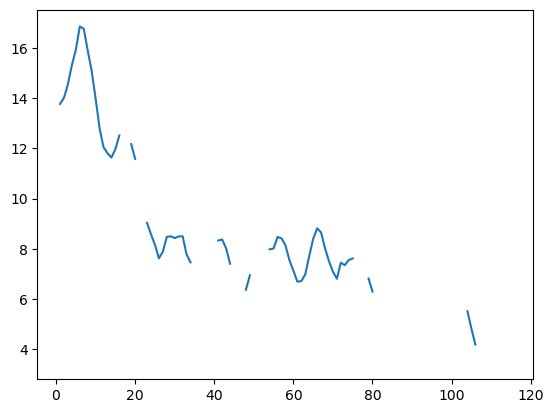

In [19]:
plt.plot(np.mean(output_airnow_data, axis=1))

In [18]:
np.save('airTest.npy', airMatrix)

In [25]:
### Find time indices of missing AirNow sensor readings
t_remove = ~np.isnan(output_airnow_data).any(axis=1)
output_airnow_data = output_airnow_data[t_remove,:]

In [26]:
output_airnow_data.shape

(67, 40)

In [37]:
t_remove

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False,  True, False,  True,  True,  True,  True,
       False, False, False,  True,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False])

In [27]:
len(airnow_sensors)

40

In [29]:
# num_purple = len(airnow_sensors)*1
# rand_purple_idx = random.sample(range(len(bay_df)),num_purple)

# sensor_names = bay_df.index.values[rand_purple_idx]

output_purple_air = []  
purple_sensor_ids = []
for (i,airnow_sensor) in enumerate(airnow_sensors):
    print('Sensor: ' + str(i))

    ## Get list of associated nearest k PurpleAir sensors
    sensor_names = bay_df.index.values[nearestkpurple[airnow_sensor]]

    for (j,name) in enumerate(sensor_names): 
        se = Sensor(int(name))
        se_df1 = se.parent.get_historical(weeks_to_get=1,thingspeak_field='primary',
                                        start_date = datetime(year,month,day+1))
#         se_df2 = se.child.get_historical(weeks_to_get=1,thingspeak_field='primary',
#                                         start_date = datetime(year,month,day+1))
        sensor_times1 = pd.to_datetime(se_df1['created_at'])
#         sensor_times2 = pd.to_datetime(se_df2['created_at'])
        
        ### Check for bad sensors
#         if((sensor_times1.empty) or (sensor_times2.empty)):
        if((sensor_times1.empty)):
            continue
            
        vals = se_df1['PM2.5_CF_ATM_ug/m3'].values
        if(np.sum(vals) == 0 or sum(np.isnan(vals))):
            continue
            
        if(np.sum(vals - vals[0]*np.ones(len(vals)))==0):
            continue
            
#         vals = se_df2['PM2.5_CF_ATM_ug/m3'].values
#         if(np.sum(vals) == 0 or sum(np.isnan(vals))):
#             continue
            
#         if(np.sum(vals - vals[1]*np.ones(len(vals)))==0):
#             continue
          
        vals = se_df1['Humidity_%'].values
        if(sum(np.isnan(vals))):
            continue
            

        ## For each hour of AirNow recording, get the PurpleAir sensor readings (nearest to that hour)
        purple_data = np.zeros((len(time_record),1))
        for (t,time_key) in enumerate(time_record):
            time_diff1 = abs(sensor_times1 - pd.to_datetime(time_key))
            tmp_idx1 = sensor_times1.index.get_loc(time_diff1.idxmin(0))
            reading1 = (se_df1.iloc[tmp_idx1]['PM2.5_CF_1_ug/m3'] )
            
#             time_diff2 = abs(sensor_times2 - pd.to_datetime(time_key))
#             tmp_idx2 = sensor_times2.index.get_loc(time_diff2.idxmin(0))
#             reading2 = (se_df2.iloc[tmp_idx2]['PM2.5_CF_1_ug/m3'] )
            
#             reading = 0.5*(reading1 + reading2)
            reading = reading1
            rh = se_df1.iloc[tmp_idx1]['Humidity_%']
        
            reading_convert = reading1
#             reading_convert = 0.534*reading -0.0844*rh + 5.604
#             reading_convert = 1/0.534*reading + 0.0844*rh
#             reading_convert = (reading + 0.0844*rh - 5.604)/0.534
        

            print("AirNow:" + str(i) + "; PurpleAir:" + str(j) + " at " + str(sensor_times1.iloc[tmp_idx1]) + ': ' + str(reading_convert) )
            ## Assign to corresponding AirNow/time entry
    #         purple_data[(airnow_sensor,time_key)].append(reading)
            purple_data[t] = reading_convert

        output_purple_air.append(purple_data)
        purple_sensor_ids.append(nearestkpurple[airnow_sensor][j])


Sensor: 0


NameError: name 'Sensor' is not defined

AirNow:0; PurpleAir:6 at 2021-02-08 23:59:11: 1.48
AirNow:0; PurpleAir:6 at 2021-02-09 00:59:11: 0.05
AirNow:0; PurpleAir:6 at 2021-02-09 01:59:11: 2.4
AirNow:0; PurpleAir:6 at 2021-02-09 02:59:11: 0.17
AirNow:0; PurpleAir:6 at 2021-02-09 03:59:11: 0.0
AirNow:0; PurpleAir:6 at 2021-02-09 04:59:11: 0.0
AirNow:0; PurpleAir:6 at 2021-02-09 05:59:11: 0.8
AirNow:0; PurpleAir:6 at 2021-02-09 06:59:11: 3.97
AirNow:0; PurpleAir:6 at 2021-02-09 07:59:11: 1.78
AirNow:0; PurpleAir:6 at 2021-02-09 08:59:11: 3.17
AirNow:0; PurpleAir:6 at 2021-02-09 09:59:11: 2.49
AirNow:0; PurpleAir:6 at 2021-02-09 10:59:11: 2.05
AirNow:0; PurpleAir:6 at 2021-02-09 11:59:11: 3.12
AirNow:0; PurpleAir:6 at 2021-02-09 12:59:11: 2.14
AirNow:0; PurpleAir:6 at 2021-02-09 13:59:11: 1.29
AirNow:0; PurpleAir:6 at 2021-02-09 14:59:11: 2.09
AirNow:0; PurpleAir:6 at 2021-02-09 15:59:11: 0.93
AirNow:0; PurpleAir:6 at 2021-02-09 16:59:11: 1.11
AirNow:0; PurpleAir:6 at 2021-02-09 17:59:11: 2.47
AirNow:0; PurpleAir:6 at 2021-02-09

AirNow:0; PurpleAir:8 at 2021-02-09 00:00:21: 2.07
AirNow:0; PurpleAir:8 at 2021-02-09 01:00:21: 4.0
AirNow:0; PurpleAir:8 at 2021-02-09 02:00:21: 3.31
AirNow:0; PurpleAir:8 at 2021-02-09 03:00:21: 3.5
AirNow:0; PurpleAir:8 at 2021-02-09 04:00:21: 12.8
AirNow:0; PurpleAir:8 at 2021-02-09 05:00:21: 9.08
AirNow:0; PurpleAir:8 at 2021-02-09 06:00:23: 9.3
AirNow:0; PurpleAir:8 at 2021-02-09 07:00:21: 2.35
AirNow:0; PurpleAir:8 at 2021-02-09 08:00:21: 3.62
AirNow:0; PurpleAir:8 at 2021-02-09 09:00:21: 4.24
AirNow:0; PurpleAir:8 at 2021-02-09 10:00:21: 3.19
AirNow:0; PurpleAir:8 at 2021-02-09 11:00:21: 3.33
AirNow:0; PurpleAir:8 at 2021-02-09 12:00:21: 3.23
AirNow:0; PurpleAir:8 at 2021-02-09 13:00:21: 5.05
AirNow:0; PurpleAir:8 at 2021-02-09 14:00:21: 3.57
AirNow:0; PurpleAir:8 at 2021-02-09 15:00:21: 6.19
AirNow:0; PurpleAir:8 at 2021-02-09 16:00:21: 7.16
AirNow:0; PurpleAir:8 at 2021-02-09 17:00:21: 7.39
AirNow:0; PurpleAir:8 at 2021-02-09 18:00:21: 3.07
AirNow:0; PurpleAir:8 at 2021-02-0

AirNow:1; PurpleAir:0 at 2021-02-09 00:00:09: 4.93
AirNow:1; PurpleAir:0 at 2021-02-09 01:00:10: 5.45
AirNow:1; PurpleAir:0 at 2021-02-09 02:00:09: 4.07
AirNow:1; PurpleAir:0 at 2021-02-09 03:00:09: 19.18
AirNow:1; PurpleAir:0 at 2021-02-09 04:00:09: 4.62
AirNow:1; PurpleAir:0 at 2021-02-09 05:00:09: 6.75
AirNow:1; PurpleAir:0 at 2021-02-09 06:00:09: 10.73
AirNow:1; PurpleAir:0 at 2021-02-09 07:00:09: 4.0
AirNow:1; PurpleAir:0 at 2021-02-09 08:00:09: 5.75
AirNow:1; PurpleAir:0 at 2021-02-09 09:00:09: 3.81
AirNow:1; PurpleAir:0 at 2021-02-09 10:00:11: 4.16
AirNow:1; PurpleAir:0 at 2021-02-09 11:00:09: 4.54
AirNow:1; PurpleAir:0 at 2021-02-09 12:00:09: 3.68
AirNow:1; PurpleAir:0 at 2021-02-09 13:00:09: 3.68
AirNow:1; PurpleAir:0 at 2021-02-09 14:00:09: 3.53
AirNow:1; PurpleAir:0 at 2021-02-09 15:00:09: 4.02
AirNow:1; PurpleAir:0 at 2021-02-09 16:00:10: 4.65
AirNow:1; PurpleAir:0 at 2021-02-09 17:00:11: 5.34
AirNow:1; PurpleAir:0 at 2021-02-09 18:00:09: 2.79
AirNow:1; PurpleAir:0 at 2021-

AirNow:1; PurpleAir:1 at 2021-02-13 17:00:51: 1.38
AirNow:1; PurpleAir:1 at 2021-02-13 17:59:28: 0.79
AirNow:1; PurpleAir:1 at 2021-02-13 19:00:51: 0.61
AirNow:1; PurpleAir:1 at 2021-02-13 20:00:51: 0.69
AirNow:1; PurpleAir:1 at 2021-02-13 21:00:51: 0.67
AirNow:1; PurpleAir:1 at 2021-02-13 21:59:28: 0.14
AirNow:1; PurpleAir:1 at 2021-02-13 23:00:51: 0.36
AirNow:1; PurpleAir:2 at 2021-02-08 23:59:33: 5.86
AirNow:1; PurpleAir:2 at 2021-02-09 00:59:33: 5.73
AirNow:1; PurpleAir:2 at 2021-02-09 01:59:33: 6.26
AirNow:1; PurpleAir:2 at 2021-02-09 02:59:33: 6.29
AirNow:1; PurpleAir:2 at 2021-02-09 03:59:33: 9.03
AirNow:1; PurpleAir:2 at 2021-02-09 04:59:33: 4.42
AirNow:1; PurpleAir:2 at 2021-02-09 05:59:33: 3.55
AirNow:1; PurpleAir:2 at 2021-02-09 06:59:33: 4.63
AirNow:1; PurpleAir:2 at 2021-02-09 07:59:33: 3.86
AirNow:1; PurpleAir:2 at 2021-02-09 08:59:33: 6.6
AirNow:1; PurpleAir:2 at 2021-02-09 09:59:33: 2.73
AirNow:1; PurpleAir:2 at 2021-02-09 10:59:33: 3.53
AirNow:1; PurpleAir:2 at 2021-02

AirNow:1; PurpleAir:4 at 2021-02-09 00:00:52: 11.48
AirNow:1; PurpleAir:4 at 2021-02-09 01:00:51: 10.15
AirNow:1; PurpleAir:4 at 2021-02-09 02:00:51: 9.54
AirNow:1; PurpleAir:4 at 2021-02-09 03:00:51: 8.7
AirNow:1; PurpleAir:4 at 2021-02-09 04:00:55: 9.68
AirNow:1; PurpleAir:4 at 2021-02-09 04:59:03: 8.96
AirNow:1; PurpleAir:4 at 2021-02-09 05:59:06: 9.91
AirNow:1; PurpleAir:4 at 2021-02-09 07:01:01: 9.54
AirNow:1; PurpleAir:4 at 2021-02-09 07:55:04: 6.61
AirNow:1; PurpleAir:4 at 2021-02-09 07:55:04: 6.61
AirNow:1; PurpleAir:4 at 2021-02-09 07:55:04: 6.61
AirNow:1; PurpleAir:4 at 2021-02-09 07:55:04: 6.61
AirNow:1; PurpleAir:4 at 2021-02-09 16:01:03: 4.29
AirNow:1; PurpleAir:4 at 2021-02-09 16:01:03: 4.29
AirNow:1; PurpleAir:4 at 2021-02-09 16:01:03: 4.29
AirNow:1; PurpleAir:4 at 2021-02-09 16:01:03: 4.29
AirNow:1; PurpleAir:4 at 2021-02-09 16:01:03: 4.29
AirNow:1; PurpleAir:4 at 2021-02-09 16:58:56: 3.93
AirNow:1; PurpleAir:4 at 2021-02-09 17:59:11: 4.14
AirNow:1; PurpleAir:4 at 2021-

AirNow:1; PurpleAir:6 at 2021-02-09 00:00:02: 4.82
AirNow:1; PurpleAir:6 at 2021-02-09 01:00:02: 5.27
AirNow:1; PurpleAir:6 at 2021-02-09 02:00:02: 6.52
AirNow:1; PurpleAir:6 at 2021-02-09 03:00:02: 8.12
AirNow:1; PurpleAir:6 at 2021-02-09 04:00:02: 5.0
AirNow:1; PurpleAir:6 at 2021-02-09 05:00:02: 9.29
AirNow:1; PurpleAir:6 at 2021-02-09 06:00:02: 8.16
AirNow:1; PurpleAir:6 at 2021-02-09 07:00:02: 4.07
AirNow:1; PurpleAir:6 at 2021-02-09 08:00:03: 3.77
AirNow:1; PurpleAir:6 at 2021-02-09 09:00:02: 8.2
AirNow:1; PurpleAir:6 at 2021-02-09 10:00:02: 5.19
AirNow:1; PurpleAir:6 at 2021-02-09 11:00:02: 4.14
AirNow:1; PurpleAir:6 at 2021-02-09 12:00:03: 3.81
AirNow:1; PurpleAir:6 at 2021-02-09 13:00:02: 4.77
AirNow:1; PurpleAir:6 at 2021-02-09 14:00:02: 4.07
AirNow:1; PurpleAir:6 at 2021-02-09 15:00:02: 3.82
AirNow:1; PurpleAir:6 at 2021-02-09 16:00:02: 5.84
AirNow:1; PurpleAir:6 at 2021-02-09 17:00:02: 5.66
AirNow:1; PurpleAir:6 at 2021-02-09 18:00:02: 6.45
AirNow:1; PurpleAir:6 at 2021-02-

AirNow:1; PurpleAir:8 at 2021-02-09 00:00:56: 7.41
AirNow:1; PurpleAir:8 at 2021-02-09 01:00:56: 8.76
AirNow:1; PurpleAir:8 at 2021-02-09 02:00:56: 11.0
AirNow:1; PurpleAir:8 at 2021-02-09 03:00:56: 11.43
AirNow:1; PurpleAir:8 at 2021-02-09 04:00:56: 11.95
AirNow:1; PurpleAir:8 at 2021-02-09 05:00:56: 10.79
AirNow:1; PurpleAir:8 at 2021-02-09 06:00:56: 32.63
AirNow:1; PurpleAir:8 at 2021-02-09 07:00:56: 13.34
AirNow:1; PurpleAir:8 at 2021-02-09 08:00:56: 7.97
AirNow:1; PurpleAir:8 at 2021-02-09 09:00:56: 6.12
AirNow:1; PurpleAir:8 at 2021-02-09 10:00:56: 7.58
AirNow:1; PurpleAir:8 at 2021-02-09 11:00:56: 7.6
AirNow:1; PurpleAir:8 at 2021-02-09 12:00:56: 6.05
AirNow:1; PurpleAir:8 at 2021-02-09 13:00:56: 6.25
AirNow:1; PurpleAir:8 at 2021-02-09 14:00:56: 7.25
AirNow:1; PurpleAir:8 at 2021-02-09 15:00:56: 11.3
AirNow:1; PurpleAir:8 at 2021-02-09 16:00:56: 8.25
AirNow:1; PurpleAir:8 at 2021-02-09 17:00:56: 8.88
AirNow:1; PurpleAir:8 at 2021-02-09 18:00:56: 7.21
AirNow:1; PurpleAir:8 at 20

AirNow:2; PurpleAir:0 at 2021-02-08 23:59:54: 7.6
AirNow:2; PurpleAir:0 at 2021-02-09 00:59:54: 5.32
AirNow:2; PurpleAir:0 at 2021-02-09 01:59:54: 6.13
AirNow:2; PurpleAir:0 at 2021-02-09 02:59:54: 7.13
AirNow:2; PurpleAir:0 at 2021-02-09 03:59:54: 9.35
AirNow:2; PurpleAir:0 at 2021-02-09 04:59:54: 8.21
AirNow:2; PurpleAir:0 at 2021-02-09 05:59:54: 7.91
AirNow:2; PurpleAir:0 at 2021-02-09 06:59:54: 10.12
AirNow:2; PurpleAir:0 at 2021-02-09 07:59:54: 7.6
AirNow:2; PurpleAir:0 at 2021-02-09 08:59:54: 6.63
AirNow:2; PurpleAir:0 at 2021-02-09 09:59:54: 7.64
AirNow:2; PurpleAir:0 at 2021-02-09 10:59:54: 8.22
AirNow:2; PurpleAir:0 at 2021-02-09 11:59:54: 8.23
AirNow:2; PurpleAir:0 at 2021-02-09 12:59:54: 4.34
AirNow:2; PurpleAir:0 at 2021-02-09 13:59:54: 4.71
AirNow:2; PurpleAir:0 at 2021-02-09 14:59:54: 4.97
AirNow:2; PurpleAir:0 at 2021-02-09 15:59:54: 9.89
AirNow:2; PurpleAir:0 at 2021-02-09 16:59:54: 5.14
AirNow:2; PurpleAir:0 at 2021-02-09 17:59:54: 5.42
AirNow:2; PurpleAir:0 at 2021-02

AirNow:2; PurpleAir:2 at 2021-02-09 00:00:17: 8.4
AirNow:2; PurpleAir:2 at 2021-02-09 01:00:17: 5.98
AirNow:2; PurpleAir:2 at 2021-02-09 02:00:17: 6.29
AirNow:2; PurpleAir:2 at 2021-02-09 03:00:17: 8.18
AirNow:2; PurpleAir:2 at 2021-02-09 04:00:17: 7.68
AirNow:2; PurpleAir:2 at 2021-02-09 05:00:17: 7.66
AirNow:2; PurpleAir:2 at 2021-02-09 06:00:17: 8.62
AirNow:2; PurpleAir:2 at 2021-02-09 07:00:17: 8.81
AirNow:2; PurpleAir:2 at 2021-02-09 08:00:17: 7.73
AirNow:2; PurpleAir:2 at 2021-02-09 09:00:17: 7.09
AirNow:2; PurpleAir:2 at 2021-02-09 10:00:17: 8.85
AirNow:2; PurpleAir:2 at 2021-02-09 11:00:17: 8.73
AirNow:2; PurpleAir:2 at 2021-02-09 12:00:17: 4.91
AirNow:2; PurpleAir:2 at 2021-02-09 13:00:17: 4.05
AirNow:2; PurpleAir:2 at 2021-02-09 14:00:17: 4.36
AirNow:2; PurpleAir:2 at 2021-02-09 15:00:17: 4.4
AirNow:2; PurpleAir:2 at 2021-02-09 16:00:18: 5.0
AirNow:2; PurpleAir:2 at 2021-02-09 17:00:18: 5.48
AirNow:2; PurpleAir:2 at 2021-02-09 18:00:18: 4.88
AirNow:2; PurpleAir:2 at 2021-02-0

AirNow:2; PurpleAir:4 at 2021-02-08 23:59:16: 8.53
AirNow:2; PurpleAir:4 at 2021-02-09 00:59:16: 7.07
AirNow:2; PurpleAir:4 at 2021-02-09 01:59:16: 12.33
AirNow:2; PurpleAir:4 at 2021-02-09 02:59:16: 44.22
AirNow:2; PurpleAir:4 at 2021-02-09 03:59:16: 7.74
AirNow:2; PurpleAir:4 at 2021-02-09 04:59:16: 10.29
AirNow:2; PurpleAir:4 at 2021-02-09 05:59:16: 8.93
AirNow:2; PurpleAir:4 at 2021-02-09 06:59:16: 8.6
AirNow:2; PurpleAir:4 at 2021-02-09 07:59:16: 8.52
AirNow:2; PurpleAir:4 at 2021-02-09 08:59:16: 9.62
AirNow:2; PurpleAir:4 at 2021-02-09 09:59:16: 9.54
AirNow:2; PurpleAir:4 at 2021-02-09 10:59:16: 9.55
AirNow:2; PurpleAir:4 at 2021-02-09 11:59:16: 7.96
AirNow:2; PurpleAir:4 at 2021-02-09 12:59:16: 4.31
AirNow:2; PurpleAir:4 at 2021-02-09 13:59:16: 3.7
AirNow:2; PurpleAir:4 at 2021-02-09 14:59:16: 4.66
AirNow:2; PurpleAir:4 at 2021-02-09 15:59:16: 6.39
AirNow:2; PurpleAir:4 at 2021-02-09 16:59:16: 5.09
AirNow:2; PurpleAir:4 at 2021-02-09 17:59:16: 5.64
AirNow:2; PurpleAir:4 at 2021-

AirNow:2; PurpleAir:6 at 2021-02-08 23:59:24: 8.52
AirNow:2; PurpleAir:6 at 2021-02-09 00:59:24: 6.93
AirNow:2; PurpleAir:6 at 2021-02-09 01:59:24: 7.49
AirNow:2; PurpleAir:6 at 2021-02-09 02:59:24: 17.43
AirNow:2; PurpleAir:6 at 2021-02-09 03:59:24: 11.84
AirNow:2; PurpleAir:6 at 2021-02-09 04:59:24: 13.42
AirNow:2; PurpleAir:6 at 2021-02-09 05:59:24: 11.02
AirNow:2; PurpleAir:6 at 2021-02-09 06:59:24: 12.89
AirNow:2; PurpleAir:6 at 2021-02-09 07:59:24: 10.77
AirNow:2; PurpleAir:6 at 2021-02-09 08:59:24: 9.91
AirNow:2; PurpleAir:6 at 2021-02-09 09:59:24: 12.62
AirNow:2; PurpleAir:6 at 2021-02-09 10:59:24: 9.65
AirNow:2; PurpleAir:6 at 2021-02-09 11:59:24: 6.42
AirNow:2; PurpleAir:6 at 2021-02-09 12:59:24: 4.16
AirNow:2; PurpleAir:6 at 2021-02-09 13:59:24: 8.56
AirNow:2; PurpleAir:6 at 2021-02-09 14:59:25: 8.19
AirNow:2; PurpleAir:6 at 2021-02-09 15:59:25: 9.54
AirNow:2; PurpleAir:6 at 2021-02-09 16:59:25: 7.64
AirNow:2; PurpleAir:6 at 2021-02-09 17:59:25: 7.98
AirNow:2; PurpleAir:6 at

AirNow:2; PurpleAir:8 at 2021-02-08 23:59:59: 6.43
AirNow:2; PurpleAir:8 at 2021-02-09 00:59:59: 5.1
AirNow:2; PurpleAir:8 at 2021-02-09 01:59:59: 5.76
AirNow:2; PurpleAir:8 at 2021-02-09 02:59:59: 7.09
AirNow:2; PurpleAir:8 at 2021-02-09 03:59:59: 6.68
AirNow:2; PurpleAir:8 at 2021-02-09 05:00:00: 5.77
AirNow:2; PurpleAir:8 at 2021-02-09 05:59:59: 5.1
AirNow:2; PurpleAir:8 at 2021-02-09 06:59:59: 5.78
AirNow:2; PurpleAir:8 at 2021-02-09 07:59:59: 6.44
AirNow:2; PurpleAir:8 at 2021-02-09 08:59:59: 6.05
AirNow:2; PurpleAir:8 at 2021-02-09 09:59:59: 7.12
AirNow:2; PurpleAir:8 at 2021-02-09 10:59:59: 5.5
AirNow:2; PurpleAir:8 at 2021-02-09 11:59:58: 4.7
AirNow:2; PurpleAir:8 at 2021-02-09 12:59:59: 5.16
AirNow:2; PurpleAir:8 at 2021-02-09 13:59:58: 2.8
AirNow:2; PurpleAir:8 at 2021-02-09 14:59:59: 2.27
AirNow:2; PurpleAir:8 at 2021-02-09 15:59:59: 3.05
AirNow:2; PurpleAir:8 at 2021-02-09 16:59:59: 4.47
AirNow:2; PurpleAir:8 at 2021-02-09 17:59:59: 4.32
AirNow:2; PurpleAir:8 at 2021-02-09 

AirNow:3; PurpleAir:0 at 2021-02-09 00:00:04: 8.6
AirNow:3; PurpleAir:0 at 2021-02-09 01:00:05: 8.05
AirNow:3; PurpleAir:0 at 2021-02-09 02:00:04: 11.18
AirNow:3; PurpleAir:0 at 2021-02-09 03:00:04: 7.91
AirNow:3; PurpleAir:0 at 2021-02-09 04:00:04: 11.09
AirNow:3; PurpleAir:0 at 2021-02-09 05:00:06: 10.59
AirNow:3; PurpleAir:0 at 2021-02-09 06:00:04: 10.21
AirNow:3; PurpleAir:0 at 2021-02-09 07:00:04: 8.16
AirNow:3; PurpleAir:0 at 2021-02-09 08:00:09: 5.21
AirNow:3; PurpleAir:0 at 2021-02-09 09:00:04: 4.74
AirNow:3; PurpleAir:0 at 2021-02-09 10:00:05: 6.29
AirNow:3; PurpleAir:0 at 2021-02-09 11:00:04: 4.47
AirNow:3; PurpleAir:0 at 2021-02-09 12:00:06: 4.29
AirNow:3; PurpleAir:0 at 2021-02-09 13:00:04: 3.59
AirNow:3; PurpleAir:0 at 2021-02-09 14:00:05: 3.85
AirNow:3; PurpleAir:0 at 2021-02-09 15:00:04: 3.97
AirNow:3; PurpleAir:0 at 2021-02-09 16:00:04: 5.53
AirNow:3; PurpleAir:0 at 2021-02-09 17:00:06: 3.98
AirNow:3; PurpleAir:0 at 2021-02-09 18:00:09: 4.46
AirNow:3; PurpleAir:0 at 202

AirNow:3; PurpleAir:2 at 2021-02-08 23:59:12: 6.49
AirNow:3; PurpleAir:2 at 2021-02-09 00:59:12: 5.47
AirNow:3; PurpleAir:2 at 2021-02-09 01:59:11: 7.37
AirNow:3; PurpleAir:2 at 2021-02-09 02:59:11: 7.96
AirNow:3; PurpleAir:2 at 2021-02-09 03:59:12: 7.58
AirNow:3; PurpleAir:2 at 2021-02-09 04:59:13: 8.73
AirNow:3; PurpleAir:2 at 2021-02-09 05:59:11: 7.77
AirNow:3; PurpleAir:2 at 2021-02-09 06:59:11: 7.86
AirNow:3; PurpleAir:2 at 2021-02-09 07:59:11: 5.79
AirNow:3; PurpleAir:2 at 2021-02-09 08:59:12: 4.72
AirNow:3; PurpleAir:2 at 2021-02-09 09:59:11: 4.55
AirNow:3; PurpleAir:2 at 2021-02-09 10:59:11: 5.21
AirNow:3; PurpleAir:2 at 2021-02-09 11:59:11: 3.48
AirNow:3; PurpleAir:2 at 2021-02-09 12:59:11: 3.19
AirNow:3; PurpleAir:2 at 2021-02-09 13:59:11: 3.95
AirNow:3; PurpleAir:2 at 2021-02-09 14:59:11: 4.47
AirNow:3; PurpleAir:2 at 2021-02-09 15:59:11: 4.5
AirNow:3; PurpleAir:2 at 2021-02-09 16:59:11: 3.98
AirNow:3; PurpleAir:2 at 2021-02-09 17:59:12: 8.86
AirNow:3; PurpleAir:2 at 2021-02

AirNow:3; PurpleAir:4 at 2021-02-09 00:00:07: 4.67
AirNow:3; PurpleAir:4 at 2021-02-09 01:00:07: 4.52
AirNow:3; PurpleAir:4 at 2021-02-09 02:00:07: 6.07
AirNow:3; PurpleAir:4 at 2021-02-09 03:00:07: 6.95
AirNow:3; PurpleAir:4 at 2021-02-09 04:00:07: 11.28
AirNow:3; PurpleAir:4 at 2021-02-09 05:00:07: 13.65
AirNow:3; PurpleAir:4 at 2021-02-09 06:00:07: 9.5
AirNow:3; PurpleAir:4 at 2021-02-09 07:00:07: 6.31
AirNow:3; PurpleAir:4 at 2021-02-09 08:00:07: 4.81
AirNow:3; PurpleAir:4 at 2021-02-09 09:00:07: 3.79
AirNow:3; PurpleAir:4 at 2021-02-09 10:00:07: 4.62
AirNow:3; PurpleAir:4 at 2021-02-09 11:00:07: 3.88
AirNow:3; PurpleAir:4 at 2021-02-09 12:00:07: 3.22
AirNow:3; PurpleAir:4 at 2021-02-09 13:00:07: 2.96
AirNow:3; PurpleAir:4 at 2021-02-09 14:00:07: 4.42
AirNow:3; PurpleAir:4 at 2021-02-09 15:00:07: 3.56
AirNow:3; PurpleAir:4 at 2021-02-09 16:00:07: 3.88
AirNow:3; PurpleAir:4 at 2021-02-09 17:00:13: 3.04
AirNow:3; PurpleAir:4 at 2021-02-09 18:00:09: 3.38
AirNow:3; PurpleAir:4 at 2021-

AirNow:3; PurpleAir:6 at 2021-02-09 00:00:41: 7.67
AirNow:3; PurpleAir:6 at 2021-02-09 01:00:41: 5.45
AirNow:3; PurpleAir:6 at 2021-02-09 02:00:40: 8.69
AirNow:3; PurpleAir:6 at 2021-02-09 03:00:41: 10.57
AirNow:3; PurpleAir:6 at 2021-02-09 04:00:43: 13.56
AirNow:3; PurpleAir:6 at 2021-02-09 05:00:45: 14.19
AirNow:3; PurpleAir:6 at 2021-02-09 06:00:41: 9.95
AirNow:3; PurpleAir:6 at 2021-02-09 07:00:41: 9.19
AirNow:3; PurpleAir:6 at 2021-02-09 08:00:41: 8.76
AirNow:3; PurpleAir:6 at 2021-02-09 09:00:41: 4.58
AirNow:3; PurpleAir:6 at 2021-02-09 10:00:41: 6.64
AirNow:3; PurpleAir:6 at 2021-02-09 11:00:41: 4.44
AirNow:3; PurpleAir:6 at 2021-02-09 12:00:40: 7.7
AirNow:3; PurpleAir:6 at 2021-02-09 13:00:41: 5.47
AirNow:3; PurpleAir:6 at 2021-02-09 14:00:40: 5.93
AirNow:3; PurpleAir:6 at 2021-02-09 15:00:41: 5.31
AirNow:3; PurpleAir:6 at 2021-02-09 16:00:41: 6.0
AirNow:3; PurpleAir:6 at 2021-02-09 17:00:41: 4.04
AirNow:3; PurpleAir:6 at 2021-02-09 18:00:41: 4.45
AirNow:3; PurpleAir:6 at 2021-

AirNow:3; PurpleAir:8 at 2021-02-08 23:59:30: 5.86
AirNow:3; PurpleAir:8 at 2021-02-09 00:59:17: 4.71
AirNow:3; PurpleAir:8 at 2021-02-09 01:59:13: 4.58
AirNow:3; PurpleAir:8 at 2021-02-09 02:59:23: 6.14
AirNow:3; PurpleAir:8 at 2021-02-09 03:59:19: 5.89
AirNow:3; PurpleAir:8 at 2021-02-09 04:59:22: 7.46
AirNow:3; PurpleAir:8 at 2021-02-09 05:59:21: 6.16
AirNow:3; PurpleAir:8 at 2021-02-09 06:59:20: 7.52
AirNow:3; PurpleAir:8 at 2021-02-09 07:59:58: 5.79
AirNow:3; PurpleAir:8 at 2021-02-09 09:00:04: 2.93
AirNow:3; PurpleAir:8 at 2021-02-09 10:01:21: 4.44
AirNow:3; PurpleAir:8 at 2021-02-09 10:58:54: 3.15
AirNow:3; PurpleAir:8 at 2021-02-09 11:58:53: 2.36
AirNow:3; PurpleAir:8 at 2021-02-09 13:06:08: 2.43
AirNow:3; PurpleAir:8 at 2021-02-09 14:00:06: 2.95
AirNow:3; PurpleAir:8 at 2021-02-09 14:59:24: 3.27
AirNow:3; PurpleAir:8 at 2021-02-09 16:00:58: 3.3
AirNow:3; PurpleAir:8 at 2021-02-09 16:59:43: 3.64
AirNow:3; PurpleAir:8 at 2021-02-09 17:59:14: 3.05
AirNow:3; PurpleAir:8 at 2021-02

AirNow:4; PurpleAir:0 at 2021-02-08 23:59:22: 10.38
AirNow:4; PurpleAir:0 at 2021-02-09 00:59:22: 10.88
AirNow:4; PurpleAir:0 at 2021-02-09 01:59:22: 8.82
AirNow:4; PurpleAir:0 at 2021-02-09 02:59:22: 6.82
AirNow:4; PurpleAir:0 at 2021-02-09 03:59:22: 6.07
AirNow:4; PurpleAir:0 at 2021-02-09 04:59:22: 7.52
AirNow:4; PurpleAir:0 at 2021-02-09 05:59:22: 7.85
AirNow:4; PurpleAir:0 at 2021-02-09 06:59:22: 10.75
AirNow:4; PurpleAir:0 at 2021-02-09 07:59:22: 10.46
AirNow:4; PurpleAir:0 at 2021-02-09 08:59:22: 6.79
AirNow:4; PurpleAir:0 at 2021-02-09 09:59:22: 8.18
AirNow:4; PurpleAir:0 at 2021-02-09 10:59:22: 6.22
AirNow:4; PurpleAir:0 at 2021-02-09 11:59:22: 5.39
AirNow:4; PurpleAir:0 at 2021-02-09 12:59:23: 5.98
AirNow:4; PurpleAir:0 at 2021-02-09 13:39:23: 5.65
AirNow:4; PurpleAir:0 at 2021-02-09 15:01:27: 5.93
AirNow:4; PurpleAir:0 at 2021-02-09 16:43:29: 3.65
AirNow:4; PurpleAir:0 at 2021-02-09 16:59:30: 4.49
AirNow:4; PurpleAir:0 at 2021-02-09 17:59:30: 4.71
AirNow:4; PurpleAir:0 at 20

AirNow:4; PurpleAir:2 at 2021-02-09 00:00:21: 9.44
AirNow:4; PurpleAir:2 at 2021-02-09 01:00:21: 10.07
AirNow:4; PurpleAir:2 at 2021-02-09 02:00:21: 8.75
AirNow:4; PurpleAir:2 at 2021-02-09 03:00:21: 7.48
AirNow:4; PurpleAir:2 at 2021-02-09 04:00:21: 7.76
AirNow:4; PurpleAir:2 at 2021-02-09 05:00:21: 8.27
AirNow:4; PurpleAir:2 at 2021-02-09 06:00:21: 9.19
AirNow:4; PurpleAir:2 at 2021-02-09 07:00:21: 11.44
AirNow:4; PurpleAir:2 at 2021-02-09 08:00:22: 10.25
AirNow:4; PurpleAir:2 at 2021-02-09 09:00:21: 9.47
AirNow:4; PurpleAir:2 at 2021-02-09 10:00:22: 8.09
AirNow:4; PurpleAir:2 at 2021-02-09 11:00:23: 7.46
AirNow:4; PurpleAir:2 at 2021-02-09 12:00:22: 5.57
AirNow:4; PurpleAir:2 at 2021-02-09 13:00:21: 6.98
AirNow:4; PurpleAir:2 at 2021-02-09 14:00:21: 4.61
AirNow:4; PurpleAir:2 at 2021-02-09 15:00:22: 5.19
AirNow:4; PurpleAir:2 at 2021-02-09 16:00:21: 4.32
AirNow:4; PurpleAir:2 at 2021-02-09 17:00:21: 4.0
AirNow:4; PurpleAir:2 at 2021-02-09 18:00:22: 6.28
AirNow:4; PurpleAir:2 at 2021

AirNow:4; PurpleAir:4 at 2021-02-08 23:59:52: 21.15
AirNow:4; PurpleAir:4 at 2021-02-09 00:59:52: 13.95
AirNow:4; PurpleAir:4 at 2021-02-09 01:59:51: 30.74
AirNow:4; PurpleAir:4 at 2021-02-09 02:59:52: 15.16
AirNow:4; PurpleAir:4 at 2021-02-09 03:59:52: 13.3
AirNow:4; PurpleAir:4 at 2021-02-09 04:59:52: 11.59
AirNow:4; PurpleAir:4 at 2021-02-09 05:59:52: 11.11
AirNow:4; PurpleAir:4 at 2021-02-09 06:59:51: 12.78
AirNow:4; PurpleAir:4 at 2021-02-09 07:59:51: 11.88
AirNow:4; PurpleAir:4 at 2021-02-09 08:59:52: 10.08
AirNow:4; PurpleAir:4 at 2021-02-09 09:59:52: 6.72
AirNow:4; PurpleAir:4 at 2021-02-09 10:59:51: 18.69
AirNow:4; PurpleAir:4 at 2021-02-09 11:59:52: 8.34
AirNow:4; PurpleAir:4 at 2021-02-09 12:59:51: 8.05
AirNow:4; PurpleAir:4 at 2021-02-09 13:59:52: 5.09
AirNow:4; PurpleAir:4 at 2021-02-09 14:59:52: 4.55
AirNow:4; PurpleAir:4 at 2021-02-09 15:59:52: 6.46
AirNow:4; PurpleAir:4 at 2021-02-09 16:59:52: 4.79
AirNow:4; PurpleAir:4 at 2021-02-09 17:59:52: 5.91
AirNow:4; PurpleAir:4

AirNow:4; PurpleAir:6 at 2021-02-09 00:00:16: 10.28
AirNow:4; PurpleAir:6 at 2021-02-09 01:00:16: 9.49
AirNow:4; PurpleAir:6 at 2021-02-09 02:00:16: 8.2
AirNow:4; PurpleAir:6 at 2021-02-09 03:00:16: 8.26
AirNow:4; PurpleAir:6 at 2021-02-09 04:00:16: 6.29
AirNow:4; PurpleAir:6 at 2021-02-09 05:00:16: 8.7
AirNow:4; PurpleAir:6 at 2021-02-09 06:00:17: 9.1
AirNow:4; PurpleAir:6 at 2021-02-09 07:00:16: 10.9
AirNow:4; PurpleAir:6 at 2021-02-09 08:00:16: 7.77
AirNow:4; PurpleAir:6 at 2021-02-09 09:00:16: 7.44
AirNow:4; PurpleAir:6 at 2021-02-09 10:00:16: 10.58
AirNow:4; PurpleAir:6 at 2021-02-09 11:00:16: 6.07
AirNow:4; PurpleAir:6 at 2021-02-09 12:00:16: 5.48
AirNow:4; PurpleAir:6 at 2021-02-09 13:00:16: 6.39
AirNow:4; PurpleAir:6 at 2021-02-09 14:00:16: 5.09
AirNow:4; PurpleAir:6 at 2021-02-09 15:00:16: 3.62
AirNow:4; PurpleAir:6 at 2021-02-09 16:00:17: 3.64
AirNow:4; PurpleAir:6 at 2021-02-09 17:00:16: 4.09
AirNow:4; PurpleAir:6 at 2021-02-09 18:00:16: 3.82
AirNow:4; PurpleAir:6 at 2021-02

AirNow:4; PurpleAir:8 at 2021-02-08 23:59:47: 7.96
AirNow:4; PurpleAir:8 at 2021-02-09 00:59:47: 13.31
AirNow:4; PurpleAir:8 at 2021-02-09 01:59:47: 7.71
AirNow:4; PurpleAir:8 at 2021-02-09 02:59:47: 5.74
AirNow:4; PurpleAir:8 at 2021-02-09 03:59:48: 8.24
AirNow:4; PurpleAir:8 at 2021-02-09 04:59:47: 8.84
AirNow:4; PurpleAir:8 at 2021-02-09 05:59:47: 7.52
AirNow:4; PurpleAir:8 at 2021-02-09 06:59:47: 8.54
AirNow:4; PurpleAir:8 at 2021-02-09 07:59:47: 8.12
AirNow:4; PurpleAir:8 at 2021-02-09 08:59:47: 9.42
AirNow:4; PurpleAir:8 at 2021-02-09 09:59:49: 8.49
AirNow:4; PurpleAir:8 at 2021-02-09 10:59:47: 7.74
AirNow:4; PurpleAir:8 at 2021-02-09 11:59:47: 4.97
AirNow:4; PurpleAir:8 at 2021-02-09 12:59:47: 4.4
AirNow:4; PurpleAir:8 at 2021-02-09 13:59:47: 2.78
AirNow:4; PurpleAir:8 at 2021-02-09 14:59:47: 3.58
AirNow:4; PurpleAir:8 at 2021-02-09 16:00:26: 3.93
AirNow:4; PurpleAir:8 at 2021-02-09 17:00:03: 3.57
AirNow:4; PurpleAir:8 at 2021-02-09 18:00:02: 4.83
AirNow:4; PurpleAir:8 at 2021-0

AirNow:5; PurpleAir:0 at 2021-02-09 00:00:41: 16.7
AirNow:5; PurpleAir:0 at 2021-02-09 01:00:40: 21.67
AirNow:5; PurpleAir:0 at 2021-02-09 02:00:40: 21.4
AirNow:5; PurpleAir:0 at 2021-02-09 03:00:40: 20.38
AirNow:5; PurpleAir:0 at 2021-02-09 04:00:40: 18.14
AirNow:5; PurpleAir:0 at 2021-02-09 05:00:40: 14.65
AirNow:5; PurpleAir:0 at 2021-02-09 06:00:40: 17.07
AirNow:5; PurpleAir:0 at 2021-02-09 07:00:40: 9.4
AirNow:5; PurpleAir:0 at 2021-02-09 08:00:40: 13.19
AirNow:5; PurpleAir:0 at 2021-02-09 09:00:40: 13.18
AirNow:5; PurpleAir:0 at 2021-02-09 10:00:40: 10.52
AirNow:5; PurpleAir:0 at 2021-02-09 11:00:40: 9.46
AirNow:5; PurpleAir:0 at 2021-02-09 12:00:40: 10.08
AirNow:5; PurpleAir:0 at 2021-02-09 13:00:40: 7.42
AirNow:5; PurpleAir:0 at 2021-02-09 14:00:40: 7.44
AirNow:5; PurpleAir:0 at 2021-02-09 15:00:40: 6.58
AirNow:5; PurpleAir:0 at 2021-02-09 16:00:40: 7.44
AirNow:5; PurpleAir:0 at 2021-02-09 17:00:40: 6.46
AirNow:5; PurpleAir:0 at 2021-02-09 18:00:40: 5.34
AirNow:5; PurpleAir:0 a

AirNow:5; PurpleAir:2 at 2021-02-08 23:59:01: 10.07
AirNow:5; PurpleAir:2 at 2021-02-09 00:59:01: 9.32
AirNow:5; PurpleAir:2 at 2021-02-09 01:59:01: 7.24
AirNow:5; PurpleAir:2 at 2021-02-09 02:59:01: 7.27
AirNow:5; PurpleAir:2 at 2021-02-09 03:59:01: 6.55
AirNow:5; PurpleAir:2 at 2021-02-09 04:59:01: 8.79
AirNow:5; PurpleAir:2 at 2021-02-09 05:59:01: 11.28
AirNow:5; PurpleAir:2 at 2021-02-09 06:59:01: 12.46
AirNow:5; PurpleAir:2 at 2021-02-09 07:59:01: 8.49
AirNow:5; PurpleAir:2 at 2021-02-09 08:59:01: 6.45
AirNow:5; PurpleAir:2 at 2021-02-09 09:59:01: 7.12
AirNow:5; PurpleAir:2 at 2021-02-09 10:59:01: 6.6
AirNow:5; PurpleAir:2 at 2021-02-09 11:59:01: 5.64
AirNow:5; PurpleAir:2 at 2021-02-09 12:59:01: 5.95
AirNow:5; PurpleAir:2 at 2021-02-09 13:59:01: 5.33
AirNow:5; PurpleAir:2 at 2021-02-09 14:59:01: 3.89
AirNow:5; PurpleAir:2 at 2021-02-09 15:59:01: 4.29
AirNow:5; PurpleAir:2 at 2021-02-09 16:59:01: 5.23
AirNow:5; PurpleAir:2 at 2021-02-09 17:59:01: 6.18
AirNow:5; PurpleAir:2 at 2021

AirNow:5; PurpleAir:4 at 2021-02-09 00:00:35: 8.07
AirNow:5; PurpleAir:4 at 2021-02-09 01:00:35: 8.21
AirNow:5; PurpleAir:4 at 2021-02-09 02:00:35: 6.47
AirNow:5; PurpleAir:4 at 2021-02-09 03:00:35: 6.96
AirNow:5; PurpleAir:4 at 2021-02-09 04:00:35: 7.5
AirNow:5; PurpleAir:4 at 2021-02-09 05:00:35: 7.33
AirNow:5; PurpleAir:4 at 2021-02-09 06:00:35: 12.68
AirNow:5; PurpleAir:4 at 2021-02-09 07:00:35: 11.3
AirNow:5; PurpleAir:4 at 2021-02-09 08:00:35: 9.77
AirNow:5; PurpleAir:4 at 2021-02-09 09:00:35: 6.27
AirNow:5; PurpleAir:4 at 2021-02-09 10:00:35: 6.86
AirNow:5; PurpleAir:4 at 2021-02-09 11:00:35: 7.0
AirNow:5; PurpleAir:4 at 2021-02-09 12:00:35: 6.59
AirNow:5; PurpleAir:4 at 2021-02-09 13:00:35: 5.76
AirNow:5; PurpleAir:4 at 2021-02-09 14:00:35: 4.47
AirNow:5; PurpleAir:4 at 2021-02-09 15:00:35: 3.78
AirNow:5; PurpleAir:4 at 2021-02-09 16:00:35: 4.93
AirNow:5; PurpleAir:4 at 2021-02-09 17:00:35: 6.13
AirNow:5; PurpleAir:4 at 2021-02-09 18:00:35: 9.36
AirNow:5; PurpleAir:4 at 2021-02

AirNow:5; PurpleAir:6 at 2021-02-08 23:59:26: 9.56
AirNow:5; PurpleAir:6 at 2021-02-09 00:59:26: 7.41
AirNow:5; PurpleAir:6 at 2021-02-09 01:59:26: 7.93
AirNow:5; PurpleAir:6 at 2021-02-09 02:59:26: 7.55
AirNow:5; PurpleAir:6 at 2021-02-09 03:59:26: 9.91
AirNow:5; PurpleAir:6 at 2021-02-09 04:59:26: 9.29
AirNow:5; PurpleAir:6 at 2021-02-09 05:59:26: 11.85
AirNow:5; PurpleAir:6 at 2021-02-09 06:59:26: 15.52
AirNow:5; PurpleAir:6 at 2021-02-09 07:59:26: 7.36
AirNow:5; PurpleAir:6 at 2021-02-09 08:59:26: 10.4
AirNow:5; PurpleAir:6 at 2021-02-09 09:59:26: 8.13
AirNow:5; PurpleAir:6 at 2021-02-09 10:59:26: 6.68
AirNow:5; PurpleAir:6 at 2021-02-09 11:59:26: 6.69
AirNow:5; PurpleAir:6 at 2021-02-09 12:59:26: 6.14
AirNow:5; PurpleAir:6 at 2021-02-09 13:59:26: 5.14
AirNow:5; PurpleAir:6 at 2021-02-09 14:59:26: 5.51
AirNow:5; PurpleAir:6 at 2021-02-09 15:59:26: 9.17
AirNow:5; PurpleAir:6 at 2021-02-09 16:59:26: 9.75
AirNow:5; PurpleAir:6 at 2021-02-09 17:59:26: 8.57
AirNow:5; PurpleAir:6 at 2021

AirNow:5; PurpleAir:8 at 2021-02-08 23:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 00:59:19: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 01:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 02:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 03:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 04:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 05:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 06:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 07:59:18: 0.25
AirNow:5; PurpleAir:8 at 2021-02-09 08:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 09:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 10:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 11:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 12:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 13:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 14:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 15:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 16:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 17:59:18: 0.0
AirNow:5; PurpleAir:8 at 2021-02-09 18:59:18: 0.0

AirNow:6; PurpleAir:0 at 2021-02-08 23:59:15: 10.09
AirNow:6; PurpleAir:0 at 2021-02-09 00:59:14: 8.34
AirNow:6; PurpleAir:0 at 2021-02-09 01:59:14: 7.25
AirNow:6; PurpleAir:0 at 2021-02-09 02:59:17: 7.19
AirNow:6; PurpleAir:0 at 2021-02-09 03:59:14: 9.5
AirNow:6; PurpleAir:0 at 2021-02-09 04:59:14: 8.78
AirNow:6; PurpleAir:0 at 2021-02-09 05:59:14: 11.21
AirNow:6; PurpleAir:0 at 2021-02-09 06:59:14: 13.93
AirNow:6; PurpleAir:0 at 2021-02-09 07:59:14: 8.7
AirNow:6; PurpleAir:0 at 2021-02-09 08:59:14: 7.44
AirNow:6; PurpleAir:0 at 2021-02-09 09:59:14: 7.6
AirNow:6; PurpleAir:0 at 2021-02-09 10:59:14: 5.24
AirNow:6; PurpleAir:0 at 2021-02-09 11:59:14: 7.44
AirNow:6; PurpleAir:0 at 2021-02-09 12:59:14: 5.4
AirNow:6; PurpleAir:0 at 2021-02-09 13:59:14: 4.24
AirNow:6; PurpleAir:0 at 2021-02-09 14:59:14: 4.86
AirNow:6; PurpleAir:0 at 2021-02-09 15:59:14: 6.1
AirNow:6; PurpleAir:0 at 2021-02-09 16:59:14: 8.93
AirNow:6; PurpleAir:0 at 2021-02-09 17:59:17: 11.68
AirNow:6; PurpleAir:0 at 2021-02

AirNow:6; PurpleAir:2 at 2021-02-09 00:00:35: 11.8
AirNow:6; PurpleAir:2 at 2021-02-09 01:00:37: 9.86
AirNow:6; PurpleAir:2 at 2021-02-09 02:00:36: 11.86
AirNow:6; PurpleAir:2 at 2021-02-09 03:00:35: 21.43
AirNow:6; PurpleAir:2 at 2021-02-09 04:00:35: 13.12
AirNow:6; PurpleAir:2 at 2021-02-09 05:00:35: 16.79
AirNow:6; PurpleAir:2 at 2021-02-09 06:00:35: 21.45
AirNow:6; PurpleAir:2 at 2021-02-09 07:00:35: 18.16
AirNow:6; PurpleAir:2 at 2021-02-09 08:00:35: 15.22
AirNow:6; PurpleAir:2 at 2021-02-09 09:00:35: 11.02
AirNow:6; PurpleAir:2 at 2021-02-09 10:00:36: 12.63
AirNow:6; PurpleAir:2 at 2021-02-09 11:00:36: 11.5
AirNow:6; PurpleAir:2 at 2021-02-09 12:00:37: 9.39
AirNow:6; PurpleAir:2 at 2021-02-09 13:00:36: 5.49
AirNow:6; PurpleAir:2 at 2021-02-09 14:00:38: 4.88
AirNow:6; PurpleAir:2 at 2021-02-09 15:00:36: 5.95
AirNow:6; PurpleAir:2 at 2021-02-09 16:00:35: 6.34
AirNow:6; PurpleAir:2 at 2021-02-09 17:00:36: 6.95
AirNow:6; PurpleAir:2 at 2021-02-09 18:00:35: 10.64
AirNow:6; PurpleAir:2

AirNow:6; PurpleAir:4 at 2021-02-08 23:59:23: 11.27
AirNow:6; PurpleAir:4 at 2021-02-09 00:59:23: 9.23
AirNow:6; PurpleAir:4 at 2021-02-09 01:59:23: 9.2
AirNow:6; PurpleAir:4 at 2021-02-09 02:59:23: 8.96
AirNow:6; PurpleAir:4 at 2021-02-09 03:59:22: 10.11
AirNow:6; PurpleAir:4 at 2021-02-09 04:59:22: 11.23
AirNow:6; PurpleAir:4 at 2021-02-09 05:59:22: 16.05
AirNow:6; PurpleAir:4 at 2021-02-09 06:59:22: 18.17
AirNow:6; PurpleAir:4 at 2021-02-09 07:59:22: 10.39
AirNow:6; PurpleAir:4 at 2021-02-09 08:59:22: 11.9
AirNow:6; PurpleAir:4 at 2021-02-09 09:59:22: 8.36
AirNow:6; PurpleAir:4 at 2021-02-09 10:59:23: 8.71
AirNow:6; PurpleAir:4 at 2021-02-09 11:59:22: 9.22
AirNow:6; PurpleAir:4 at 2021-02-09 12:59:22: 6.32
AirNow:6; PurpleAir:4 at 2021-02-09 13:59:22: 8.86
AirNow:6; PurpleAir:4 at 2021-02-09 14:59:22: 7.12
AirNow:6; PurpleAir:4 at 2021-02-09 15:59:22: 8.45
AirNow:6; PurpleAir:4 at 2021-02-09 16:59:22: 9.56
AirNow:6; PurpleAir:4 at 2021-02-09 17:59:23: 9.19
AirNow:6; PurpleAir:4 at 2

AirNow:6; PurpleAir:6 at 2021-02-08 23:59:10: 11.79
AirNow:6; PurpleAir:6 at 2021-02-09 00:59:10: 10.48
AirNow:6; PurpleAir:6 at 2021-02-09 01:59:10: 10.11
AirNow:6; PurpleAir:6 at 2021-02-09 02:59:10: 9.79
AirNow:6; PurpleAir:6 at 2021-02-09 03:59:10: 11.39
AirNow:6; PurpleAir:6 at 2021-02-09 04:59:10: 14.39
AirNow:6; PurpleAir:6 at 2021-02-09 05:59:10: 18.18
AirNow:6; PurpleAir:6 at 2021-02-09 06:59:10: 11.21
AirNow:6; PurpleAir:6 at 2021-02-09 07:59:11: 11.67
AirNow:6; PurpleAir:6 at 2021-02-09 08:59:11: 10.75
AirNow:6; PurpleAir:6 at 2021-02-09 09:59:10: 8.59
AirNow:6; PurpleAir:6 at 2021-02-09 10:59:10: 8.33
AirNow:6; PurpleAir:6 at 2021-02-09 11:59:10: 8.88
AirNow:6; PurpleAir:6 at 2021-02-09 12:59:10: 5.86
AirNow:6; PurpleAir:6 at 2021-02-09 13:59:10: 4.8
AirNow:6; PurpleAir:6 at 2021-02-09 14:59:10: 5.71
AirNow:6; PurpleAir:6 at 2021-02-09 15:59:11: 5.76
AirNow:6; PurpleAir:6 at 2021-02-09 16:59:11: 10.71
AirNow:6; PurpleAir:6 at 2021-02-09 17:59:11: 10.22
AirNow:6; PurpleAir:6

AirNow:6; PurpleAir:8 at 2021-02-09 00:00:04: 8.07
AirNow:6; PurpleAir:8 at 2021-02-09 01:00:05: 7.25
AirNow:6; PurpleAir:8 at 2021-02-09 02:00:04: 10.09
AirNow:6; PurpleAir:8 at 2021-02-09 03:00:04: 7.86
AirNow:6; PurpleAir:8 at 2021-02-09 04:00:04: 8.36
AirNow:6; PurpleAir:8 at 2021-02-09 05:00:04: 19.53
AirNow:6; PurpleAir:8 at 2021-02-09 06:00:04: 16.2
AirNow:6; PurpleAir:8 at 2021-02-09 07:00:04: 12.3
AirNow:6; PurpleAir:8 at 2021-02-09 08:00:05: 11.12
AirNow:6; PurpleAir:8 at 2021-02-09 09:00:04: 7.68
AirNow:6; PurpleAir:8 at 2021-02-09 10:00:05: 8.37
AirNow:6; PurpleAir:8 at 2021-02-09 11:00:04: 12.22
AirNow:6; PurpleAir:8 at 2021-02-09 12:00:04: 5.86
AirNow:6; PurpleAir:8 at 2021-02-09 13:00:04: 4.09
AirNow:6; PurpleAir:8 at 2021-02-09 14:00:04: 2.95
AirNow:6; PurpleAir:8 at 2021-02-09 15:00:04: 4.96
AirNow:6; PurpleAir:8 at 2021-02-09 16:00:04: 4.09
AirNow:6; PurpleAir:8 at 2021-02-09 17:00:04: 6.32
AirNow:6; PurpleAir:8 at 2021-02-09 18:00:04: 6.78
AirNow:6; PurpleAir:8 at 20

AirNow:7; PurpleAir:0 at 2021-02-09 00:00:04: 28.73
AirNow:7; PurpleAir:0 at 2021-02-09 01:00:02: 33.44
AirNow:7; PurpleAir:0 at 2021-02-09 02:00:03: 9.96
AirNow:7; PurpleAir:0 at 2021-02-09 03:00:06: 14.69
AirNow:7; PurpleAir:0 at 2021-02-09 04:00:02: 10.6
AirNow:7; PurpleAir:0 at 2021-02-09 05:00:04: 11.34
AirNow:7; PurpleAir:0 at 2021-02-09 06:00:02: 11.68
AirNow:7; PurpleAir:0 at 2021-02-09 07:00:02: 9.37
AirNow:7; PurpleAir:0 at 2021-02-09 08:00:03: 13.03
AirNow:7; PurpleAir:0 at 2021-02-09 09:00:02: 7.14
AirNow:7; PurpleAir:0 at 2021-02-09 10:00:02: 9.42
AirNow:7; PurpleAir:0 at 2021-02-09 11:00:02: 7.07
AirNow:7; PurpleAir:0 at 2021-02-09 12:00:02: 6.02
AirNow:7; PurpleAir:0 at 2021-02-09 13:00:02: 6.51
AirNow:7; PurpleAir:0 at 2021-02-09 14:00:02: 7.5
AirNow:7; PurpleAir:0 at 2021-02-09 15:00:02: 6.84
AirNow:7; PurpleAir:0 at 2021-02-09 16:00:03: 12.0
AirNow:7; PurpleAir:0 at 2021-02-09 17:00:03: 10.89
AirNow:7; PurpleAir:0 at 2021-02-09 18:00:02: 2.85
AirNow:7; PurpleAir:0 at 

AirNow:7; PurpleAir:2 at 2021-02-08 23:59:31: 11.62
AirNow:7; PurpleAir:2 at 2021-02-09 00:59:31: 12.39
AirNow:7; PurpleAir:2 at 2021-02-09 01:59:31: 8.75
AirNow:7; PurpleAir:2 at 2021-02-09 02:59:31: 9.64
AirNow:7; PurpleAir:2 at 2021-02-09 03:59:32: 11.25
AirNow:7; PurpleAir:2 at 2021-02-09 04:59:31: 11.43
AirNow:7; PurpleAir:2 at 2021-02-09 05:59:31: 18.5
AirNow:7; PurpleAir:2 at 2021-02-09 06:59:31: 21.73
AirNow:7; PurpleAir:2 at 2021-02-09 07:59:31: 13.24
AirNow:7; PurpleAir:2 at 2021-02-09 08:59:31: 8.78
AirNow:7; PurpleAir:2 at 2021-02-09 09:59:31: 5.85
AirNow:7; PurpleAir:2 at 2021-02-09 10:59:31: 7.64
AirNow:7; PurpleAir:2 at 2021-02-09 11:59:31: 8.0
AirNow:7; PurpleAir:2 at 2021-02-09 12:59:31: 8.34
AirNow:7; PurpleAir:2 at 2021-02-09 13:59:31: 5.53
AirNow:7; PurpleAir:2 at 2021-02-09 14:59:31: 12.07
AirNow:7; PurpleAir:2 at 2021-02-09 15:59:31: 9.85
AirNow:7; PurpleAir:2 at 2021-02-09 16:59:31: 10.14
AirNow:7; PurpleAir:2 at 2021-02-09 17:59:31: 8.68
AirNow:7; PurpleAir:2 at

AirNow:7; PurpleAir:4 at 2021-02-09 00:00:03: 36.65
AirNow:7; PurpleAir:4 at 2021-02-09 01:00:05: 18.52
AirNow:7; PurpleAir:4 at 2021-02-09 02:00:03: 11.71
AirNow:7; PurpleAir:4 at 2021-02-09 03:00:05: 15.09
AirNow:7; PurpleAir:4 at 2021-02-09 04:00:05: 12.05
AirNow:7; PurpleAir:4 at 2021-02-09 05:00:06: 12.19
AirNow:7; PurpleAir:4 at 2021-02-09 06:00:03: 8.98
AirNow:7; PurpleAir:4 at 2021-02-09 07:00:04: 9.23
AirNow:7; PurpleAir:4 at 2021-02-09 08:00:03: 7.5
AirNow:7; PurpleAir:4 at 2021-02-09 09:00:03: 5.35
AirNow:7; PurpleAir:4 at 2021-02-09 10:00:04: 4.1
AirNow:7; PurpleAir:4 at 2021-02-09 11:00:04: 4.32
AirNow:7; PurpleAir:4 at 2021-02-09 12:00:03: 7.05
AirNow:7; PurpleAir:4 at 2021-02-09 13:00:04: 9.95
AirNow:7; PurpleAir:4 at 2021-02-09 14:00:03: 8.45
AirNow:7; PurpleAir:4 at 2021-02-09 15:00:05: 6.56
AirNow:7; PurpleAir:4 at 2021-02-09 16:00:03: 8.11
AirNow:7; PurpleAir:4 at 2021-02-09 17:00:03: 7.17
AirNow:7; PurpleAir:4 at 2021-02-09 18:00:03: 2.3
AirNow:7; PurpleAir:4 at 202

AirNow:7; PurpleAir:6 at 2021-02-08 23:59:47: 43.76
AirNow:7; PurpleAir:6 at 2021-02-09 00:59:47: 43.98
AirNow:7; PurpleAir:6 at 2021-02-09 01:59:47: 21.98
AirNow:7; PurpleAir:6 at 2021-02-09 02:59:47: 32.16
AirNow:7; PurpleAir:6 at 2021-02-09 03:59:47: 24.07
AirNow:7; PurpleAir:6 at 2021-02-09 04:59:47: 25.25
AirNow:7; PurpleAir:6 at 2021-02-09 05:59:47: 25.3
AirNow:7; PurpleAir:6 at 2021-02-09 06:59:47: 11.27
AirNow:7; PurpleAir:6 at 2021-02-09 07:59:47: 14.09
AirNow:7; PurpleAir:6 at 2021-02-09 08:59:47: 14.02
AirNow:7; PurpleAir:6 at 2021-02-09 09:59:47: 14.79
AirNow:7; PurpleAir:6 at 2021-02-09 10:59:47: 36.96
AirNow:7; PurpleAir:6 at 2021-02-09 11:59:47: 14.69
AirNow:7; PurpleAir:6 at 2021-02-09 12:59:47: 31.49
AirNow:7; PurpleAir:6 at 2021-02-09 13:59:47: 8.0
AirNow:7; PurpleAir:6 at 2021-02-09 14:59:47: 13.87
AirNow:7; PurpleAir:6 at 2021-02-09 15:59:47: 13.11
AirNow:7; PurpleAir:6 at 2021-02-09 16:59:47: 18.63
AirNow:7; PurpleAir:6 at 2021-02-09 17:59:47: 19.84
AirNow:7; Purpl

AirNow:7; PurpleAir:8 at 2021-02-08 23:59:30: 12.02
AirNow:7; PurpleAir:8 at 2021-02-09 00:59:28: 16.07
AirNow:7; PurpleAir:8 at 2021-02-09 01:59:28: 10.74
AirNow:7; PurpleAir:8 at 2021-02-09 02:59:28: 11.53
AirNow:7; PurpleAir:8 at 2021-02-09 03:59:28: 12.37
AirNow:7; PurpleAir:8 at 2021-02-09 04:59:28: 11.47
AirNow:7; PurpleAir:8 at 2021-02-09 05:59:28: 12.95
AirNow:7; PurpleAir:8 at 2021-02-09 06:59:28: 13.78
AirNow:7; PurpleAir:8 at 2021-02-09 07:59:29: 8.43
AirNow:7; PurpleAir:8 at 2021-02-09 08:59:28: 7.08
AirNow:7; PurpleAir:8 at 2021-02-09 09:59:28: 5.31
AirNow:7; PurpleAir:8 at 2021-02-09 10:59:28: 6.17
AirNow:7; PurpleAir:8 at 2021-02-09 11:59:28: 5.51
AirNow:7; PurpleAir:8 at 2021-02-09 12:59:28: 7.11
AirNow:7; PurpleAir:8 at 2021-02-09 13:59:28: 5.23
AirNow:7; PurpleAir:8 at 2021-02-09 14:59:29: 4.87
AirNow:7; PurpleAir:8 at 2021-02-09 15:59:28: 5.68
AirNow:7; PurpleAir:8 at 2021-02-09 16:59:30: 7.55
AirNow:7; PurpleAir:8 at 2021-02-09 17:59:29: 5.82
AirNow:7; PurpleAir:8 a

AirNow:8; PurpleAir:0 at 2021-02-08 23:59:06: 22.54
AirNow:8; PurpleAir:0 at 2021-02-09 00:59:06: 19.87
AirNow:8; PurpleAir:0 at 2021-02-09 01:59:06: 28.68
AirNow:8; PurpleAir:0 at 2021-02-09 02:59:06: 22.5
AirNow:8; PurpleAir:0 at 2021-02-09 03:59:06: 18.45
AirNow:8; PurpleAir:0 at 2021-02-09 04:59:06: 18.98
AirNow:8; PurpleAir:0 at 2021-02-09 05:59:06: 17.04
AirNow:8; PurpleAir:0 at 2021-02-09 06:59:06: 7.6
AirNow:8; PurpleAir:0 at 2021-02-09 07:59:06: 17.32
AirNow:8; PurpleAir:0 at 2021-02-09 08:59:06: 12.09
AirNow:8; PurpleAir:0 at 2021-02-09 09:59:06: 9.12
AirNow:8; PurpleAir:0 at 2021-02-09 10:59:06: 8.0
AirNow:8; PurpleAir:0 at 2021-02-09 11:59:06: 6.0
AirNow:8; PurpleAir:0 at 2021-02-09 12:59:06: 4.14
AirNow:8; PurpleAir:0 at 2021-02-09 13:59:06: 3.77
AirNow:8; PurpleAir:0 at 2021-02-09 14:59:06: 5.33
AirNow:8; PurpleAir:0 at 2021-02-09 15:59:06: 4.64
AirNow:8; PurpleAir:0 at 2021-02-09 16:59:06: 4.47
AirNow:8; PurpleAir:0 at 2021-02-09 17:59:06: 3.69
AirNow:8; PurpleAir:0 at 2

AirNow:8; PurpleAir:2 at 2021-02-08 23:59:27: 26.8
AirNow:8; PurpleAir:2 at 2021-02-09 00:59:27: 23.62
AirNow:8; PurpleAir:2 at 2021-02-09 01:59:27: 27.68
AirNow:8; PurpleAir:2 at 2021-02-09 02:59:27: 25.31
AirNow:8; PurpleAir:2 at 2021-02-09 03:59:27: 19.12
AirNow:8; PurpleAir:2 at 2021-02-09 04:59:28: 19.48
AirNow:8; PurpleAir:2 at 2021-02-09 05:59:27: 18.88
AirNow:8; PurpleAir:2 at 2021-02-09 06:59:27: 7.81
AirNow:8; PurpleAir:2 at 2021-02-09 07:59:27: 22.74
AirNow:8; PurpleAir:2 at 2021-02-09 08:59:27: 13.93
AirNow:8; PurpleAir:2 at 2021-02-09 09:59:27: 11.86
AirNow:8; PurpleAir:2 at 2021-02-09 10:59:27: 11.59
AirNow:8; PurpleAir:2 at 2021-02-09 11:59:27: 7.55
AirNow:8; PurpleAir:2 at 2021-02-09 12:59:27: 5.27
AirNow:8; PurpleAir:2 at 2021-02-09 13:59:27: 5.73
AirNow:8; PurpleAir:2 at 2021-02-09 14:59:27: 4.63
AirNow:8; PurpleAir:2 at 2021-02-09 15:59:28: 6.11
AirNow:8; PurpleAir:2 at 2021-02-09 16:59:28: 5.02
AirNow:8; PurpleAir:2 at 2021-02-09 17:59:28: 5.38
AirNow:8; PurpleAir:2

AirNow:8; PurpleAir:4 at 2021-02-09 00:00:30: 9.5
AirNow:8; PurpleAir:4 at 2021-02-09 01:00:30: 9.22
AirNow:8; PurpleAir:4 at 2021-02-09 02:00:30: 6.47
AirNow:8; PurpleAir:4 at 2021-02-09 03:00:30: 12.1
AirNow:8; PurpleAir:4 at 2021-02-09 04:00:30: 8.8
AirNow:8; PurpleAir:4 at 2021-02-09 05:00:30: 9.41
AirNow:8; PurpleAir:4 at 2021-02-09 06:00:30: 12.75
AirNow:8; PurpleAir:4 at 2021-02-09 07:00:30: 15.39
AirNow:8; PurpleAir:4 at 2021-02-09 08:00:30: 9.43
AirNow:8; PurpleAir:4 at 2021-02-09 09:00:30: 6.26
AirNow:8; PurpleAir:4 at 2021-02-09 10:00:30: 5.16
AirNow:8; PurpleAir:4 at 2021-02-09 11:00:30: 5.04
AirNow:8; PurpleAir:4 at 2021-02-09 12:00:30: 7.51
AirNow:8; PurpleAir:4 at 2021-02-09 13:00:30: 7.47
AirNow:8; PurpleAir:4 at 2021-02-09 14:00:30: 6.19
AirNow:8; PurpleAir:4 at 2021-02-09 15:00:30: 6.57
AirNow:8; PurpleAir:4 at 2021-02-09 16:00:30: 7.73
AirNow:8; PurpleAir:4 at 2021-02-09 17:00:30: 3.86
AirNow:8; PurpleAir:4 at 2021-02-09 18:00:30: 4.58
AirNow:8; PurpleAir:4 at 2021-0

AirNow:8; PurpleAir:6 at 2021-02-09 00:00:41: 11.47
AirNow:8; PurpleAir:6 at 2021-02-09 01:00:41: 10.96
AirNow:8; PurpleAir:6 at 2021-02-09 02:00:42: 13.12
AirNow:8; PurpleAir:6 at 2021-02-09 03:00:42: 18.04
AirNow:8; PurpleAir:6 at 2021-02-09 04:00:41: 26.52
AirNow:8; PurpleAir:6 at 2021-02-09 05:00:42: 10.04
AirNow:8; PurpleAir:6 at 2021-02-09 06:00:42: 15.53
AirNow:8; PurpleAir:6 at 2021-02-09 07:00:42: 5.55
AirNow:8; PurpleAir:6 at 2021-02-09 08:00:42: 22.85
AirNow:8; PurpleAir:6 at 2021-02-09 09:00:42: 12.86
AirNow:8; PurpleAir:6 at 2021-02-09 10:00:42: 12.67
AirNow:8; PurpleAir:6 at 2021-02-09 11:00:42: 9.45
AirNow:8; PurpleAir:6 at 2021-02-09 12:00:42: 6.05
AirNow:8; PurpleAir:6 at 2021-02-09 13:00:42: 4.72
AirNow:8; PurpleAir:6 at 2021-02-09 14:00:42: 5.22
AirNow:8; PurpleAir:6 at 2021-02-09 15:00:42: 5.16
AirNow:8; PurpleAir:6 at 2021-02-09 16:00:42: 5.1
AirNow:8; PurpleAir:6 at 2021-02-09 17:00:42: 6.0
AirNow:8; PurpleAir:6 at 2021-02-09 18:00:42: 5.39
AirNow:8; PurpleAir:6 a

AirNow:8; PurpleAir:8 at 2021-02-08 23:59:42: 24.71
AirNow:8; PurpleAir:8 at 2021-02-09 00:59:42: 21.59
AirNow:8; PurpleAir:8 at 2021-02-09 01:59:42: 22.86
AirNow:8; PurpleAir:8 at 2021-02-09 02:59:42: 21.41
AirNow:8; PurpleAir:8 at 2021-02-09 03:59:42: 18.7
AirNow:8; PurpleAir:8 at 2021-02-09 04:59:42: 23.44
AirNow:8; PurpleAir:8 at 2021-02-09 05:59:42: 18.25
AirNow:8; PurpleAir:8 at 2021-02-09 06:59:42: 18.09
AirNow:8; PurpleAir:8 at 2021-02-09 07:59:42: 13.76
AirNow:8; PurpleAir:8 at 2021-02-09 08:59:42: 12.97
AirNow:8; PurpleAir:8 at 2021-02-09 09:59:42: 8.07
AirNow:8; PurpleAir:8 at 2021-02-09 10:59:42: 9.23
AirNow:8; PurpleAir:8 at 2021-02-09 11:59:42: 8.47
AirNow:8; PurpleAir:8 at 2021-02-09 12:59:42: 5.75
AirNow:8; PurpleAir:8 at 2021-02-09 13:59:42: 6.25
AirNow:8; PurpleAir:8 at 2021-02-09 14:59:42: 5.53
AirNow:8; PurpleAir:8 at 2021-02-09 15:59:42: 5.12
AirNow:8; PurpleAir:8 at 2021-02-09 16:59:42: 8.98
AirNow:8; PurpleAir:8 at 2021-02-09 17:59:42: 4.59
AirNow:8; PurpleAir:8 

AirNow:9; PurpleAir:1 at 2021-02-08 23:59:52: 32.24
AirNow:9; PurpleAir:1 at 2021-02-09 00:59:52: 26.07
AirNow:9; PurpleAir:1 at 2021-02-09 01:59:52: 21.26
AirNow:9; PurpleAir:1 at 2021-02-09 02:59:52: 22.59
AirNow:9; PurpleAir:1 at 2021-02-09 03:59:52: 22.0
AirNow:9; PurpleAir:1 at 2021-02-09 04:59:52: 22.86
AirNow:9; PurpleAir:1 at 2021-02-09 05:59:52: 18.56
AirNow:9; PurpleAir:1 at 2021-02-09 06:59:52: 22.61
AirNow:9; PurpleAir:1 at 2021-02-09 07:59:52: 9.45
AirNow:9; PurpleAir:1 at 2021-02-09 08:59:52: 9.36
AirNow:9; PurpleAir:1 at 2021-02-09 09:59:52: 6.39
AirNow:9; PurpleAir:1 at 2021-02-09 10:59:52: 3.72
AirNow:9; PurpleAir:1 at 2021-02-09 11:59:52: 5.49
AirNow:9; PurpleAir:1 at 2021-02-09 12:59:52: 5.92
AirNow:9; PurpleAir:1 at 2021-02-09 13:59:52: 7.71
AirNow:9; PurpleAir:1 at 2021-02-09 14:59:52: 6.59
AirNow:9; PurpleAir:1 at 2021-02-09 15:59:52: 7.68
AirNow:9; PurpleAir:1 at 2021-02-09 16:59:52: 5.1
AirNow:9; PurpleAir:1 at 2021-02-09 17:59:53: 6.28
AirNow:9; PurpleAir:1 at 

AirNow:9; PurpleAir:3 at 2021-02-09 00:00:49: 35.22
AirNow:9; PurpleAir:3 at 2021-02-09 01:00:49: 27.57
AirNow:9; PurpleAir:3 at 2021-02-09 02:00:49: 23.75
AirNow:9; PurpleAir:3 at 2021-02-09 03:00:49: 23.27
AirNow:9; PurpleAir:3 at 2021-02-09 04:00:49: 20.44
AirNow:9; PurpleAir:3 at 2021-02-09 05:00:50: 15.07
AirNow:9; PurpleAir:3 at 2021-02-09 06:00:49: 11.84
AirNow:9; PurpleAir:3 at 2021-02-09 07:00:49: 16.97
AirNow:9; PurpleAir:3 at 2021-02-09 08:00:50: 10.45
AirNow:9; PurpleAir:3 at 2021-02-09 09:00:49: 11.35
AirNow:9; PurpleAir:3 at 2021-02-09 10:00:50: 7.41
AirNow:9; PurpleAir:3 at 2021-02-09 11:00:50: 4.86
AirNow:9; PurpleAir:3 at 2021-02-09 12:00:50: 4.81
AirNow:9; PurpleAir:3 at 2021-02-09 13:00:50: 6.14
AirNow:9; PurpleAir:3 at 2021-02-09 14:00:50: 6.21
AirNow:9; PurpleAir:3 at 2021-02-09 15:00:50: 5.89
AirNow:9; PurpleAir:3 at 2021-02-09 16:00:50: 8.95
AirNow:9; PurpleAir:3 at 2021-02-09 17:00:50: 9.52
AirNow:9; PurpleAir:3 at 2021-02-09 18:00:50: 3.5
AirNow:9; PurpleAir:3 

AirNow:9; PurpleAir:5 at 2021-02-09 00:00:40: 39.72
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; PurpleAir:5 at 2021-02-09 00:16:39: 37.55
AirNow:9; Pu

AirNow:9; PurpleAir:7 at 2021-02-09 00:00:19: 33.64
AirNow:9; PurpleAir:7 at 2021-02-09 01:00:19: 28.68
AirNow:9; PurpleAir:7 at 2021-02-09 02:00:19: 25.91
AirNow:9; PurpleAir:7 at 2021-02-09 03:00:19: 26.95
AirNow:9; PurpleAir:7 at 2021-02-09 04:00:19: 21.5
AirNow:9; PurpleAir:7 at 2021-02-09 05:00:19: 18.96
AirNow:9; PurpleAir:7 at 2021-02-09 06:00:19: 16.16
AirNow:9; PurpleAir:7 at 2021-02-09 07:00:19: 30.23
AirNow:9; PurpleAir:7 at 2021-02-09 08:00:19: 8.32
AirNow:9; PurpleAir:7 at 2021-02-09 09:00:19: 11.18
AirNow:9; PurpleAir:7 at 2021-02-09 10:00:19: 7.27
AirNow:9; PurpleAir:7 at 2021-02-09 11:00:19: 4.54
AirNow:9; PurpleAir:7 at 2021-02-09 12:00:19: 6.68
AirNow:9; PurpleAir:7 at 2021-02-09 13:00:19: 8.88
AirNow:9; PurpleAir:7 at 2021-02-09 14:00:19: 8.12
AirNow:9; PurpleAir:7 at 2021-02-09 15:00:19: 5.9
AirNow:9; PurpleAir:7 at 2021-02-09 16:00:19: 6.21
AirNow:9; PurpleAir:7 at 2021-02-09 17:00:19: 5.93
AirNow:9; PurpleAir:7 at 2021-02-09 18:00:19: 4.95
AirNow:9; PurpleAir:7 at

AirNow:9; PurpleAir:9 at 2021-02-09 00:00:14: 21.58
AirNow:9; PurpleAir:9 at 2021-02-09 01:00:05: 14.93
AirNow:9; PurpleAir:9 at 2021-02-09 02:00:05: 22.44
AirNow:9; PurpleAir:9 at 2021-02-09 03:00:05: 16.42
AirNow:9; PurpleAir:9 at 2021-02-09 04:00:05: 23.27
AirNow:9; PurpleAir:9 at 2021-02-09 05:00:07: 27.81
AirNow:9; PurpleAir:9 at 2021-02-09 06:00:05: 19.03
AirNow:9; PurpleAir:9 at 2021-02-09 07:00:05: 9.93
AirNow:9; PurpleAir:9 at 2021-02-09 08:00:05: 8.9
AirNow:9; PurpleAir:9 at 2021-02-09 09:00:05: 5.95
AirNow:9; PurpleAir:9 at 2021-02-09 10:00:05: 3.23
AirNow:9; PurpleAir:9 at 2021-02-09 11:00:05: 5.11
AirNow:9; PurpleAir:9 at 2021-02-09 12:00:05: 7.0
AirNow:9; PurpleAir:9 at 2021-02-09 13:00:05: 7.65
AirNow:9; PurpleAir:9 at 2021-02-09 14:00:05: 4.39
AirNow:9; PurpleAir:9 at 2021-02-09 15:00:05: 3.62
AirNow:9; PurpleAir:9 at 2021-02-09 16:00:06: 4.47
AirNow:9; PurpleAir:9 at 2021-02-09 17:00:05: 3.37
AirNow:9; PurpleAir:9 at 2021-02-09 18:00:05: 4.82
AirNow:9; PurpleAir:9 at 2

AirNow:10; PurpleAir:1 at 2021-02-08 23:59:01: 6.4
AirNow:10; PurpleAir:1 at 2021-02-09 00:59:01: 8.55
AirNow:10; PurpleAir:1 at 2021-02-09 01:59:01: 8.57
AirNow:10; PurpleAir:1 at 2021-02-09 02:59:01: 8.39
AirNow:10; PurpleAir:1 at 2021-02-09 03:59:01: 8.53
AirNow:10; PurpleAir:1 at 2021-02-09 04:59:01: 10.88
AirNow:10; PurpleAir:1 at 2021-02-09 05:59:01: 16.3
AirNow:10; PurpleAir:1 at 2021-02-09 06:59:01: 12.0
AirNow:10; PurpleAir:1 at 2021-02-09 07:59:01: 4.64
AirNow:10; PurpleAir:1 at 2021-02-09 08:59:01: 3.84
AirNow:10; PurpleAir:1 at 2021-02-09 09:59:01: 2.82
AirNow:10; PurpleAir:1 at 2021-02-09 10:59:01: 6.27
AirNow:10; PurpleAir:1 at 2021-02-09 11:59:01: 4.93
AirNow:10; PurpleAir:1 at 2021-02-09 12:59:01: 4.89
AirNow:10; PurpleAir:1 at 2021-02-09 13:59:01: 5.37
AirNow:10; PurpleAir:1 at 2021-02-09 14:59:01: 6.63
AirNow:10; PurpleAir:1 at 2021-02-09 15:59:01: 4.38
AirNow:10; PurpleAir:1 at 2021-02-09 16:59:01: 3.21
AirNow:10; PurpleAir:1 at 2021-02-09 17:59:01: 5.69
AirNow:10; P

AirNow:10; PurpleAir:3 at 2021-02-09 00:00:47: 5.02
AirNow:10; PurpleAir:3 at 2021-02-09 01:00:47: 4.62
AirNow:10; PurpleAir:3 at 2021-02-09 02:00:47: 3.98
AirNow:10; PurpleAir:3 at 2021-02-09 03:00:47: 6.91
AirNow:10; PurpleAir:3 at 2021-02-09 04:00:47: 4.58
AirNow:10; PurpleAir:3 at 2021-02-09 05:00:47: 4.47
AirNow:10; PurpleAir:3 at 2021-02-09 06:00:47: 8.49
AirNow:10; PurpleAir:3 at 2021-02-09 07:00:47: 6.02
AirNow:10; PurpleAir:3 at 2021-02-09 08:00:47: 3.28
AirNow:10; PurpleAir:3 at 2021-02-09 09:00:47: 3.31
AirNow:10; PurpleAir:3 at 2021-02-09 10:00:47: 2.8
AirNow:10; PurpleAir:3 at 2021-02-09 11:00:47: 2.62
AirNow:10; PurpleAir:3 at 2021-02-09 12:00:47: 2.51
AirNow:10; PurpleAir:3 at 2021-02-09 13:00:47: 2.7
AirNow:10; PurpleAir:3 at 2021-02-09 14:00:47: 2.28
AirNow:10; PurpleAir:3 at 2021-02-09 15:00:47: 2.57
AirNow:10; PurpleAir:3 at 2021-02-09 16:00:47: 3.0
AirNow:10; PurpleAir:3 at 2021-02-09 17:00:47: 3.95
AirNow:10; PurpleAir:3 at 2021-02-09 18:00:47: 3.24
AirNow:10; Purp

AirNow:10; PurpleAir:5 at 2021-02-09 00:00:53: 16.47
AirNow:10; PurpleAir:5 at 2021-02-09 01:00:53: 12.34
AirNow:10; PurpleAir:5 at 2021-02-09 02:00:53: 13.58
AirNow:10; PurpleAir:5 at 2021-02-09 03:00:53: 8.78
AirNow:10; PurpleAir:5 at 2021-02-09 04:00:53: 7.77
AirNow:10; PurpleAir:5 at 2021-02-09 05:00:53: 7.82
AirNow:10; PurpleAir:5 at 2021-02-09 06:00:53: 8.11
AirNow:10; PurpleAir:5 at 2021-02-09 07:00:53: 8.94
AirNow:10; PurpleAir:5 at 2021-02-09 08:00:53: 10.54
AirNow:10; PurpleAir:5 at 2021-02-09 09:00:53: 7.28
AirNow:10; PurpleAir:5 at 2021-02-09 10:00:53: 5.09
AirNow:10; PurpleAir:5 at 2021-02-09 11:00:54: 4.48
AirNow:10; PurpleAir:5 at 2021-02-09 12:00:53: 6.02
AirNow:10; PurpleAir:5 at 2021-02-09 13:00:53: 8.35
AirNow:10; PurpleAir:5 at 2021-02-09 14:00:53: 8.62
AirNow:10; PurpleAir:5 at 2021-02-09 15:00:53: 23.05
AirNow:10; PurpleAir:5 at 2021-02-09 16:00:54: 11.67
AirNow:10; PurpleAir:5 at 2021-02-09 17:00:53: 8.61
AirNow:10; PurpleAir:5 at 2021-02-09 18:00:53: 9.31
AirNow

AirNow:10; PurpleAir:7 at 2021-02-08 23:59:37: 10.04
AirNow:10; PurpleAir:7 at 2021-02-09 00:59:37: 7.27
AirNow:10; PurpleAir:7 at 2021-02-09 01:59:37: 5.89
AirNow:10; PurpleAir:7 at 2021-02-09 02:59:37: 6.32
AirNow:10; PurpleAir:7 at 2021-02-09 03:59:37: 5.93
AirNow:10; PurpleAir:7 at 2021-02-09 04:59:37: 5.57
AirNow:10; PurpleAir:7 at 2021-02-09 05:59:37: 3.98
AirNow:10; PurpleAir:7 at 2021-02-09 06:59:37: 3.89
AirNow:10; PurpleAir:7 at 2021-02-09 07:59:37: 4.09
AirNow:10; PurpleAir:7 at 2021-02-09 08:59:37: 4.58
AirNow:10; PurpleAir:7 at 2021-02-09 09:59:37: 2.83
AirNow:10; PurpleAir:7 at 2021-02-09 10:59:37: 2.85
AirNow:10; PurpleAir:7 at 2021-02-09 11:59:37: 3.18
AirNow:10; PurpleAir:7 at 2021-02-09 12:59:37: 2.54
AirNow:10; PurpleAir:7 at 2021-02-09 13:59:37: 3.66
AirNow:10; PurpleAir:7 at 2021-02-09 14:59:37: 2.72
AirNow:10; PurpleAir:7 at 2021-02-09 15:59:37: 2.57
AirNow:10; PurpleAir:7 at 2021-02-09 16:59:37: 2.91
AirNow:10; PurpleAir:7 at 2021-02-09 17:59:37: 2.94
AirNow:10; 

AirNow:10; PurpleAir:9 at 2021-02-09 00:00:35: 5.77
AirNow:10; PurpleAir:9 at 2021-02-09 01:00:35: 6.33
AirNow:10; PurpleAir:9 at 2021-02-09 02:00:35: 6.27
AirNow:10; PurpleAir:9 at 2021-02-09 03:00:35: 5.53
AirNow:10; PurpleAir:9 at 2021-02-09 04:00:35: 6.18
AirNow:10; PurpleAir:9 at 2021-02-09 05:00:36: 7.15
AirNow:10; PurpleAir:9 at 2021-02-09 06:00:35: 14.78
AirNow:10; PurpleAir:9 at 2021-02-09 07:00:36: 8.95
AirNow:10; PurpleAir:9 at 2021-02-09 08:00:36: 5.95
AirNow:10; PurpleAir:9 at 2021-02-09 09:00:36: 4.22
AirNow:10; PurpleAir:9 at 2021-02-09 10:00:36: 5.12
AirNow:10; PurpleAir:9 at 2021-02-09 11:00:36: 4.13
AirNow:10; PurpleAir:9 at 2021-02-09 12:00:36: 3.59
AirNow:10; PurpleAir:9 at 2021-02-09 13:00:36: 3.34
AirNow:10; PurpleAir:9 at 2021-02-09 14:00:36: 4.67
AirNow:10; PurpleAir:9 at 2021-02-09 15:00:36: 4.39
AirNow:10; PurpleAir:9 at 2021-02-09 16:00:36: 4.02
AirNow:10; PurpleAir:9 at 2021-02-09 17:00:36: 5.79
AirNow:10; PurpleAir:9 at 2021-02-09 18:00:36: 3.7
AirNow:10; P

AirNow:11; PurpleAir:1 at 2021-02-08 23:59:18: 26.21
AirNow:11; PurpleAir:1 at 2021-02-09 00:59:18: 10.96
AirNow:11; PurpleAir:1 at 2021-02-09 01:59:18: 11.11
AirNow:11; PurpleAir:1 at 2021-02-09 02:59:18: 11.73
AirNow:11; PurpleAir:1 at 2021-02-09 03:59:18: 25.31
AirNow:11; PurpleAir:1 at 2021-02-09 04:59:18: 18.68
AirNow:11; PurpleAir:1 at 2021-02-09 05:59:18: 17.63
AirNow:11; PurpleAir:1 at 2021-02-09 06:59:18: 19.48
AirNow:11; PurpleAir:1 at 2021-02-09 07:59:18: 14.74
AirNow:11; PurpleAir:1 at 2021-02-09 08:59:18: 10.42
AirNow:11; PurpleAir:1 at 2021-02-09 09:59:18: 7.36
AirNow:11; PurpleAir:1 at 2021-02-09 10:59:18: 5.67
AirNow:11; PurpleAir:1 at 2021-02-09 11:59:18: 5.4
AirNow:11; PurpleAir:1 at 2021-02-09 12:59:18: 4.75
AirNow:11; PurpleAir:1 at 2021-02-09 13:59:18: 9.41
AirNow:11; PurpleAir:1 at 2021-02-09 14:59:18: 6.76
AirNow:11; PurpleAir:1 at 2021-02-09 15:59:18: 6.77
AirNow:11; PurpleAir:1 at 2021-02-09 16:59:18: 6.58
AirNow:11; PurpleAir:1 at 2021-02-09 17:59:18: 9.54
Air

AirNow:11; PurpleAir:3 at 2021-02-08 23:59:31: 25.97
AirNow:11; PurpleAir:3 at 2021-02-09 00:59:31: 26.18
AirNow:11; PurpleAir:3 at 2021-02-09 01:59:31: 21.67
AirNow:11; PurpleAir:3 at 2021-02-09 02:59:31: 16.72
AirNow:11; PurpleAir:3 at 2021-02-09 03:59:31: 15.42
AirNow:11; PurpleAir:3 at 2021-02-09 04:59:31: 14.31
AirNow:11; PurpleAir:3 at 2021-02-09 05:59:31: 15.21
AirNow:11; PurpleAir:3 at 2021-02-09 06:59:31: 14.02
AirNow:11; PurpleAir:3 at 2021-02-09 07:59:31: 11.81
AirNow:11; PurpleAir:3 at 2021-02-09 08:59:31: 12.44
AirNow:11; PurpleAir:3 at 2021-02-09 09:59:31: 9.53
AirNow:11; PurpleAir:3 at 2021-02-09 10:59:31: 12.77
AirNow:11; PurpleAir:3 at 2021-02-09 11:59:31: 7.07
AirNow:11; PurpleAir:3 at 2021-02-09 12:59:31: 6.1
AirNow:11; PurpleAir:3 at 2021-02-09 13:59:31: 5.03
AirNow:11; PurpleAir:3 at 2021-02-09 14:59:31: 5.68
AirNow:11; PurpleAir:3 at 2021-02-09 15:59:32: 6.16
AirNow:11; PurpleAir:3 at 2021-02-09 16:59:32: 4.32
AirNow:11; PurpleAir:3 at 2021-02-09 17:59:32: 6.2
Air

AirNow:11; PurpleAir:5 at 2021-02-08 23:59:46: 8.08
AirNow:11; PurpleAir:5 at 2021-02-09 00:59:46: 8.95
AirNow:11; PurpleAir:5 at 2021-02-09 01:59:46: 8.49
AirNow:11; PurpleAir:5 at 2021-02-09 02:59:46: 10.81
AirNow:11; PurpleAir:5 at 2021-02-09 03:59:46: 12.29
AirNow:11; PurpleAir:5 at 2021-02-09 04:59:46: 18.22
AirNow:11; PurpleAir:5 at 2021-02-09 05:59:46: 19.79
AirNow:11; PurpleAir:5 at 2021-02-09 06:59:46: 8.7
AirNow:11; PurpleAir:5 at 2021-02-09 07:59:46: 14.76
AirNow:11; PurpleAir:5 at 2021-02-09 08:59:46: 7.49
AirNow:11; PurpleAir:5 at 2021-02-09 09:59:46: 8.44
AirNow:11; PurpleAir:5 at 2021-02-09 10:59:46: 9.16
AirNow:11; PurpleAir:5 at 2021-02-09 11:59:46: 4.35
AirNow:11; PurpleAir:5 at 2021-02-09 12:59:46: 3.96
AirNow:11; PurpleAir:5 at 2021-02-09 13:59:46: 4.78
AirNow:11; PurpleAir:5 at 2021-02-09 14:59:46: 9.26
AirNow:11; PurpleAir:5 at 2021-02-09 15:59:46: 5.6
AirNow:11; PurpleAir:5 at 2021-02-09 16:59:46: 6.78
AirNow:11; PurpleAir:5 at 2021-02-09 17:59:46: 7.21
AirNow:11

AirNow:11; PurpleAir:7 at 2021-02-08 23:59:27: 11.71
AirNow:11; PurpleAir:7 at 2021-02-09 00:59:27: 13.96
AirNow:11; PurpleAir:7 at 2021-02-09 01:59:27: 12.38
AirNow:11; PurpleAir:7 at 2021-02-09 02:59:27: 19.62
AirNow:11; PurpleAir:7 at 2021-02-09 03:59:27: 16.02
AirNow:11; PurpleAir:7 at 2021-02-09 04:59:27: 19.6
AirNow:11; PurpleAir:7 at 2021-02-09 05:59:27: 24.05
AirNow:11; PurpleAir:7 at 2021-02-09 06:59:27: 16.88
AirNow:11; PurpleAir:7 at 2021-02-09 07:59:27: 11.51
AirNow:11; PurpleAir:7 at 2021-02-09 08:59:27: 11.32
AirNow:11; PurpleAir:7 at 2021-02-09 09:59:27: 10.22
AirNow:11; PurpleAir:7 at 2021-02-09 10:59:27: 8.68
AirNow:11; PurpleAir:7 at 2021-02-09 11:59:27: 6.67
AirNow:11; PurpleAir:7 at 2021-02-09 12:59:27: 6.85
AirNow:11; PurpleAir:7 at 2021-02-09 13:59:27: 5.12
AirNow:11; PurpleAir:7 at 2021-02-09 14:59:27: 6.88
AirNow:11; PurpleAir:7 at 2021-02-09 15:59:27: 9.53
AirNow:11; PurpleAir:7 at 2021-02-09 16:59:27: 15.33
AirNow:11; PurpleAir:7 at 2021-02-09 17:59:27: 11.32


AirNow:11; PurpleAir:9 at 2021-02-08 23:59:58: 15.84
AirNow:11; PurpleAir:9 at 2021-02-09 00:59:58: 9.53
AirNow:11; PurpleAir:9 at 2021-02-09 01:59:58: 11.76
AirNow:11; PurpleAir:9 at 2021-02-09 02:59:58: 12.71
AirNow:11; PurpleAir:9 at 2021-02-09 03:59:59: 14.61
AirNow:11; PurpleAir:9 at 2021-02-09 04:59:58: 11.68
AirNow:11; PurpleAir:9 at 2021-02-09 05:59:58: 14.77
AirNow:11; PurpleAir:9 at 2021-02-09 06:59:58: 15.71
AirNow:11; PurpleAir:9 at 2021-02-09 07:59:58: 9.07
AirNow:11; PurpleAir:9 at 2021-02-09 08:59:58: 8.36
AirNow:11; PurpleAir:9 at 2021-02-09 09:59:58: 5.32
AirNow:11; PurpleAir:9 at 2021-02-09 10:59:58: 4.09
AirNow:11; PurpleAir:9 at 2021-02-09 11:59:58: 4.39
AirNow:11; PurpleAir:9 at 2021-02-09 12:59:58: 4.2
AirNow:11; PurpleAir:9 at 2021-02-09 13:59:58: 4.93
AirNow:11; PurpleAir:9 at 2021-02-09 14:59:58: 4.59
AirNow:11; PurpleAir:9 at 2021-02-09 15:59:58: 6.93
AirNow:11; PurpleAir:9 at 2021-02-09 16:59:58: 10.67
AirNow:11; PurpleAir:9 at 2021-02-09 17:59:58: 16.17
AirN

AirNow:12; PurpleAir:1 at 2021-02-09 00:00:25: 8.34
AirNow:12; PurpleAir:1 at 2021-02-09 01:00:26: 8.56
AirNow:12; PurpleAir:1 at 2021-02-09 02:00:25: 9.3
AirNow:12; PurpleAir:1 at 2021-02-09 03:00:25: 15.7
AirNow:12; PurpleAir:1 at 2021-02-09 04:00:25: 14.49
AirNow:12; PurpleAir:1 at 2021-02-09 05:00:25: 20.84
AirNow:12; PurpleAir:1 at 2021-02-09 06:00:28: 26.07
AirNow:12; PurpleAir:1 at 2021-02-09 07:00:25: 15.21
AirNow:12; PurpleAir:1 at 2021-02-09 08:00:25: 13.62
AirNow:12; PurpleAir:1 at 2021-02-09 09:00:25: 16.69
AirNow:12; PurpleAir:1 at 2021-02-09 10:00:26: 15.64
AirNow:12; PurpleAir:1 at 2021-02-09 11:00:25: 15.75
AirNow:12; PurpleAir:1 at 2021-02-09 12:00:26: 13.6
AirNow:12; PurpleAir:1 at 2021-02-09 13:00:26: 16.56
AirNow:12; PurpleAir:1 at 2021-02-09 14:00:26: 13.22
AirNow:12; PurpleAir:1 at 2021-02-09 15:00:25: 12.49
AirNow:12; PurpleAir:1 at 2021-02-09 16:00:25: 13.47
AirNow:12; PurpleAir:1 at 2021-02-09 17:00:25: 12.66
AirNow:12; PurpleAir:1 at 2021-02-09 18:00:26: 11.33

AirNow:12; PurpleAir:3 at 2021-02-08 23:59:18: 22.76
AirNow:12; PurpleAir:3 at 2021-02-09 00:59:18: 17.28
AirNow:12; PurpleAir:3 at 2021-02-09 01:59:18: 8.07
AirNow:12; PurpleAir:3 at 2021-02-09 02:59:18: 12.26
AirNow:12; PurpleAir:3 at 2021-02-09 03:59:18: 10.16
AirNow:12; PurpleAir:3 at 2021-02-09 04:59:18: 18.78
AirNow:12; PurpleAir:3 at 2021-02-09 05:59:18: 18.03
AirNow:12; PurpleAir:3 at 2021-02-09 06:59:18: 32.87
AirNow:12; PurpleAir:3 at 2021-02-09 07:59:18: 15.27
AirNow:12; PurpleAir:3 at 2021-02-09 08:59:18: 14.66
AirNow:12; PurpleAir:3 at 2021-02-09 09:59:18: 7.87
AirNow:12; PurpleAir:3 at 2021-02-09 10:59:18: 9.5
AirNow:12; PurpleAir:3 at 2021-02-09 11:59:18: 9.0
AirNow:12; PurpleAir:3 at 2021-02-09 12:59:18: 8.51
AirNow:12; PurpleAir:3 at 2021-02-09 13:59:18: 8.91
AirNow:12; PurpleAir:3 at 2021-02-09 14:59:18: 6.19
AirNow:12; PurpleAir:3 at 2021-02-09 15:59:18: 6.93
AirNow:12; PurpleAir:3 at 2021-02-09 16:59:18: 5.81
AirNow:12; PurpleAir:3 at 2021-02-09 17:59:18: 29.93
AirN

AirNow:12; PurpleAir:5 at 2021-02-09 00:00:43: 8.09
AirNow:12; PurpleAir:5 at 2021-02-09 01:00:43: 9.72
AirNow:12; PurpleAir:5 at 2021-02-09 02:00:43: 8.0
AirNow:12; PurpleAir:5 at 2021-02-09 03:00:43: 15.03
AirNow:12; PurpleAir:5 at 2021-02-09 04:00:43: 17.03
AirNow:12; PurpleAir:5 at 2021-02-09 05:00:43: 28.33
AirNow:12; PurpleAir:5 at 2021-02-09 06:00:43: 37.53
AirNow:12; PurpleAir:5 at 2021-02-09 07:00:43: 31.98
AirNow:12; PurpleAir:5 at 2021-02-09 08:00:43: 25.27
AirNow:12; PurpleAir:5 at 2021-02-09 09:00:43: 25.71
AirNow:12; PurpleAir:5 at 2021-02-09 10:00:43: 22.0
AirNow:12; PurpleAir:5 at 2021-02-09 11:00:43: 26.72
AirNow:12; PurpleAir:5 at 2021-02-09 12:00:43: 20.39
AirNow:12; PurpleAir:5 at 2021-02-09 13:00:43: 20.84
AirNow:12; PurpleAir:5 at 2021-02-09 14:00:43: 19.49
AirNow:12; PurpleAir:5 at 2021-02-09 15:00:43: 25.07
AirNow:12; PurpleAir:5 at 2021-02-09 16:00:43: 22.07
AirNow:12; PurpleAir:5 at 2021-02-09 17:00:43: 31.68
AirNow:12; PurpleAir:5 at 2021-02-09 18:00:43: 10.0

AirNow:12; PurpleAir:7 at 2021-02-09 00:00:34: 7.46
AirNow:12; PurpleAir:7 at 2021-02-09 01:00:34: 8.16
AirNow:12; PurpleAir:7 at 2021-02-09 02:00:34: 7.76
AirNow:12; PurpleAir:7 at 2021-02-09 03:00:34: 10.86
AirNow:12; PurpleAir:7 at 2021-02-09 04:00:34: 9.71
AirNow:12; PurpleAir:7 at 2021-02-09 05:00:34: 11.78
AirNow:12; PurpleAir:7 at 2021-02-09 06:00:34: 11.32
AirNow:12; PurpleAir:7 at 2021-02-09 07:00:34: 13.29
AirNow:12; PurpleAir:7 at 2021-02-09 08:00:34: 18.93
AirNow:12; PurpleAir:7 at 2021-02-09 09:00:34: 15.26
AirNow:12; PurpleAir:7 at 2021-02-09 10:00:34: 14.47
AirNow:12; PurpleAir:7 at 2021-02-09 11:00:34: 11.27
AirNow:12; PurpleAir:7 at 2021-02-09 12:00:34: 9.47
AirNow:12; PurpleAir:7 at 2021-02-09 13:00:34: 7.7
AirNow:12; PurpleAir:7 at 2021-02-09 14:00:34: 8.14
AirNow:12; PurpleAir:7 at 2021-02-09 15:00:34: 8.44
AirNow:12; PurpleAir:7 at 2021-02-09 16:00:34: 8.33
AirNow:12; PurpleAir:7 at 2021-02-09 17:00:34: 9.72
AirNow:12; PurpleAir:7 at 2021-02-09 18:00:34: 9.33
AirNo

AirNow:12; PurpleAir:9 at 2021-02-08 23:59:54: 13.18
AirNow:12; PurpleAir:9 at 2021-02-09 00:59:55: 17.07
AirNow:12; PurpleAir:9 at 2021-02-09 01:59:55: 16.28
AirNow:12; PurpleAir:9 at 2021-02-09 02:59:55: 10.6
AirNow:12; PurpleAir:9 at 2021-02-09 03:59:55: 15.51
AirNow:12; PurpleAir:9 at 2021-02-09 04:59:55: 13.33
AirNow:12; PurpleAir:9 at 2021-02-09 05:59:55: 12.41
AirNow:12; PurpleAir:9 at 2021-02-09 06:59:55: 13.42
AirNow:12; PurpleAir:9 at 2021-02-09 07:59:55: 13.34
AirNow:12; PurpleAir:9 at 2021-02-09 08:59:55: 13.25
AirNow:12; PurpleAir:9 at 2021-02-09 09:59:55: 10.78
AirNow:12; PurpleAir:9 at 2021-02-09 10:59:55: 9.62
AirNow:12; PurpleAir:9 at 2021-02-09 11:59:56: 8.71
AirNow:12; PurpleAir:9 at 2021-02-09 12:59:55: 10.16
AirNow:12; PurpleAir:9 at 2021-02-09 13:59:55: 8.61
AirNow:12; PurpleAir:9 at 2021-02-09 14:59:55: 8.81
AirNow:12; PurpleAir:9 at 2021-02-09 15:59:55: 6.86
AirNow:12; PurpleAir:9 at 2021-02-09 16:59:55: 6.47
AirNow:12; PurpleAir:9 at 2021-02-09 17:59:55: 7.44
A

AirNow:13; PurpleAir:1 at 2021-02-08 23:59:03: 43.2
AirNow:13; PurpleAir:1 at 2021-02-09 00:59:05: 39.72
AirNow:13; PurpleAir:1 at 2021-02-09 01:59:03: 34.3
AirNow:13; PurpleAir:1 at 2021-02-09 02:59:04: 35.73
AirNow:13; PurpleAir:1 at 2021-02-09 03:59:03: 30.36
AirNow:13; PurpleAir:1 at 2021-02-09 04:59:03: 31.81
AirNow:13; PurpleAir:1 at 2021-02-09 05:59:03: 38.98
AirNow:13; PurpleAir:1 at 2021-02-09 06:59:04: 20.89
AirNow:13; PurpleAir:1 at 2021-02-09 07:59:04: 18.78
AirNow:13; PurpleAir:1 at 2021-02-09 08:59:04: 11.21
AirNow:13; PurpleAir:1 at 2021-02-09 09:59:03: 9.09
AirNow:13; PurpleAir:1 at 2021-02-09 10:59:03: 11.95
AirNow:13; PurpleAir:1 at 2021-02-09 11:59:03: 8.78
AirNow:13; PurpleAir:1 at 2021-02-09 12:59:03: 5.0
AirNow:13; PurpleAir:1 at 2021-02-09 13:59:05: 7.45
AirNow:13; PurpleAir:1 at 2021-02-09 14:59:03: 7.13
AirNow:13; PurpleAir:1 at 2021-02-09 15:59:03: 7.91
AirNow:13; PurpleAir:1 at 2021-02-09 16:59:04: 6.02
AirNow:13; PurpleAir:1 at 2021-02-09 17:59:03: 5.02
AirN

AirNow:13; PurpleAir:3 at 2021-02-08 23:59:40: 43.0
AirNow:13; PurpleAir:3 at 2021-02-09 00:59:38: 40.63
AirNow:13; PurpleAir:3 at 2021-02-09 01:59:40: 35.96
AirNow:13; PurpleAir:3 at 2021-02-09 02:59:38: 34.53
AirNow:13; PurpleAir:3 at 2021-02-09 03:59:38: 39.95
AirNow:13; PurpleAir:3 at 2021-02-09 04:59:39: 20.13
AirNow:13; PurpleAir:3 at 2021-02-09 05:59:38: 19.79
AirNow:13; PurpleAir:3 at 2021-02-09 06:59:42: 18.91
AirNow:13; PurpleAir:3 at 2021-02-09 07:59:41: 13.14
AirNow:13; PurpleAir:3 at 2021-02-09 08:59:39: 12.12
AirNow:13; PurpleAir:3 at 2021-02-09 09:59:38: 11.31
AirNow:13; PurpleAir:3 at 2021-02-09 10:59:40: 8.64
AirNow:13; PurpleAir:3 at 2021-02-09 11:59:39: 6.0
AirNow:13; PurpleAir:3 at 2021-02-09 12:59:39: 3.9
AirNow:13; PurpleAir:3 at 2021-02-09 13:59:41: 4.37
AirNow:13; PurpleAir:3 at 2021-02-09 14:59:39: 5.81
AirNow:13; PurpleAir:3 at 2021-02-09 15:59:38: 7.34
AirNow:13; PurpleAir:3 at 2021-02-09 16:59:38: 5.39
AirNow:13; PurpleAir:3 at 2021-02-09 17:59:39: 6.16
AirN

AirNow:13; PurpleAir:5 at 2021-02-08 23:59:48: 23.02
AirNow:13; PurpleAir:5 at 2021-02-09 00:59:48: 19.78
AirNow:13; PurpleAir:5 at 2021-02-09 01:59:49: 21.91
AirNow:13; PurpleAir:5 at 2021-02-09 02:59:55: 28.42
AirNow:13; PurpleAir:5 at 2021-02-09 03:59:55: 18.57
AirNow:13; PurpleAir:5 at 2021-02-09 04:59:49: 15.12
AirNow:13; PurpleAir:5 at 2021-02-09 05:59:49: 16.21
AirNow:13; PurpleAir:5 at 2021-02-09 06:59:49: 18.54
AirNow:13; PurpleAir:5 at 2021-02-09 07:59:55: 16.38
AirNow:13; PurpleAir:5 at 2021-02-09 08:59:55: 12.31
AirNow:13; PurpleAir:5 at 2021-02-09 09:59:49: 10.98
AirNow:13; PurpleAir:5 at 2021-02-09 10:59:49: 8.87
AirNow:13; PurpleAir:5 at 2021-02-09 11:59:49: 9.29
AirNow:13; PurpleAir:5 at 2021-02-09 12:59:55: 11.7
AirNow:13; PurpleAir:5 at 2021-02-09 13:59:55: 7.33
AirNow:13; PurpleAir:5 at 2021-02-09 14:59:55: 7.21
AirNow:13; PurpleAir:5 at 2021-02-09 15:59:49: 7.44
AirNow:13; PurpleAir:5 at 2021-02-09 16:59:49: 5.32
AirNow:13; PurpleAir:5 at 2021-02-09 17:59:49: 4.08
A

AirNow:13; PurpleAir:7 at 2021-02-09 00:00:14: 40.71
AirNow:13; PurpleAir:7 at 2021-02-09 01:00:12: 43.02
AirNow:13; PurpleAir:7 at 2021-02-09 02:00:12: 42.92
AirNow:13; PurpleAir:7 at 2021-02-09 03:00:12: 42.98
AirNow:13; PurpleAir:7 at 2021-02-09 04:00:12: 37.52
AirNow:13; PurpleAir:7 at 2021-02-09 05:00:12: 26.83
AirNow:13; PurpleAir:7 at 2021-02-09 06:00:12: 22.16
AirNow:13; PurpleAir:7 at 2021-02-09 07:00:12: 14.83
AirNow:13; PurpleAir:7 at 2021-02-09 08:00:12: 11.45
AirNow:13; PurpleAir:7 at 2021-02-09 09:00:12: 16.84
AirNow:13; PurpleAir:7 at 2021-02-09 10:00:12: 13.92
AirNow:13; PurpleAir:7 at 2021-02-09 11:00:12: 10.83
AirNow:13; PurpleAir:7 at 2021-02-09 12:00:12: 13.28
AirNow:13; PurpleAir:7 at 2021-02-09 13:00:12: 5.97
AirNow:13; PurpleAir:7 at 2021-02-09 14:00:12: 5.42
AirNow:13; PurpleAir:7 at 2021-02-09 15:00:12: 5.91
AirNow:13; PurpleAir:7 at 2021-02-09 16:00:13: 5.12
AirNow:13; PurpleAir:7 at 2021-02-09 17:00:15: 6.3
AirNow:13; PurpleAir:7 at 2021-02-09 18:00:13: 6.2
A

AirNow:13; PurpleAir:9 at 2021-02-09 00:00:26: 19.83
AirNow:13; PurpleAir:9 at 2021-02-09 01:00:26: 9.95
AirNow:13; PurpleAir:9 at 2021-02-09 02:00:26: 9.46
AirNow:13; PurpleAir:9 at 2021-02-09 03:00:26: 10.24
AirNow:13; PurpleAir:9 at 2021-02-09 04:00:26: 6.03
AirNow:13; PurpleAir:9 at 2021-02-09 05:00:26: 5.79
AirNow:13; PurpleAir:9 at 2021-02-09 06:00:26: 8.84
AirNow:13; PurpleAir:9 at 2021-02-09 07:00:26: 3.89
AirNow:13; PurpleAir:9 at 2021-02-09 08:00:26: 6.29
AirNow:13; PurpleAir:9 at 2021-02-09 09:00:26: 4.43
AirNow:13; PurpleAir:9 at 2021-02-09 10:00:26: 3.59
AirNow:13; PurpleAir:9 at 2021-02-09 11:00:26: 3.65
AirNow:13; PurpleAir:9 at 2021-02-09 12:00:26: 2.19
AirNow:13; PurpleAir:9 at 2021-02-09 13:00:26: 1.63
AirNow:13; PurpleAir:9 at 2021-02-09 14:00:26: 1.55
AirNow:13; PurpleAir:9 at 2021-02-09 15:00:26: 1.36
AirNow:13; PurpleAir:9 at 2021-02-09 16:00:26: 2.14
AirNow:13; PurpleAir:9 at 2021-02-09 17:00:26: 2.95
AirNow:13; PurpleAir:9 at 2021-02-09 18:00:26: 1.92
AirNow:13;

AirNow:14; PurpleAir:1 at 2021-02-08 23:59:38: 5.36
AirNow:14; PurpleAir:1 at 2021-02-09 00:59:38: 4.93
AirNow:14; PurpleAir:1 at 2021-02-09 01:59:38: 9.28
AirNow:14; PurpleAir:1 at 2021-02-09 02:59:38: 9.91
AirNow:14; PurpleAir:1 at 2021-02-09 03:59:38: 7.75
AirNow:14; PurpleAir:1 at 2021-02-09 04:59:38: 12.98
AirNow:14; PurpleAir:1 at 2021-02-09 05:59:38: 19.3
AirNow:14; PurpleAir:1 at 2021-02-09 06:59:38: 10.44
AirNow:14; PurpleAir:1 at 2021-02-09 07:59:55: 9.05
AirNow:14; PurpleAir:1 at 2021-02-09 08:59:38: 7.17
AirNow:14; PurpleAir:1 at 2021-02-09 09:59:38: 8.26
AirNow:14; PurpleAir:1 at 2021-02-09 10:59:38: 12.9
AirNow:14; PurpleAir:1 at 2021-02-09 11:59:38: 9.46
AirNow:14; PurpleAir:1 at 2021-02-09 12:59:38: 9.62
AirNow:14; PurpleAir:1 at 2021-02-09 13:59:38: 7.61
AirNow:14; PurpleAir:1 at 2021-02-09 14:59:38: 6.57
AirNow:14; PurpleAir:1 at 2021-02-09 15:59:38: 7.4
AirNow:14; PurpleAir:1 at 2021-02-09 16:59:38: 6.8
AirNow:14; PurpleAir:1 at 2021-02-09 17:59:38: 7.65
AirNow:14; P

AirNow:14; PurpleAir:3 at 2021-02-09 00:00:26: 5.65
AirNow:14; PurpleAir:3 at 2021-02-09 01:00:25: 6.0
AirNow:14; PurpleAir:3 at 2021-02-09 02:00:25: 5.09
AirNow:14; PurpleAir:3 at 2021-02-09 03:00:25: 6.18
AirNow:14; PurpleAir:3 at 2021-02-09 04:00:38: 6.36
AirNow:14; PurpleAir:3 at 2021-02-09 05:00:25: 7.92
AirNow:14; PurpleAir:3 at 2021-02-09 06:00:25: 8.88
AirNow:14; PurpleAir:3 at 2021-02-09 07:00:25: 11.05
AirNow:14; PurpleAir:3 at 2021-02-09 08:00:25: 11.05
AirNow:14; PurpleAir:3 at 2021-02-09 09:00:26: 11.68
AirNow:14; PurpleAir:3 at 2021-02-09 10:00:26: 10.17
AirNow:14; PurpleAir:3 at 2021-02-09 11:00:25: 7.29
AirNow:14; PurpleAir:3 at 2021-02-09 12:00:26: 9.33
AirNow:14; PurpleAir:3 at 2021-02-09 13:00:25: 7.72
AirNow:14; PurpleAir:3 at 2021-02-09 14:00:26: 6.96
AirNow:14; PurpleAir:3 at 2021-02-09 15:00:25: 6.43
AirNow:14; PurpleAir:3 at 2021-02-09 16:00:25: 5.58
AirNow:14; PurpleAir:3 at 2021-02-09 17:00:26: 106.22
AirNow:14; PurpleAir:3 at 2021-02-09 18:00:26: 12.56
AirNow

AirNow:14; PurpleAir:5 at 2021-02-09 00:00:54: 0.1
AirNow:14; PurpleAir:5 at 2021-02-09 01:00:54: 0.0
AirNow:14; PurpleAir:5 at 2021-02-09 02:00:53: 0.08
AirNow:14; PurpleAir:5 at 2021-02-09 03:00:54: 0.13
AirNow:14; PurpleAir:5 at 2021-02-09 04:00:54: 0.0
AirNow:14; PurpleAir:5 at 2021-02-09 05:00:54: 0.08
AirNow:14; PurpleAir:5 at 2021-02-09 06:00:53: 0.38
AirNow:14; PurpleAir:5 at 2021-02-09 07:00:53: 0.84
AirNow:14; PurpleAir:5 at 2021-02-09 08:00:53: 0.0
AirNow:14; PurpleAir:5 at 2021-02-09 09:00:53: 0.39
AirNow:14; PurpleAir:5 at 2021-02-09 10:00:53: 0.0
AirNow:14; PurpleAir:5 at 2021-02-09 11:00:53: 0.42
AirNow:14; PurpleAir:5 at 2021-02-09 12:00:53: 0.45
AirNow:14; PurpleAir:5 at 2021-02-09 13:00:53: 0.0
AirNow:14; PurpleAir:5 at 2021-02-09 14:00:53: 0.96
AirNow:14; PurpleAir:5 at 2021-02-09 15:00:53: 0.65
AirNow:14; PurpleAir:5 at 2021-02-09 16:00:53: 0.0
AirNow:14; PurpleAir:5 at 2021-02-09 17:00:53: 0.67
AirNow:14; PurpleAir:5 at 2021-02-09 18:00:54: 0.0
AirNow:14; PurpleAir

AirNow:14; PurpleAir:7 at 2021-02-09 00:00:58: 5.75
AirNow:14; PurpleAir:7 at 2021-02-09 00:59:03: 6.29
AirNow:14; PurpleAir:7 at 2021-02-09 02:00:58: 10.04
AirNow:14; PurpleAir:7 at 2021-02-09 03:00:58: 19.48
AirNow:14; PurpleAir:7 at 2021-02-09 04:00:58: 29.93
AirNow:14; PurpleAir:7 at 2021-02-09 05:00:58: 17.25
AirNow:14; PurpleAir:7 at 2021-02-09 06:00:58: 21.1
AirNow:14; PurpleAir:7 at 2021-02-09 07:00:58: 13.11
AirNow:14; PurpleAir:7 at 2021-02-09 08:00:58: 12.02
AirNow:14; PurpleAir:7 at 2021-02-09 09:00:58: 7.78
AirNow:14; PurpleAir:7 at 2021-02-09 10:00:58: 9.22
AirNow:14; PurpleAir:7 at 2021-02-09 11:00:58: 10.0
AirNow:14; PurpleAir:7 at 2021-02-09 12:00:58: 12.55
AirNow:14; PurpleAir:7 at 2021-02-09 13:00:58: 12.29
AirNow:14; PurpleAir:7 at 2021-02-09 14:00:58: 10.32
AirNow:14; PurpleAir:7 at 2021-02-09 15:00:58: 10.59
AirNow:14; PurpleAir:7 at 2021-02-09 16:00:58: 10.38
AirNow:14; PurpleAir:7 at 2021-02-09 17:00:58: 8.73
AirNow:14; PurpleAir:7 at 2021-02-09 18:00:58: 8.59
A

AirNow:14; PurpleAir:9 at 2021-02-08 23:59:01: 5.51
AirNow:14; PurpleAir:9 at 2021-02-09 00:59:02: 4.4
AirNow:14; PurpleAir:9 at 2021-02-09 01:59:02: 7.31
AirNow:14; PurpleAir:9 at 2021-02-09 02:59:03: 11.54
AirNow:14; PurpleAir:9 at 2021-02-09 03:59:02: 33.88
AirNow:14; PurpleAir:9 at 2021-02-09 04:59:01: 32.28
AirNow:14; PurpleAir:9 at 2021-02-09 05:59:02: 15.93
AirNow:14; PurpleAir:9 at 2021-02-09 06:59:01: 12.82
AirNow:14; PurpleAir:9 at 2021-02-09 07:59:01: 11.64
AirNow:14; PurpleAir:9 at 2021-02-09 08:59:02: 11.07
AirNow:14; PurpleAir:9 at 2021-02-09 09:59:01: 8.35
AirNow:14; PurpleAir:9 at 2021-02-09 10:59:02: 9.91
AirNow:14; PurpleAir:9 at 2021-02-09 11:59:01: 11.25
AirNow:14; PurpleAir:9 at 2021-02-09 12:59:01: 12.95
AirNow:14; PurpleAir:9 at 2021-02-09 13:59:01: 10.44
AirNow:14; PurpleAir:9 at 2021-02-09 14:59:02: 10.35
AirNow:14; PurpleAir:9 at 2021-02-09 15:59:01: 11.27
AirNow:14; PurpleAir:9 at 2021-02-09 16:59:01: 7.3
AirNow:14; PurpleAir:9 at 2021-02-09 17:59:01: 7.61
Ai

AirNow:15; PurpleAir:1 at 2021-02-09 00:00:16: 41.07
AirNow:15; PurpleAir:1 at 2021-02-09 01:00:15: 41.6
AirNow:15; PurpleAir:1 at 2021-02-09 02:00:15: 44.64
AirNow:15; PurpleAir:1 at 2021-02-09 03:00:15: 46.91
AirNow:15; PurpleAir:1 at 2021-02-09 04:00:16: 39.26
AirNow:15; PurpleAir:1 at 2021-02-09 05:00:16: 46.29
AirNow:15; PurpleAir:1 at 2021-02-09 06:00:15: 43.67
AirNow:15; PurpleAir:1 at 2021-02-09 07:00:16: 42.93
AirNow:15; PurpleAir:1 at 2021-02-09 08:00:15: 45.0
AirNow:15; PurpleAir:1 at 2021-02-09 09:00:15: 26.78
AirNow:15; PurpleAir:1 at 2021-02-09 10:00:15: 15.59
AirNow:15; PurpleAir:1 at 2021-02-09 11:00:15: 12.05
AirNow:15; PurpleAir:1 at 2021-02-09 12:00:15: 28.58
AirNow:15; PurpleAir:1 at 2021-02-09 13:00:15: 23.22
AirNow:15; PurpleAir:1 at 2021-02-09 14:00:15: 38.42
AirNow:15; PurpleAir:1 at 2021-02-09 15:00:17: 36.2
AirNow:15; PurpleAir:1 at 2021-02-09 16:00:16: 30.02
AirNow:15; PurpleAir:1 at 2021-02-09 17:00:16: 34.18
AirNow:15; PurpleAir:1 at 2021-02-09 18:00:16: 34

AirNow:15; PurpleAir:3 at 2021-02-09 00:00:41: 38.4
AirNow:15; PurpleAir:3 at 2021-02-09 01:00:41: 35.36
AirNow:15; PurpleAir:3 at 2021-02-09 02:00:41: 36.78
AirNow:15; PurpleAir:3 at 2021-02-09 03:00:41: 33.36
AirNow:15; PurpleAir:3 at 2021-02-09 04:00:41: 34.76
AirNow:15; PurpleAir:3 at 2021-02-09 05:00:41: 31.34
AirNow:15; PurpleAir:3 at 2021-02-09 06:00:41: 20.93
AirNow:15; PurpleAir:3 at 2021-02-09 07:00:48: 22.74
AirNow:15; PurpleAir:3 at 2021-02-09 08:00:41: 14.67
AirNow:15; PurpleAir:3 at 2021-02-09 09:00:41: 9.09
AirNow:15; PurpleAir:3 at 2021-02-09 10:00:41: 8.08
AirNow:15; PurpleAir:3 at 2021-02-09 11:00:41: 9.76
AirNow:15; PurpleAir:3 at 2021-02-09 12:00:41: 4.71
AirNow:15; PurpleAir:3 at 2021-02-09 13:00:41: 4.05
AirNow:15; PurpleAir:3 at 2021-02-09 14:00:41: 7.36
AirNow:15; PurpleAir:3 at 2021-02-09 15:00:41: 10.27
AirNow:15; PurpleAir:3 at 2021-02-09 16:00:41: 6.63
AirNow:15; PurpleAir:3 at 2021-02-09 17:00:41: 5.96
AirNow:15; PurpleAir:3 at 2021-02-09 18:00:41: 6.66
Air

AirNow:15; PurpleAir:5 at 2021-02-08 23:59:47: 39.53
AirNow:15; PurpleAir:5 at 2021-02-09 00:59:47: 41.0
AirNow:15; PurpleAir:5 at 2021-02-09 01:59:47: 44.68
AirNow:15; PurpleAir:5 at 2021-02-09 02:59:56: 41.14
AirNow:15; PurpleAir:5 at 2021-02-09 03:59:47: 38.43
AirNow:15; PurpleAir:5 at 2021-02-09 04:59:47: 39.61
AirNow:15; PurpleAir:5 at 2021-02-09 05:59:47: 24.0
AirNow:15; PurpleAir:5 at 2021-02-09 06:59:47: 22.95
AirNow:15; PurpleAir:5 at 2021-02-09 07:59:47: 19.07
AirNow:15; PurpleAir:5 at 2021-02-09 08:59:47: 23.4
AirNow:15; PurpleAir:5 at 2021-02-09 09:59:47: 12.2
AirNow:15; PurpleAir:5 at 2021-02-09 10:59:47: 11.12
AirNow:15; PurpleAir:5 at 2021-02-09 11:59:47: 13.71
AirNow:15; PurpleAir:5 at 2021-02-09 12:59:47: 10.62
AirNow:15; PurpleAir:5 at 2021-02-09 13:59:47: 10.47
AirNow:15; PurpleAir:5 at 2021-02-09 14:59:47: 11.46
AirNow:15; PurpleAir:5 at 2021-02-09 15:59:47: 11.09
AirNow:15; PurpleAir:5 at 2021-02-09 16:59:47: 10.36
AirNow:15; PurpleAir:5 at 2021-02-09 17:59:47: 8.0

AirNow:15; PurpleAir:7 at 2021-02-09 00:00:24: 15.32
AirNow:15; PurpleAir:7 at 2021-02-09 01:00:24: 15.82
AirNow:15; PurpleAir:7 at 2021-02-09 02:00:24: 16.37
AirNow:15; PurpleAir:7 at 2021-02-09 03:00:24: 17.78
AirNow:15; PurpleAir:7 at 2021-02-09 04:00:24: 20.9
AirNow:15; PurpleAir:7 at 2021-02-09 05:00:24: 21.07
AirNow:15; PurpleAir:7 at 2021-02-09 06:00:24: 18.8
AirNow:15; PurpleAir:7 at 2021-02-09 07:00:24: 17.56
AirNow:15; PurpleAir:7 at 2021-02-09 08:00:24: 14.45
AirNow:15; PurpleAir:7 at 2021-02-09 09:00:24: 10.93
AirNow:15; PurpleAir:7 at 2021-02-09 10:00:24: 9.16
AirNow:15; PurpleAir:7 at 2021-02-09 11:00:24: 9.19
AirNow:15; PurpleAir:7 at 2021-02-09 12:00:24: 8.73
AirNow:15; PurpleAir:7 at 2021-02-09 13:00:24: 7.63
AirNow:15; PurpleAir:7 at 2021-02-09 14:00:24: 6.19
AirNow:15; PurpleAir:7 at 2021-02-09 15:00:24: 5.09
AirNow:15; PurpleAir:7 at 2021-02-09 16:00:24: 4.42
AirNow:15; PurpleAir:7 at 2021-02-09 17:00:24: 5.66
AirNow:15; PurpleAir:7 at 2021-02-09 18:00:24: 5.28
AirN

AirNow:15; PurpleAir:9 at 2021-02-09 00:00:56: 37.93
AirNow:15; PurpleAir:9 at 2021-02-09 01:00:54: 39.79
AirNow:15; PurpleAir:9 at 2021-02-09 02:00:54: 39.54
AirNow:15; PurpleAir:9 at 2021-02-09 03:00:55: 42.28
AirNow:15; PurpleAir:9 at 2021-02-09 04:00:54: 48.07
AirNow:15; PurpleAir:9 at 2021-02-09 05:00:54: 43.51
AirNow:15; PurpleAir:9 at 2021-02-09 06:00:54: 38.05
AirNow:15; PurpleAir:9 at 2021-02-09 07:00:54: 28.93
AirNow:15; PurpleAir:9 at 2021-02-09 08:00:55: 20.51
AirNow:15; PurpleAir:9 at 2021-02-09 09:00:54: 23.61
AirNow:15; PurpleAir:9 at 2021-02-09 10:00:54: 17.79
AirNow:15; PurpleAir:9 at 2021-02-09 11:00:54: 36.52
AirNow:15; PurpleAir:9 at 2021-02-09 12:00:54: 22.05
AirNow:15; PurpleAir:9 at 2021-02-09 13:00:54: 17.04
AirNow:15; PurpleAir:9 at 2021-02-09 14:00:54: 7.23
AirNow:15; PurpleAir:9 at 2021-02-09 15:00:54: 17.76
AirNow:15; PurpleAir:9 at 2021-02-09 16:00:54: 16.95
AirNow:15; PurpleAir:9 at 2021-02-09 17:00:54: 24.95
AirNow:15; PurpleAir:9 at 2021-02-09 18:00:54: 

AirNow:16; PurpleAir:1 at 2021-02-09 00:00:58: 22.91
AirNow:16; PurpleAir:1 at 2021-02-09 01:00:58: 17.2
AirNow:16; PurpleAir:1 at 2021-02-09 02:00:58: 8.46
AirNow:16; PurpleAir:1 at 2021-02-09 03:00:58: 10.3
AirNow:16; PurpleAir:1 at 2021-02-09 04:00:58: 11.5
AirNow:16; PurpleAir:1 at 2021-02-09 05:00:58: 14.88
AirNow:16; PurpleAir:1 at 2021-02-09 06:00:58: 16.24
AirNow:16; PurpleAir:1 at 2021-02-09 07:00:58: 14.58
AirNow:16; PurpleAir:1 at 2021-02-09 08:00:58: 12.95
AirNow:16; PurpleAir:1 at 2021-02-09 09:00:58: 6.17
AirNow:16; PurpleAir:1 at 2021-02-09 10:00:58: 4.91
AirNow:16; PurpleAir:1 at 2021-02-09 11:00:58: 6.22
AirNow:16; PurpleAir:1 at 2021-02-09 12:00:58: 5.4
AirNow:16; PurpleAir:1 at 2021-02-09 13:00:58: 6.89
AirNow:16; PurpleAir:1 at 2021-02-09 14:00:58: 5.79
AirNow:16; PurpleAir:1 at 2021-02-09 15:00:58: 5.72
AirNow:16; PurpleAir:1 at 2021-02-09 16:00:58: 9.85
AirNow:16; PurpleAir:1 at 2021-02-09 17:00:58: 7.68
AirNow:16; PurpleAir:1 at 2021-02-09 18:00:58: 9.4
AirNow:16

AirNow:16; PurpleAir:3 at 2021-02-08 23:59:38: 5.23
AirNow:16; PurpleAir:3 at 2021-02-09 00:59:38: 5.69
AirNow:16; PurpleAir:3 at 2021-02-09 01:59:38: 8.8
AirNow:16; PurpleAir:3 at 2021-02-09 02:59:38: 39.13
AirNow:16; PurpleAir:3 at 2021-02-09 03:59:38: 19.02
AirNow:16; PurpleAir:3 at 2021-02-09 04:59:38: 22.46
AirNow:16; PurpleAir:3 at 2021-02-09 05:59:38: 18.42
AirNow:16; PurpleAir:3 at 2021-02-09 06:59:38: 19.12
AirNow:16; PurpleAir:3 at 2021-02-09 07:59:38: 22.93
AirNow:16; PurpleAir:3 at 2021-02-09 08:59:38: 20.56
AirNow:16; PurpleAir:3 at 2021-02-09 09:59:38: 22.19
AirNow:16; PurpleAir:3 at 2021-02-09 10:59:38: 30.76
AirNow:16; PurpleAir:3 at 2021-02-09 11:59:38: 21.95
AirNow:16; PurpleAir:3 at 2021-02-09 12:59:38: 23.59
AirNow:16; PurpleAir:3 at 2021-02-09 13:59:38: 21.45
AirNow:16; PurpleAir:3 at 2021-02-09 14:59:38: 31.84
AirNow:16; PurpleAir:3 at 2021-02-09 15:59:38: 22.28
AirNow:16; PurpleAir:3 at 2021-02-09 16:59:38: 14.64
AirNow:16; PurpleAir:3 at 2021-02-09 17:59:38: 9.2

AirNow:16; PurpleAir:5 at 2021-02-09 00:00:07: 24.07
AirNow:16; PurpleAir:5 at 2021-02-09 01:00:07: 27.35
AirNow:16; PurpleAir:5 at 2021-02-09 02:00:07: 29.75
AirNow:16; PurpleAir:5 at 2021-02-09 03:00:07: 26.26
AirNow:16; PurpleAir:5 at 2021-02-09 04:00:07: 17.96
AirNow:16; PurpleAir:5 at 2021-02-09 05:00:07: 18.91
AirNow:16; PurpleAir:5 at 2021-02-09 06:00:07: 17.18
AirNow:16; PurpleAir:5 at 2021-02-09 07:00:07: 23.6
AirNow:16; PurpleAir:5 at 2021-02-09 08:00:07: 23.85
AirNow:16; PurpleAir:5 at 2021-02-09 09:00:07: 21.32
AirNow:16; PurpleAir:5 at 2021-02-09 10:00:07: 21.09
AirNow:16; PurpleAir:5 at 2021-02-09 11:00:07: 7.53
AirNow:16; PurpleAir:5 at 2021-02-09 12:00:07: 5.69
AirNow:16; PurpleAir:5 at 2021-02-09 13:00:07: 4.6
AirNow:16; PurpleAir:5 at 2021-02-09 14:00:07: 5.4
AirNow:16; PurpleAir:5 at 2021-02-09 15:00:07: 5.69
AirNow:16; PurpleAir:5 at 2021-02-09 16:00:08: 7.72
AirNow:16; PurpleAir:5 at 2021-02-09 17:00:07: 8.71
AirNow:16; PurpleAir:5 at 2021-02-09 18:00:08: 8.0
AirNo

AirNow:16; PurpleAir:7 at 2021-02-09 00:00:48: 21.88
AirNow:16; PurpleAir:7 at 2021-02-09 01:00:48: 16.13
AirNow:16; PurpleAir:7 at 2021-02-09 02:00:48: 9.27
AirNow:16; PurpleAir:7 at 2021-02-09 03:00:48: 12.53
AirNow:16; PurpleAir:7 at 2021-02-09 04:00:48: 12.54
AirNow:16; PurpleAir:7 at 2021-02-09 05:00:48: 13.51
AirNow:16; PurpleAir:7 at 2021-02-09 06:00:48: 15.31
AirNow:16; PurpleAir:7 at 2021-02-09 07:00:48: 17.06
AirNow:16; PurpleAir:7 at 2021-02-09 08:00:48: 15.39
AirNow:16; PurpleAir:7 at 2021-02-09 09:00:48: 6.26
AirNow:16; PurpleAir:7 at 2021-02-09 10:00:48: 5.55
AirNow:16; PurpleAir:7 at 2021-02-09 11:00:48: 7.88
AirNow:16; PurpleAir:7 at 2021-02-09 12:00:48: 5.73
AirNow:16; PurpleAir:7 at 2021-02-09 13:00:48: 5.42
AirNow:16; PurpleAir:7 at 2021-02-09 14:00:48: 6.04
AirNow:16; PurpleAir:7 at 2021-02-09 15:00:48: 9.1
AirNow:16; PurpleAir:7 at 2021-02-09 16:00:48: 8.19
AirNow:16; PurpleAir:7 at 2021-02-09 17:00:48: 8.7
AirNow:16; PurpleAir:7 at 2021-02-09 18:00:48: 9.76
AirNow

AirNow:16; PurpleAir:9 at 2021-02-08 23:59:48: 29.02
AirNow:16; PurpleAir:9 at 2021-02-09 00:59:48: 25.73
AirNow:16; PurpleAir:9 at 2021-02-09 01:59:53: 25.93
AirNow:16; PurpleAir:9 at 2021-02-09 02:59:48: 20.86
AirNow:16; PurpleAir:9 at 2021-02-09 03:59:48: 19.86
AirNow:16; PurpleAir:9 at 2021-02-09 04:59:48: 21.94
AirNow:16; PurpleAir:9 at 2021-02-09 05:59:48: 13.46
AirNow:16; PurpleAir:9 at 2021-02-09 06:59:49: 8.71
AirNow:16; PurpleAir:9 at 2021-02-09 07:59:48: 25.09
AirNow:16; PurpleAir:9 at 2021-02-09 08:59:48: 16.54
AirNow:16; PurpleAir:9 at 2021-02-09 09:59:48: 8.56
AirNow:16; PurpleAir:9 at 2021-02-09 10:59:51: 4.68
AirNow:16; PurpleAir:9 at 2021-02-09 11:59:48: 6.14
AirNow:16; PurpleAir:9 at 2021-02-09 12:59:48: 7.44
AirNow:16; PurpleAir:9 at 2021-02-09 13:59:48: 6.26
AirNow:16; PurpleAir:9 at 2021-02-09 14:59:48: 6.75
AirNow:16; PurpleAir:9 at 2021-02-09 15:59:48: 6.86
AirNow:16; PurpleAir:9 at 2021-02-09 16:59:48: 15.69
AirNow:16; PurpleAir:9 at 2021-02-09 17:59:48: 9.59
Ai

AirNow:17; PurpleAir:1 at 2021-02-08 23:59:22: 31.27
AirNow:17; PurpleAir:1 at 2021-02-09 00:59:22: 20.98
AirNow:17; PurpleAir:1 at 2021-02-09 01:59:22: 20.7
AirNow:17; PurpleAir:1 at 2021-02-09 02:59:22: 32.0
AirNow:17; PurpleAir:1 at 2021-02-09 03:59:22: 31.56
AirNow:17; PurpleAir:1 at 2021-02-09 04:59:22: 22.23
AirNow:17; PurpleAir:1 at 2021-02-09 05:59:22: 19.98
AirNow:17; PurpleAir:1 at 2021-02-09 06:59:22: 17.95
AirNow:17; PurpleAir:1 at 2021-02-09 07:59:22: 16.91
AirNow:17; PurpleAir:1 at 2021-02-09 08:59:22: 14.76
AirNow:17; PurpleAir:1 at 2021-02-09 09:59:22: 5.81
AirNow:17; PurpleAir:1 at 2021-02-09 10:59:22: 8.39
AirNow:17; PurpleAir:1 at 2021-02-09 11:59:22: 6.93
AirNow:17; PurpleAir:1 at 2021-02-09 12:59:22: 6.97
AirNow:17; PurpleAir:1 at 2021-02-09 13:59:22: 10.07
AirNow:17; PurpleAir:1 at 2021-02-09 14:59:22: 12.95
AirNow:17; PurpleAir:1 at 2021-02-09 15:59:22: 15.5
AirNow:17; PurpleAir:1 at 2021-02-09 16:59:22: 21.19
AirNow:17; PurpleAir:1 at 2021-02-09 17:59:22: 19.32


AirNow:17; PurpleAir:3 at 2021-02-08 23:59:38: 19.86
AirNow:17; PurpleAir:3 at 2021-02-09 00:59:38: 16.6
AirNow:17; PurpleAir:3 at 2021-02-09 01:59:38: 14.21
AirNow:17; PurpleAir:3 at 2021-02-09 02:59:39: 14.69
AirNow:17; PurpleAir:3 at 2021-02-09 03:59:38: 10.09
AirNow:17; PurpleAir:3 at 2021-02-09 04:59:39: 10.59
AirNow:17; PurpleAir:3 at 2021-02-09 05:59:39: 10.97
AirNow:17; PurpleAir:3 at 2021-02-09 06:59:38: 11.26
AirNow:17; PurpleAir:3 at 2021-02-09 07:59:38: 18.89
AirNow:17; PurpleAir:3 at 2021-02-09 08:59:39: 7.81
AirNow:17; PurpleAir:3 at 2021-02-09 09:59:39: 6.79
AirNow:17; PurpleAir:3 at 2021-02-09 10:59:39: 5.88
AirNow:17; PurpleAir:3 at 2021-02-09 11:59:39: 6.83
AirNow:17; PurpleAir:3 at 2021-02-09 12:59:39: 7.59
AirNow:17; PurpleAir:3 at 2021-02-09 13:59:39: 8.36
AirNow:17; PurpleAir:3 at 2021-02-09 14:59:39: 8.32
AirNow:17; PurpleAir:3 at 2021-02-09 15:59:39: 9.11
AirNow:17; PurpleAir:3 at 2021-02-09 16:59:39: 10.66
AirNow:17; PurpleAir:3 at 2021-02-09 17:59:39: 10.56
Ai

AirNow:17; PurpleAir:5 at 2021-02-08 23:59:18: 14.16
AirNow:17; PurpleAir:5 at 2021-02-09 00:59:18: 13.0
AirNow:17; PurpleAir:5 at 2021-02-09 01:59:18: 13.11
AirNow:17; PurpleAir:5 at 2021-02-09 02:59:18: 20.36
AirNow:17; PurpleAir:5 at 2021-02-09 03:59:18: 14.25
AirNow:17; PurpleAir:5 at 2021-02-09 04:59:18: 9.14
AirNow:17; PurpleAir:5 at 2021-02-09 05:59:18: 15.9
AirNow:17; PurpleAir:5 at 2021-02-09 06:59:18: 13.93
AirNow:17; PurpleAir:5 at 2021-02-09 07:59:18: 15.14
AirNow:17; PurpleAir:5 at 2021-02-09 08:59:18: 8.69
AirNow:17; PurpleAir:5 at 2021-02-09 09:59:18: 6.12
AirNow:17; PurpleAir:5 at 2021-02-09 10:59:18: 6.02
AirNow:17; PurpleAir:5 at 2021-02-09 11:59:18: 4.75
AirNow:17; PurpleAir:5 at 2021-02-09 12:59:18: 6.9
AirNow:17; PurpleAir:5 at 2021-02-09 13:59:18: 7.72
AirNow:17; PurpleAir:5 at 2021-02-09 14:59:19: 8.98
AirNow:17; PurpleAir:5 at 2021-02-09 15:59:18: 7.56
AirNow:17; PurpleAir:5 at 2021-02-09 16:59:18: 10.2
AirNow:17; PurpleAir:5 at 2021-02-09 17:59:18: 13.43
AirNow

AirNow:17; PurpleAir:7 at 2021-02-09 00:00:03: 29.49
AirNow:17; PurpleAir:7 at 2021-02-09 01:00:03: 18.23
AirNow:17; PurpleAir:7 at 2021-02-09 02:00:03: 20.04
AirNow:17; PurpleAir:7 at 2021-02-09 03:00:05: 15.5
AirNow:17; PurpleAir:7 at 2021-02-09 04:00:03: 13.52
AirNow:17; PurpleAir:7 at 2021-02-09 05:00:03: 13.51
AirNow:17; PurpleAir:7 at 2021-02-09 06:00:03: 12.23
AirNow:17; PurpleAir:7 at 2021-02-09 07:00:03: 15.96
AirNow:17; PurpleAir:7 at 2021-02-09 08:00:03: 13.55
AirNow:17; PurpleAir:7 at 2021-02-09 09:00:05: 13.51
AirNow:17; PurpleAir:7 at 2021-02-09 10:00:03: 5.2
AirNow:17; PurpleAir:7 at 2021-02-09 11:00:05: 4.17
AirNow:17; PurpleAir:7 at 2021-02-09 12:00:03: 6.19
AirNow:17; PurpleAir:7 at 2021-02-09 13:00:05: 10.7
AirNow:17; PurpleAir:7 at 2021-02-09 14:00:05: 9.55
AirNow:17; PurpleAir:7 at 2021-02-09 15:00:03: 12.76
AirNow:17; PurpleAir:7 at 2021-02-09 16:00:03: 13.42
AirNow:17; PurpleAir:7 at 2021-02-09 17:00:05: 16.21
AirNow:17; PurpleAir:7 at 2021-02-09 18:00:06: 21.1
A

AirNow:17; PurpleAir:9 at 2021-02-08 23:59:51: 26.84
AirNow:17; PurpleAir:9 at 2021-02-09 00:59:51: 22.11
AirNow:17; PurpleAir:9 at 2021-02-09 01:59:51: 10.65
AirNow:17; PurpleAir:9 at 2021-02-09 02:59:51: 11.65
AirNow:17; PurpleAir:9 at 2021-02-09 03:59:51: 36.46
AirNow:17; PurpleAir:9 at 2021-02-09 04:59:51: 14.23
AirNow:17; PurpleAir:9 at 2021-02-09 05:59:51: 13.84
AirNow:17; PurpleAir:9 at 2021-02-09 06:59:51: 18.4
AirNow:17; PurpleAir:9 at 2021-02-09 07:59:51: 12.25
AirNow:17; PurpleAir:9 at 2021-02-09 08:59:51: 11.88
AirNow:17; PurpleAir:9 at 2021-02-09 09:59:51: 4.81
AirNow:17; PurpleAir:9 at 2021-02-09 10:59:51: 4.68
AirNow:17; PurpleAir:9 at 2021-02-09 11:59:51: 4.46
AirNow:17; PurpleAir:9 at 2021-02-09 12:59:51: 4.34
AirNow:17; PurpleAir:9 at 2021-02-09 13:59:51: 6.3
AirNow:17; PurpleAir:9 at 2021-02-09 14:59:51: 8.12
AirNow:17; PurpleAir:9 at 2021-02-09 15:59:51: 10.74
AirNow:17; PurpleAir:9 at 2021-02-09 16:59:51: 7.68
AirNow:17; PurpleAir:9 at 2021-02-09 17:59:51: 9.02
Air

AirNow:18; PurpleAir:1 at 2021-02-09 00:00:35: 31.64
AirNow:18; PurpleAir:1 at 2021-02-09 01:00:35: 32.36
AirNow:18; PurpleAir:1 at 2021-02-09 02:00:35: 29.32
AirNow:18; PurpleAir:1 at 2021-02-09 03:00:35: 26.91
AirNow:18; PurpleAir:1 at 2021-02-09 04:00:35: 29.71
AirNow:18; PurpleAir:1 at 2021-02-09 05:00:35: 15.85
AirNow:18; PurpleAir:1 at 2021-02-09 06:00:35: 13.26
AirNow:18; PurpleAir:1 at 2021-02-09 07:00:35: 15.19
AirNow:18; PurpleAir:1 at 2021-02-09 08:00:35: 13.47
AirNow:18; PurpleAir:1 at 2021-02-09 09:00:35: 10.97
AirNow:18; PurpleAir:1 at 2021-02-09 10:00:35: 13.86
AirNow:18; PurpleAir:1 at 2021-02-09 11:00:35: 9.48
AirNow:18; PurpleAir:1 at 2021-02-09 12:00:35: 13.83
AirNow:18; PurpleAir:1 at 2021-02-09 13:00:35: 11.79
AirNow:18; PurpleAir:1 at 2021-02-09 14:00:35: 16.05
AirNow:18; PurpleAir:1 at 2021-02-09 15:00:35: 16.64
AirNow:18; PurpleAir:1 at 2021-02-09 16:00:35: 17.93
AirNow:18; PurpleAir:1 at 2021-02-09 17:00:35: 23.63
AirNow:18; PurpleAir:1 at 2021-02-09 18:00:36: 

AirNow:18; PurpleAir:3 at 2021-02-08 23:59:48: 30.08
AirNow:18; PurpleAir:3 at 2021-02-09 00:59:48: 27.98
AirNow:18; PurpleAir:3 at 2021-02-09 01:59:48: 37.8
AirNow:18; PurpleAir:3 at 2021-02-09 02:59:48: 27.88
AirNow:18; PurpleAir:3 at 2021-02-09 03:59:48: 20.15
AirNow:18; PurpleAir:3 at 2021-02-09 04:59:48: 13.2
AirNow:18; PurpleAir:3 at 2021-02-09 05:59:48: 12.62
AirNow:18; PurpleAir:3 at 2021-02-09 06:59:48: 16.04
AirNow:18; PurpleAir:3 at 2021-02-09 07:59:48: 12.26
AirNow:18; PurpleAir:3 at 2021-02-09 08:59:48: 10.91
AirNow:18; PurpleAir:3 at 2021-02-09 09:59:48: 11.11
AirNow:18; PurpleAir:3 at 2021-02-09 10:59:48: 13.74
AirNow:18; PurpleAir:3 at 2021-02-09 11:59:48: 14.54
AirNow:18; PurpleAir:3 at 2021-02-09 12:59:48: 11.28
AirNow:18; PurpleAir:3 at 2021-02-09 13:59:48: 15.46
AirNow:18; PurpleAir:3 at 2021-02-09 14:59:48: 15.82
AirNow:18; PurpleAir:3 at 2021-02-09 15:59:48: 14.37
AirNow:18; PurpleAir:3 at 2021-02-09 16:59:48: 18.41
AirNow:18; PurpleAir:3 at 2021-02-09 17:59:48: 1

AirNow:18; PurpleAir:5 at 2021-02-09 00:00:55: 30.88
AirNow:18; PurpleAir:5 at 2021-02-09 01:00:55: 19.09
AirNow:18; PurpleAir:5 at 2021-02-09 02:00:55: 22.81
AirNow:18; PurpleAir:5 at 2021-02-09 03:00:55: 15.02
AirNow:18; PurpleAir:5 at 2021-02-09 04:00:55: 16.64
AirNow:18; PurpleAir:5 at 2021-02-09 05:00:56: 18.66
AirNow:18; PurpleAir:5 at 2021-02-09 06:00:56: 17.88
AirNow:18; PurpleAir:5 at 2021-02-09 07:00:56: 15.75
AirNow:18; PurpleAir:5 at 2021-02-09 08:00:56: 14.62
AirNow:18; PurpleAir:5 at 2021-02-09 09:01:00: 14.63
AirNow:18; PurpleAir:5 at 2021-02-09 10:00:56: 14.73
AirNow:18; PurpleAir:5 at 2021-02-09 11:00:56: 17.67
AirNow:18; PurpleAir:5 at 2021-02-09 12:00:56: 11.98
AirNow:18; PurpleAir:5 at 2021-02-09 13:00:56: 11.42
AirNow:18; PurpleAir:5 at 2021-02-09 14:00:57: 12.33
AirNow:18; PurpleAir:5 at 2021-02-09 15:00:56: 12.52
AirNow:18; PurpleAir:5 at 2021-02-09 16:00:56: 15.5
AirNow:18; PurpleAir:5 at 2021-02-09 17:00:56: 16.47
AirNow:18; PurpleAir:5 at 2021-02-09 18:00:56: 

AirNow:18; PurpleAir:7 at 2021-02-09 00:00:34: 33.81
AirNow:18; PurpleAir:7 at 2021-02-09 01:00:35: 33.74
AirNow:18; PurpleAir:7 at 2021-02-09 02:00:35: 38.26
AirNow:18; PurpleAir:7 at 2021-02-09 03:00:34: 17.44
AirNow:18; PurpleAir:7 at 2021-02-09 04:00:38: 16.07
AirNow:18; PurpleAir:7 at 2021-02-09 05:00:34: 13.11
AirNow:18; PurpleAir:7 at 2021-02-09 06:00:34: 11.27
AirNow:18; PurpleAir:7 at 2021-02-09 07:00:34: 14.25
AirNow:18; PurpleAir:7 at 2021-02-09 08:00:34: 11.69
AirNow:18; PurpleAir:7 at 2021-02-09 09:00:34: 12.22
AirNow:18; PurpleAir:7 at 2021-02-09 10:00:34: 13.65
AirNow:18; PurpleAir:7 at 2021-02-09 11:00:34: 14.36
AirNow:18; PurpleAir:7 at 2021-02-09 12:00:34: 14.64
AirNow:18; PurpleAir:7 at 2021-02-09 13:00:34: 14.79
AirNow:18; PurpleAir:7 at 2021-02-09 14:00:34: 18.24
AirNow:18; PurpleAir:7 at 2021-02-09 15:00:34: 19.1
AirNow:18; PurpleAir:7 at 2021-02-09 16:00:34: 19.82
AirNow:18; PurpleAir:7 at 2021-02-09 17:00:34: 18.86
AirNow:18; PurpleAir:7 at 2021-02-09 18:00:34: 

AirNow:18; PurpleAir:9 at 2021-02-09 00:00:14: 39.64
AirNow:18; PurpleAir:9 at 2021-02-09 01:00:14: 38.72
AirNow:18; PurpleAir:9 at 2021-02-09 02:00:14: 38.8
AirNow:18; PurpleAir:9 at 2021-02-09 03:00:13: 36.7
AirNow:18; PurpleAir:9 at 2021-02-09 04:00:13: 35.81
AirNow:18; PurpleAir:9 at 2021-02-09 05:00:14: 32.9
AirNow:18; PurpleAir:9 at 2021-02-09 06:00:13: 29.4
AirNow:18; PurpleAir:9 at 2021-02-09 07:00:14: 33.4
AirNow:18; PurpleAir:9 at 2021-02-09 08:00:14: 15.04
AirNow:18; PurpleAir:9 at 2021-02-09 09:00:14: 14.47
AirNow:18; PurpleAir:9 at 2021-02-09 10:00:14: 15.61
AirNow:18; PurpleAir:9 at 2021-02-09 11:00:14: 14.88
AirNow:18; PurpleAir:9 at 2021-02-09 12:00:14: 17.57
AirNow:18; PurpleAir:9 at 2021-02-09 13:00:14: 16.49
AirNow:18; PurpleAir:9 at 2021-02-09 14:00:14: 20.42
AirNow:18; PurpleAir:9 at 2021-02-09 15:00:14: 21.73
AirNow:18; PurpleAir:9 at 2021-02-09 16:00:14: 21.73
AirNow:18; PurpleAir:9 at 2021-02-09 17:00:20: 21.12
AirNow:18; PurpleAir:9 at 2021-02-09 18:00:14: 16.4

AirNow:19; PurpleAir:1 at 2021-02-09 00:00:21: 18.71
AirNow:19; PurpleAir:1 at 2021-02-09 01:00:21: 13.86
AirNow:19; PurpleAir:1 at 2021-02-09 02:00:21: 32.2
AirNow:19; PurpleAir:1 at 2021-02-09 03:00:21: 25.07
AirNow:19; PurpleAir:1 at 2021-02-09 04:00:21: 24.47
AirNow:19; PurpleAir:1 at 2021-02-09 05:00:21: 25.44
AirNow:19; PurpleAir:1 at 2021-02-09 06:00:22: 21.7
AirNow:19; PurpleAir:1 at 2021-02-09 07:00:21: 18.97
AirNow:19; PurpleAir:1 at 2021-02-09 08:00:21: 17.71
AirNow:19; PurpleAir:1 at 2021-02-09 09:00:21: 22.89
AirNow:19; PurpleAir:1 at 2021-02-09 10:00:21: 15.96
AirNow:19; PurpleAir:1 at 2021-02-09 11:00:22: 7.35
AirNow:19; PurpleAir:1 at 2021-02-09 12:00:21: 6.89
AirNow:19; PurpleAir:1 at 2021-02-09 12:28:22: 8.05
AirNow:19; PurpleAir:1 at 2021-02-09 12:28:22: 8.05
AirNow:19; PurpleAir:1 at 2021-02-09 12:28:22: 8.05
AirNow:19; PurpleAir:1 at 2021-02-09 17:44:25: 12.95
AirNow:19; PurpleAir:1 at 2021-02-09 17:44:25: 12.95
AirNow:19; PurpleAir:1 at 2021-02-09 18:00:25: 12.82


AirNow:19; PurpleAir:3 at 2021-02-08 23:59:39: 16.63
AirNow:19; PurpleAir:3 at 2021-02-09 00:59:39: 11.83
AirNow:19; PurpleAir:3 at 2021-02-09 01:59:39: 19.26
AirNow:19; PurpleAir:3 at 2021-02-09 02:59:39: 19.19
AirNow:19; PurpleAir:3 at 2021-02-09 03:59:39: 20.47
AirNow:19; PurpleAir:3 at 2021-02-09 04:59:39: 21.27
AirNow:19; PurpleAir:3 at 2021-02-09 05:59:39: 20.5
AirNow:19; PurpleAir:3 at 2021-02-09 06:59:39: 21.31
AirNow:19; PurpleAir:3 at 2021-02-09 07:59:39: 17.44
AirNow:19; PurpleAir:3 at 2021-02-09 08:59:40: 20.09
AirNow:19; PurpleAir:3 at 2021-02-09 09:59:39: 10.76
AirNow:19; PurpleAir:3 at 2021-02-09 10:59:39: 8.24
AirNow:19; PurpleAir:3 at 2021-02-09 11:59:39: 3.85
AirNow:19; PurpleAir:3 at 2021-02-09 12:59:39: 7.3
AirNow:19; PurpleAir:3 at 2021-02-09 13:59:39: 7.79
AirNow:19; PurpleAir:3 at 2021-02-09 14:59:39: 9.7
AirNow:19; PurpleAir:3 at 2021-02-09 15:59:39: 8.48
AirNow:19; PurpleAir:3 at 2021-02-09 16:59:39: 8.51
AirNow:19; PurpleAir:3 at 2021-02-09 17:59:39: 10.07
Air

AirNow:19; PurpleAir:5 at 2021-02-08 23:59:32: 15.32
AirNow:19; PurpleAir:5 at 2021-02-09 00:59:32: 12.57
AirNow:19; PurpleAir:5 at 2021-02-09 01:59:33: 11.59
AirNow:19; PurpleAir:5 at 2021-02-09 02:59:33: 11.46
AirNow:19; PurpleAir:5 at 2021-02-09 03:59:33: 28.15
AirNow:19; PurpleAir:5 at 2021-02-09 04:59:33: 15.3
AirNow:19; PurpleAir:5 at 2021-02-09 05:59:33: 11.18
AirNow:19; PurpleAir:5 at 2021-02-09 06:59:33: 14.12
AirNow:19; PurpleAir:5 at 2021-02-09 07:59:32: 1.81
AirNow:19; PurpleAir:5 at 2021-02-09 08:59:32: 32.04
AirNow:19; PurpleAir:5 at 2021-02-09 09:59:32: 12.44
AirNow:19; PurpleAir:5 at 2021-02-09 10:59:32: 8.79
AirNow:19; PurpleAir:5 at 2021-02-09 11:59:32: 10.92
AirNow:19; PurpleAir:5 at 2021-02-09 12:59:32: 9.14
AirNow:19; PurpleAir:5 at 2021-02-09 13:59:32: 7.26
AirNow:19; PurpleAir:5 at 2021-02-09 14:59:32: 14.39
AirNow:19; PurpleAir:5 at 2021-02-09 15:59:34: 11.38
AirNow:19; PurpleAir:5 at 2021-02-09 16:59:33: 10.02
AirNow:19; PurpleAir:5 at 2021-02-09 17:59:33: 11.6

AirNow:19; PurpleAir:7 at 2021-02-09 00:00:38: 20.38
AirNow:19; PurpleAir:7 at 2021-02-09 01:00:38: 18.46
AirNow:19; PurpleAir:7 at 2021-02-09 02:00:38: 25.67
AirNow:19; PurpleAir:7 at 2021-02-09 03:00:40: 23.98
AirNow:19; PurpleAir:7 at 2021-02-09 04:00:39: 24.04
AirNow:19; PurpleAir:7 at 2021-02-09 05:00:39: 22.26
AirNow:19; PurpleAir:7 at 2021-02-09 06:00:38: 20.62
AirNow:19; PurpleAir:7 at 2021-02-09 07:00:39: 17.44
AirNow:19; PurpleAir:7 at 2021-02-09 08:00:39: 23.95
AirNow:19; PurpleAir:7 at 2021-02-09 09:00:39: 24.72
AirNow:19; PurpleAir:7 at 2021-02-09 10:00:39: 9.98
AirNow:19; PurpleAir:7 at 2021-02-09 11:00:39: 7.97
AirNow:19; PurpleAir:7 at 2021-02-09 12:00:39: 4.72
AirNow:19; PurpleAir:7 at 2021-02-09 13:00:39: 6.02
AirNow:19; PurpleAir:7 at 2021-02-09 14:00:39: 8.95
AirNow:19; PurpleAir:7 at 2021-02-09 15:00:39: 6.85
AirNow:19; PurpleAir:7 at 2021-02-09 16:00:39: 8.95
AirNow:19; PurpleAir:7 at 2021-02-09 17:00:39: 13.81
AirNow:19; PurpleAir:7 at 2021-02-09 18:00:39: 10.76


AirNow:19; PurpleAir:9 at 2021-02-08 23:59:51: 40.02
AirNow:19; PurpleAir:9 at 2021-02-09 00:59:51: 37.48
AirNow:19; PurpleAir:9 at 2021-02-09 01:59:51: 37.98
AirNow:19; PurpleAir:9 at 2021-02-09 02:59:51: 42.2
AirNow:19; PurpleAir:9 at 2021-02-09 03:59:51: 42.19
AirNow:19; PurpleAir:9 at 2021-02-09 04:59:51: 41.83
AirNow:19; PurpleAir:9 at 2021-02-09 05:59:51: 42.36
AirNow:19; PurpleAir:9 at 2021-02-09 06:59:51: 42.86
AirNow:19; PurpleAir:9 at 2021-02-09 07:59:51: 40.38
AirNow:19; PurpleAir:9 at 2021-02-09 08:59:51: 37.46
AirNow:19; PurpleAir:9 at 2021-02-09 09:59:51: 15.75
AirNow:19; PurpleAir:9 at 2021-02-09 10:59:51: 16.53
AirNow:19; PurpleAir:9 at 2021-02-09 11:59:51: 8.52
AirNow:19; PurpleAir:9 at 2021-02-09 12:59:51: 6.95
AirNow:19; PurpleAir:9 at 2021-02-09 13:59:51: 6.83
AirNow:19; PurpleAir:9 at 2021-02-09 14:59:51: 8.89
AirNow:19; PurpleAir:9 at 2021-02-09 15:59:51: 10.04
AirNow:19; PurpleAir:9 at 2021-02-09 16:59:51: 8.45
AirNow:19; PurpleAir:9 at 2021-02-09 17:59:51: 4.74


AirNow:20; PurpleAir:1 at 2021-02-09 00:00:13: 38.26
AirNow:20; PurpleAir:1 at 2021-02-09 01:00:12: 33.12
AirNow:20; PurpleAir:1 at 2021-02-09 02:00:12: 33.23
AirNow:20; PurpleAir:1 at 2021-02-09 03:00:12: 34.3
AirNow:20; PurpleAir:1 at 2021-02-09 04:00:12: 39.4
AirNow:20; PurpleAir:1 at 2021-02-09 05:00:12: 42.0
AirNow:20; PurpleAir:1 at 2021-02-09 06:00:12: 41.64
AirNow:20; PurpleAir:1 at 2021-02-09 07:00:12: 49.39
AirNow:20; PurpleAir:1 at 2021-02-09 08:00:12: 48.09
AirNow:20; PurpleAir:1 at 2021-02-09 09:00:12: 43.78
AirNow:20; PurpleAir:1 at 2021-02-09 10:00:12: 44.75
AirNow:20; PurpleAir:1 at 2021-02-09 11:00:12: 44.12
AirNow:20; PurpleAir:1 at 2021-02-09 12:00:12: 37.19
AirNow:20; PurpleAir:1 at 2021-02-09 13:00:12: 39.53
AirNow:20; PurpleAir:1 at 2021-02-09 14:00:12: 41.53
AirNow:20; PurpleAir:1 at 2021-02-09 15:00:12: 44.28
AirNow:20; PurpleAir:1 at 2021-02-09 16:00:13: 43.86
AirNow:20; PurpleAir:1 at 2021-02-09 17:00:13: 43.22
AirNow:20; PurpleAir:1 at 2021-02-09 18:00:12: 44

AirNow:20; PurpleAir:3 at 2021-02-08 23:59:38: 41.92
AirNow:20; PurpleAir:3 at 2021-02-09 00:59:38: 37.8
AirNow:20; PurpleAir:3 at 2021-02-09 01:59:38: 33.54
AirNow:20; PurpleAir:3 at 2021-02-09 02:59:38: 49.11
AirNow:20; PurpleAir:3 at 2021-02-09 03:59:38: 41.34
AirNow:20; PurpleAir:3 at 2021-02-09 04:59:38: 38.81
AirNow:20; PurpleAir:3 at 2021-02-09 05:59:38: 41.03
AirNow:20; PurpleAir:3 at 2021-02-09 06:59:38: 46.88
AirNow:20; PurpleAir:3 at 2021-02-09 07:59:38: 46.04
AirNow:20; PurpleAir:3 at 2021-02-09 08:59:38: 43.2
AirNow:20; PurpleAir:3 at 2021-02-09 09:59:38: 40.32
AirNow:20; PurpleAir:3 at 2021-02-09 10:59:38: 46.65
AirNow:20; PurpleAir:3 at 2021-02-09 11:59:38: 36.81
AirNow:20; PurpleAir:3 at 2021-02-09 12:59:38: 39.07
AirNow:20; PurpleAir:3 at 2021-02-09 13:59:38: 43.34
AirNow:20; PurpleAir:3 at 2021-02-09 14:59:38: 43.46
AirNow:20; PurpleAir:3 at 2021-02-09 15:59:38: 44.0
AirNow:20; PurpleAir:3 at 2021-02-09 16:59:38: 43.41
AirNow:20; PurpleAir:3 at 2021-02-09 17:59:38: 41

AirNow:20; PurpleAir:5 at 2021-02-09 00:00:36: 24.93
AirNow:20; PurpleAir:5 at 2021-02-09 01:00:36: 24.49
AirNow:20; PurpleAir:5 at 2021-02-09 02:00:36: 22.49
AirNow:20; PurpleAir:5 at 2021-02-09 03:00:36: 31.77
AirNow:20; PurpleAir:5 at 2021-02-09 04:00:36: 32.4
AirNow:20; PurpleAir:5 at 2021-02-09 05:00:36: 32.36
AirNow:20; PurpleAir:5 at 2021-02-09 06:00:36: 36.82
AirNow:20; PurpleAir:5 at 2021-02-09 07:00:36: 34.43
AirNow:20; PurpleAir:5 at 2021-02-09 08:00:36: 37.78
AirNow:20; PurpleAir:5 at 2021-02-09 08:58:43: 36.52
AirNow:20; PurpleAir:5 at 2021-02-09 09:58:43: 46.82
AirNow:20; PurpleAir:5 at 2021-02-09 10:58:43: 34.66
AirNow:20; PurpleAir:5 at 2021-02-09 11:58:43: 34.69
AirNow:20; PurpleAir:5 at 2021-02-09 12:58:43: 34.8
AirNow:20; PurpleAir:5 at 2021-02-09 13:58:43: 35.39
AirNow:20; PurpleAir:5 at 2021-02-09 14:58:43: 32.57
AirNow:20; PurpleAir:5 at 2021-02-09 15:58:43: 37.85
AirNow:20; PurpleAir:5 at 2021-02-09 16:58:43: 32.84
AirNow:20; PurpleAir:5 at 2021-02-09 17:58:43: 3

AirNow:20; PurpleAir:8 at 2021-02-08 23:59:36: 39.44
AirNow:20; PurpleAir:8 at 2021-02-09 00:59:36: 40.67
AirNow:20; PurpleAir:8 at 2021-02-09 01:59:36: 35.72
AirNow:20; PurpleAir:8 at 2021-02-09 02:59:36: 37.68
AirNow:20; PurpleAir:8 at 2021-02-09 03:59:36: 41.71
AirNow:20; PurpleAir:8 at 2021-02-09 04:59:36: 41.85
AirNow:20; PurpleAir:8 at 2021-02-09 05:59:36: 44.04
AirNow:20; PurpleAir:8 at 2021-02-09 06:59:36: 45.15
AirNow:20; PurpleAir:8 at 2021-02-09 07:59:36: 44.42
AirNow:20; PurpleAir:8 at 2021-02-09 08:59:36: 34.2
AirNow:20; PurpleAir:8 at 2021-02-09 09:59:36: 32.46
AirNow:20; PurpleAir:8 at 2021-02-09 10:59:36: 44.39
AirNow:20; PurpleAir:8 at 2021-02-09 11:59:36: 34.96
AirNow:20; PurpleAir:8 at 2021-02-09 12:59:37: 37.88
AirNow:20; PurpleAir:8 at 2021-02-09 13:59:37: 41.07
AirNow:20; PurpleAir:8 at 2021-02-09 14:59:36: 41.09
AirNow:20; PurpleAir:8 at 2021-02-09 15:59:36: 43.07
AirNow:20; PurpleAir:8 at 2021-02-09 16:59:36: 43.21
AirNow:20; PurpleAir:8 at 2021-02-09 17:59:36: 

AirNow:21; PurpleAir:0 at 2021-02-08 23:59:56: 14.98
AirNow:21; PurpleAir:0 at 2021-02-09 00:59:56: 18.39
AirNow:21; PurpleAir:0 at 2021-02-09 01:59:56: 20.39
AirNow:21; PurpleAir:0 at 2021-02-09 02:59:56: 15.38
AirNow:21; PurpleAir:0 at 2021-02-09 03:59:56: 16.32
AirNow:21; PurpleAir:0 at 2021-02-09 04:59:56: 18.32
AirNow:21; PurpleAir:0 at 2021-02-09 05:59:56: 16.02
AirNow:21; PurpleAir:0 at 2021-02-09 06:59:56: 13.73
AirNow:21; PurpleAir:0 at 2021-02-09 07:59:56: 17.44
AirNow:21; PurpleAir:0 at 2021-02-09 08:59:56: 17.16
AirNow:21; PurpleAir:0 at 2021-02-09 09:59:56: 15.95
AirNow:21; PurpleAir:0 at 2021-02-09 10:59:56: 15.75
AirNow:21; PurpleAir:0 at 2021-02-09 11:59:56: 12.07
AirNow:21; PurpleAir:0 at 2021-02-09 12:59:56: 14.17
AirNow:21; PurpleAir:0 at 2021-02-09 13:59:56: 12.64
AirNow:21; PurpleAir:0 at 2021-02-09 14:59:56: 12.36
AirNow:21; PurpleAir:0 at 2021-02-09 15:59:56: 11.57
AirNow:21; PurpleAir:0 at 2021-02-09 16:59:56: 10.05
AirNow:21; PurpleAir:0 at 2021-02-09 17:59:56:

AirNow:21; PurpleAir:2 at 2021-02-08 23:59:51: 8.25
AirNow:21; PurpleAir:2 at 2021-02-09 00:59:51: 7.51
AirNow:21; PurpleAir:2 at 2021-02-09 01:59:51: 9.47
AirNow:21; PurpleAir:2 at 2021-02-09 02:59:51: 7.32
AirNow:21; PurpleAir:2 at 2021-02-09 03:59:51: 4.19
AirNow:21; PurpleAir:2 at 2021-02-09 04:59:51: 7.37
AirNow:21; PurpleAir:2 at 2021-02-09 05:59:51: 8.04
AirNow:21; PurpleAir:2 at 2021-02-09 06:59:51: 9.93
AirNow:21; PurpleAir:2 at 2021-02-09 07:59:51: 7.98
AirNow:21; PurpleAir:2 at 2021-02-09 08:59:51: 6.38
AirNow:21; PurpleAir:2 at 2021-02-09 09:59:51: 7.26
AirNow:21; PurpleAir:2 at 2021-02-09 10:59:51: 5.21
AirNow:21; PurpleAir:2 at 2021-02-09 11:59:51: 5.88
AirNow:21; PurpleAir:2 at 2021-02-09 12:59:51: 5.98
AirNow:21; PurpleAir:2 at 2021-02-09 13:59:51: 6.64
AirNow:21; PurpleAir:2 at 2021-02-09 14:59:51: 8.23
AirNow:21; PurpleAir:2 at 2021-02-09 15:59:51: 8.39
AirNow:21; PurpleAir:2 at 2021-02-09 16:59:51: 5.46
AirNow:21; PurpleAir:2 at 2021-02-09 17:59:51: 5.14
AirNow:21; P

AirNow:21; PurpleAir:4 at 2021-02-08 23:59:36: 8.6
AirNow:21; PurpleAir:4 at 2021-02-09 00:59:36: 9.28
AirNow:21; PurpleAir:4 at 2021-02-09 01:59:36: 9.73
AirNow:21; PurpleAir:4 at 2021-02-09 02:59:36: 6.44
AirNow:21; PurpleAir:4 at 2021-02-09 03:59:36: 4.39
AirNow:21; PurpleAir:4 at 2021-02-09 04:59:36: 7.4
AirNow:21; PurpleAir:4 at 2021-02-09 05:59:38: 6.25
AirNow:21; PurpleAir:4 at 2021-02-09 06:59:37: 10.58
AirNow:21; PurpleAir:4 at 2021-02-09 07:59:36: 6.48
AirNow:21; PurpleAir:4 at 2021-02-09 08:59:36: 4.84
AirNow:21; PurpleAir:4 at 2021-02-09 09:59:39: 5.12
AirNow:21; PurpleAir:4 at 2021-02-09 10:59:36: 4.68
AirNow:21; PurpleAir:4 at 2021-02-09 11:59:36: 7.23
AirNow:21; PurpleAir:4 at 2021-02-09 12:59:36: 6.81
AirNow:21; PurpleAir:4 at 2021-02-09 13:59:39: 7.45
AirNow:21; PurpleAir:4 at 2021-02-09 14:59:36: 6.44
AirNow:21; PurpleAir:4 at 2021-02-09 15:59:36: 6.78
AirNow:21; PurpleAir:4 at 2021-02-09 16:59:36: 5.18
AirNow:21; PurpleAir:4 at 2021-02-09 17:59:36: 3.65
AirNow:21; Pu

AirNow:21; PurpleAir:6 at 2021-02-09 00:00:03: 23.53
AirNow:21; PurpleAir:6 at 2021-02-09 01:00:04: 22.44
AirNow:21; PurpleAir:6 at 2021-02-09 02:00:05: 21.39
AirNow:21; PurpleAir:6 at 2021-02-09 03:00:03: 16.4
AirNow:21; PurpleAir:6 at 2021-02-09 04:00:07: 16.2
AirNow:21; PurpleAir:6 at 2021-02-09 05:00:03: 16.54
AirNow:21; PurpleAir:6 at 2021-02-09 06:00:06: 16.35
AirNow:21; PurpleAir:6 at 2021-02-09 07:00:10: 13.86
AirNow:21; PurpleAir:6 at 2021-02-09 08:00:05: 10.8
AirNow:21; PurpleAir:6 at 2021-02-09 09:00:03: 12.32
AirNow:21; PurpleAir:6 at 2021-02-09 10:00:03: 10.75
AirNow:21; PurpleAir:6 at 2021-02-09 11:00:03: 9.25
AirNow:21; PurpleAir:6 at 2021-02-09 12:00:03: 9.05
AirNow:21; PurpleAir:6 at 2021-02-09 13:00:03: 10.47
AirNow:21; PurpleAir:6 at 2021-02-09 14:00:03: 9.27
AirNow:21; PurpleAir:6 at 2021-02-09 15:00:03: 10.03
AirNow:21; PurpleAir:6 at 2021-02-09 16:00:03: 9.71
AirNow:21; PurpleAir:6 at 2021-02-09 17:00:03: 11.93
AirNow:21; PurpleAir:6 at 2021-02-09 18:00:04: 11.17


AirNow:21; PurpleAir:8 at 2021-02-09 00:00:30: 7.53
AirNow:21; PurpleAir:8 at 2021-02-09 01:00:29: 7.95
AirNow:21; PurpleAir:8 at 2021-02-09 02:00:28: 8.7
AirNow:21; PurpleAir:8 at 2021-02-09 03:00:29: 7.27
AirNow:21; PurpleAir:8 at 2021-02-09 04:00:28: 5.4
AirNow:21; PurpleAir:8 at 2021-02-09 05:00:31: 6.59
AirNow:21; PurpleAir:8 at 2021-02-09 06:00:28: 7.2
AirNow:21; PurpleAir:8 at 2021-02-09 07:00:28: 9.41
AirNow:21; PurpleAir:8 at 2021-02-09 08:00:28: 8.13
AirNow:21; PurpleAir:8 at 2021-02-09 09:00:29: 8.89
AirNow:21; PurpleAir:8 at 2021-02-09 10:00:28: 7.19
AirNow:21; PurpleAir:8 at 2021-02-09 11:00:28: 8.17
AirNow:21; PurpleAir:8 at 2021-02-09 12:00:29: 7.62
AirNow:21; PurpleAir:8 at 2021-02-09 13:00:29: 8.04
AirNow:21; PurpleAir:8 at 2021-02-09 14:00:29: 6.37
AirNow:21; PurpleAir:8 at 2021-02-09 15:00:29: 6.12
AirNow:21; PurpleAir:8 at 2021-02-09 16:00:29: 6.36
AirNow:21; PurpleAir:8 at 2021-02-09 17:00:29: 6.54
AirNow:21; PurpleAir:8 at 2021-02-09 18:00:29: 5.27
AirNow:21; Purp

AirNow:22; PurpleAir:0 at 2021-02-08 23:59:45: 23.0
AirNow:22; PurpleAir:0 at 2021-02-09 00:59:45: 20.76
AirNow:22; PurpleAir:0 at 2021-02-09 01:59:45: 26.82
AirNow:22; PurpleAir:0 at 2021-02-09 02:59:45: 36.57
AirNow:22; PurpleAir:0 at 2021-02-09 03:59:45: 22.39
AirNow:22; PurpleAir:0 at 2021-02-09 04:59:45: 29.27
AirNow:22; PurpleAir:0 at 2021-02-09 05:59:45: 28.24
AirNow:22; PurpleAir:0 at 2021-02-09 06:59:45: 30.62
AirNow:22; PurpleAir:0 at 2021-02-09 07:59:45: 38.02
AirNow:22; PurpleAir:0 at 2021-02-09 08:59:45: 40.73
AirNow:22; PurpleAir:0 at 2021-02-09 09:59:45: 34.33
AirNow:22; PurpleAir:0 at 2021-02-09 10:59:45: 31.62
AirNow:22; PurpleAir:0 at 2021-02-09 11:59:45: 36.19
AirNow:22; PurpleAir:0 at 2021-02-09 12:59:45: 37.24
AirNow:22; PurpleAir:0 at 2021-02-09 13:59:45: 34.31
AirNow:22; PurpleAir:0 at 2021-02-09 14:59:45: 34.88
AirNow:22; PurpleAir:0 at 2021-02-09 15:59:45: 35.84
AirNow:22; PurpleAir:0 at 2021-02-09 16:59:46: 36.95
AirNow:22; PurpleAir:0 at 2021-02-09 17:59:46: 

AirNow:22; PurpleAir:2 at 2021-02-09 00:00:08: 35.4
AirNow:22; PurpleAir:2 at 2021-02-09 01:00:08: 33.25
AirNow:22; PurpleAir:2 at 2021-02-09 02:00:08: 27.8
AirNow:22; PurpleAir:2 at 2021-02-09 03:00:08: 30.88
AirNow:22; PurpleAir:2 at 2021-02-09 04:00:08: 31.46
AirNow:22; PurpleAir:2 at 2021-02-09 05:00:08: 36.64
AirNow:22; PurpleAir:2 at 2021-02-09 06:00:08: 47.7
AirNow:22; PurpleAir:2 at 2021-02-09 07:00:08: 36.59
AirNow:22; PurpleAir:2 at 2021-02-09 08:00:08: 42.6
AirNow:22; PurpleAir:2 at 2021-02-09 09:00:08: 46.98
AirNow:22; PurpleAir:2 at 2021-02-09 10:00:09: 42.23
AirNow:22; PurpleAir:2 at 2021-02-09 11:00:08: 36.79
AirNow:22; PurpleAir:2 at 2021-02-09 12:00:08: 38.56
AirNow:22; PurpleAir:2 at 2021-02-09 13:00:08: 41.51
AirNow:22; PurpleAir:2 at 2021-02-09 14:00:08: 40.64
AirNow:22; PurpleAir:2 at 2021-02-09 15:00:08: 43.91
AirNow:22; PurpleAir:2 at 2021-02-09 16:00:09: 45.41
AirNow:22; PurpleAir:2 at 2021-02-09 17:00:09: 43.18
AirNow:22; PurpleAir:2 at 2021-02-09 18:00:09: 36.

AirNow:22; PurpleAir:4 at 2021-02-08 23:59:29: 27.34
AirNow:22; PurpleAir:4 at 2021-02-09 00:59:29: 23.91
AirNow:22; PurpleAir:4 at 2021-02-09 01:59:29: 29.56
AirNow:22; PurpleAir:4 at 2021-02-09 02:59:29: 38.49
AirNow:22; PurpleAir:4 at 2021-02-09 03:59:29: 40.02
AirNow:22; PurpleAir:4 at 2021-02-09 04:59:30: 35.63
AirNow:22; PurpleAir:4 at 2021-02-09 05:59:30: 38.3
AirNow:22; PurpleAir:4 at 2021-02-09 06:59:30: 34.78
AirNow:22; PurpleAir:4 at 2021-02-09 08:00:08: 37.13
AirNow:22; PurpleAir:4 at 2021-02-09 09:00:08: 33.37
AirNow:22; PurpleAir:4 at 2021-02-09 10:00:08: 33.73
AirNow:22; PurpleAir:4 at 2021-02-09 11:00:08: 39.8
AirNow:22; PurpleAir:4 at 2021-02-09 12:00:16: 36.69
AirNow:22; PurpleAir:4 at 2021-02-09 13:00:16: 40.68
AirNow:22; PurpleAir:4 at 2021-02-09 14:00:16: 39.98
AirNow:22; PurpleAir:4 at 2021-02-09 15:00:16: 38.96
AirNow:22; PurpleAir:4 at 2021-02-09 15:53:36: 42.61
AirNow:22; PurpleAir:4 at 2021-02-09 17:00:13: 42.58
AirNow:22; PurpleAir:4 at 2021-02-09 18:00:13: 4

AirNow:22; PurpleAir:7 at 2021-02-09 00:00:59: 21.62
AirNow:22; PurpleAir:7 at 2021-02-09 01:00:48: 19.44
AirNow:22; PurpleAir:7 at 2021-02-09 02:00:48: 19.49
AirNow:22; PurpleAir:7 at 2021-02-09 03:00:48: 25.61
AirNow:22; PurpleAir:7 at 2021-02-09 04:00:48: 22.09
AirNow:22; PurpleAir:7 at 2021-02-09 05:00:48: 25.48
AirNow:22; PurpleAir:7 at 2021-02-09 06:00:48: 27.16
AirNow:22; PurpleAir:7 at 2021-02-09 07:00:48: 26.93
AirNow:22; PurpleAir:7 at 2021-02-09 08:00:49: 33.61
AirNow:22; PurpleAir:7 at 2021-02-09 09:00:48: 37.5
AirNow:22; PurpleAir:7 at 2021-02-09 10:00:48: 30.98
AirNow:22; PurpleAir:7 at 2021-02-09 11:00:48: 29.33
AirNow:22; PurpleAir:7 at 2021-02-09 12:00:48: 30.66
AirNow:22; PurpleAir:7 at 2021-02-09 13:00:48: 31.64
AirNow:22; PurpleAir:7 at 2021-02-09 14:00:49: 32.98
AirNow:22; PurpleAir:7 at 2021-02-09 15:00:48: 33.15
AirNow:22; PurpleAir:7 at 2021-02-09 16:00:49: 32.4
AirNow:22; PurpleAir:7 at 2021-02-09 17:00:49: 32.54
AirNow:22; PurpleAir:7 at 2021-02-09 18:00:50: 3

AirNow:22; PurpleAir:9 at 2021-02-09 00:00:24: 29.86
AirNow:22; PurpleAir:9 at 2021-02-09 01:00:44: 27.05
AirNow:22; PurpleAir:9 at 2021-02-09 02:00:28: 25.69
AirNow:22; PurpleAir:9 at 2021-02-09 02:59:16: 30.16
AirNow:22; PurpleAir:9 at 2021-02-09 03:59:45: 25.39
AirNow:22; PurpleAir:9 at 2021-02-09 04:59:16: 33.42
AirNow:22; PurpleAir:9 at 2021-02-09 05:59:17: 31.97
AirNow:22; PurpleAir:9 at 2021-02-09 06:59:56: 37.83
AirNow:22; PurpleAir:9 at 2021-02-09 07:58:49: 41.63
AirNow:22; PurpleAir:9 at 2021-02-09 09:00:50: 37.45
AirNow:22; PurpleAir:9 at 2021-02-09 10:00:56: 37.46
AirNow:22; PurpleAir:9 at 2021-02-09 10:59:06: 40.34
AirNow:22; PurpleAir:9 at 2021-02-09 11:59:04: 39.04
AirNow:22; PurpleAir:9 at 2021-02-09 13:00:59: 34.6
AirNow:22; PurpleAir:9 at 2021-02-09 13:58:59: 37.12
AirNow:22; PurpleAir:9 at 2021-02-09 15:00:59: 38.81
AirNow:22; PurpleAir:9 at 2021-02-09 16:01:00: 41.54
AirNow:22; PurpleAir:9 at 2021-02-09 16:59:12: 37.35
AirNow:22; PurpleAir:9 at 2021-02-09 18:00:10: 

AirNow:23; PurpleAir:1 at 2021-02-09 00:00:45: 44.3
AirNow:23; PurpleAir:1 at 2021-02-09 01:00:45: 42.56
AirNow:23; PurpleAir:1 at 2021-02-09 02:00:45: 43.48
AirNow:23; PurpleAir:1 at 2021-02-09 03:00:45: 42.62
AirNow:23; PurpleAir:1 at 2021-02-09 04:00:45: 46.26
AirNow:23; PurpleAir:1 at 2021-02-09 05:00:45: 42.35
AirNow:23; PurpleAir:1 at 2021-02-09 06:00:46: 43.48
AirNow:23; PurpleAir:1 at 2021-02-09 07:00:45: 39.44
AirNow:23; PurpleAir:1 at 2021-02-09 08:00:45: 31.31
AirNow:23; PurpleAir:1 at 2021-02-09 09:00:45: 13.44
AirNow:23; PurpleAir:1 at 2021-02-09 10:00:45: 11.84
AirNow:23; PurpleAir:1 at 2021-02-09 11:00:45: 12.07
AirNow:23; PurpleAir:1 at 2021-02-09 12:00:45: 7.19
AirNow:23; PurpleAir:1 at 2021-02-09 13:00:45: 8.19
AirNow:23; PurpleAir:1 at 2021-02-09 14:00:45: 6.53
AirNow:23; PurpleAir:1 at 2021-02-09 15:00:45: 8.18
AirNow:23; PurpleAir:1 at 2021-02-09 16:00:47: 8.05
AirNow:23; PurpleAir:1 at 2021-02-09 17:00:45: 5.57
AirNow:23; PurpleAir:1 at 2021-02-09 18:00:45: 4.02
A

AirNow:23; PurpleAir:3 at 2021-02-08 23:59:54: 42.88
AirNow:23; PurpleAir:3 at 2021-02-09 00:59:55: 42.94
AirNow:23; PurpleAir:3 at 2021-02-09 01:59:54: 54.24
AirNow:23; PurpleAir:3 at 2021-02-09 03:00:02: 48.48
AirNow:23; PurpleAir:3 at 2021-02-09 04:00:01: 46.95
AirNow:23; PurpleAir:3 at 2021-02-09 04:59:55: 53.42
AirNow:23; PurpleAir:3 at 2021-02-09 05:59:54: 41.91
AirNow:23; PurpleAir:3 at 2021-02-09 06:59:55: 52.02
AirNow:23; PurpleAir:3 at 2021-02-09 08:00:01: 47.69
AirNow:23; PurpleAir:3 at 2021-02-09 09:00:02: 32.93
AirNow:23; PurpleAir:3 at 2021-02-09 10:00:02: 18.3
AirNow:23; PurpleAir:3 at 2021-02-09 10:59:55: 16.23
AirNow:23; PurpleAir:3 at 2021-02-09 11:59:55: 17.67
AirNow:23; PurpleAir:3 at 2021-02-09 12:59:54: 13.88
AirNow:23; PurpleAir:3 at 2021-02-09 14:00:02: 14.93
AirNow:23; PurpleAir:3 at 2021-02-09 15:00:02: 13.95
AirNow:23; PurpleAir:3 at 2021-02-09 15:59:55: 13.98
AirNow:23; PurpleAir:3 at 2021-02-09 16:59:55: 11.14
AirNow:23; PurpleAir:3 at 2021-02-09 17:59:55: 

AirNow:23; PurpleAir:5 at 2021-02-09 00:00:09: 39.22
AirNow:23; PurpleAir:5 at 2021-02-09 01:00:09: 39.29
AirNow:23; PurpleAir:5 at 2021-02-09 02:00:09: 40.89
AirNow:23; PurpleAir:5 at 2021-02-09 03:00:09: 42.62
AirNow:23; PurpleAir:5 at 2021-02-09 04:00:09: 47.48
AirNow:23; PurpleAir:5 at 2021-02-09 05:00:09: 44.91
AirNow:23; PurpleAir:5 at 2021-02-09 06:00:09: 48.42
AirNow:23; PurpleAir:5 at 2021-02-09 07:00:09: 46.17
AirNow:23; PurpleAir:5 at 2021-02-09 08:00:09: 45.35
AirNow:23; PurpleAir:5 at 2021-02-09 09:00:09: 32.83
AirNow:23; PurpleAir:5 at 2021-02-09 10:00:10: 21.83
AirNow:23; PurpleAir:5 at 2021-02-09 11:00:09: 15.32
AirNow:23; PurpleAir:5 at 2021-02-09 12:00:10: 13.67
AirNow:23; PurpleAir:5 at 2021-02-09 13:00:09: 6.59
AirNow:23; PurpleAir:5 at 2021-02-09 14:00:09: 16.23
AirNow:23; PurpleAir:5 at 2021-02-09 15:00:09: 12.57
AirNow:23; PurpleAir:5 at 2021-02-09 16:00:15: 12.53
AirNow:23; PurpleAir:5 at 2021-02-09 17:00:17: 16.27
AirNow:23; PurpleAir:5 at 2021-02-09 18:00:10: 

AirNow:23; PurpleAir:7 at 2021-02-09 00:00:54: 41.33
AirNow:23; PurpleAir:7 at 2021-02-09 01:00:54: 41.05
AirNow:23; PurpleAir:7 at 2021-02-09 02:00:54: 41.78
AirNow:23; PurpleAir:7 at 2021-02-09 03:00:54: 51.61
AirNow:23; PurpleAir:7 at 2021-02-09 04:00:54: 51.69
AirNow:23; PurpleAir:7 at 2021-02-09 05:00:54: 51.77
AirNow:23; PurpleAir:7 at 2021-02-09 06:00:54: 54.65
AirNow:23; PurpleAir:7 at 2021-02-09 07:00:55: 52.09
AirNow:23; PurpleAir:7 at 2021-02-09 08:00:54: 49.16
AirNow:23; PurpleAir:7 at 2021-02-09 09:00:55: 35.14
AirNow:23; PurpleAir:7 at 2021-02-09 10:00:55: 23.2
AirNow:23; PurpleAir:7 at 2021-02-09 11:01:01: 14.36
AirNow:23; PurpleAir:7 at 2021-02-09 12:00:55: 16.97
AirNow:23; PurpleAir:7 at 2021-02-09 13:00:55: 12.68
AirNow:23; PurpleAir:7 at 2021-02-09 14:00:55: 17.16
AirNow:23; PurpleAir:7 at 2021-02-09 15:00:55: 23.17
AirNow:23; PurpleAir:7 at 2021-02-09 16:00:55: 19.71
AirNow:23; PurpleAir:7 at 2021-02-09 17:00:55: 16.91
AirNow:23; PurpleAir:7 at 2021-02-09 18:00:55: 

AirNow:23; PurpleAir:9 at 2021-02-09 00:00:30: 41.79
AirNow:23; PurpleAir:9 at 2021-02-09 01:00:30: 39.93
AirNow:23; PurpleAir:9 at 2021-02-09 02:00:30: 38.9
AirNow:23; PurpleAir:9 at 2021-02-09 03:00:30: 42.41
AirNow:23; PurpleAir:9 at 2021-02-09 04:00:30: 49.91
AirNow:23; PurpleAir:9 at 2021-02-09 05:00:30: 54.4
AirNow:23; PurpleAir:9 at 2021-02-09 06:00:30: 52.07
AirNow:23; PurpleAir:9 at 2021-02-09 07:00:30: 49.16
AirNow:23; PurpleAir:9 at 2021-02-09 08:00:30: 46.02
AirNow:23; PurpleAir:9 at 2021-02-09 09:00:30: 27.07
AirNow:23; PurpleAir:9 at 2021-02-09 10:00:30: 16.2
AirNow:23; PurpleAir:9 at 2021-02-09 11:00:30: 15.12
AirNow:23; PurpleAir:9 at 2021-02-09 12:00:30: 14.27
AirNow:23; PurpleAir:9 at 2021-02-09 13:00:30: 10.22
AirNow:23; PurpleAir:9 at 2021-02-09 14:00:30: 13.46
AirNow:23; PurpleAir:9 at 2021-02-09 15:00:30: 12.42
AirNow:23; PurpleAir:9 at 2021-02-09 16:00:30: 12.21
AirNow:23; PurpleAir:9 at 2021-02-09 17:00:30: 16.12
AirNow:23; PurpleAir:9 at 2021-02-09 18:00:30: 12

AirNow:24; PurpleAir:1 at 2021-02-09 00:00:44: 6.18
AirNow:24; PurpleAir:1 at 2021-02-09 01:00:44: 3.96
AirNow:24; PurpleAir:1 at 2021-02-09 02:00:44: 4.37
AirNow:24; PurpleAir:1 at 2021-02-09 03:00:44: 4.49
AirNow:24; PurpleAir:1 at 2021-02-09 04:00:44: 5.47
AirNow:24; PurpleAir:1 at 2021-02-09 05:00:44: 9.56
AirNow:24; PurpleAir:1 at 2021-02-09 06:00:44: 14.22
AirNow:24; PurpleAir:1 at 2021-02-09 07:00:45: 15.42
AirNow:24; PurpleAir:1 at 2021-02-09 08:00:44: 16.19
AirNow:24; PurpleAir:1 at 2021-02-09 09:00:44: 13.33
AirNow:24; PurpleAir:1 at 2021-02-09 10:00:44: 4.56
AirNow:24; PurpleAir:1 at 2021-02-09 11:00:44: 4.51
AirNow:24; PurpleAir:1 at 2021-02-09 12:00:44: 7.08
AirNow:24; PurpleAir:1 at 2021-02-09 13:00:44: 6.31
AirNow:24; PurpleAir:1 at 2021-02-09 14:00:44: 7.33
AirNow:24; PurpleAir:1 at 2021-02-09 15:00:44: 6.23
AirNow:24; PurpleAir:1 at 2021-02-09 16:00:46: 8.26
AirNow:24; PurpleAir:1 at 2021-02-09 17:00:44: 7.21
AirNow:24; PurpleAir:1 at 2021-02-09 18:00:45: 7.91
AirNow:2

AirNow:24; PurpleAir:3 at 2021-02-08 23:59:27: 11.56
AirNow:24; PurpleAir:3 at 2021-02-09 00:59:27: 9.86
AirNow:24; PurpleAir:3 at 2021-02-09 01:59:27: 18.54
AirNow:24; PurpleAir:3 at 2021-02-09 02:59:28: 16.43
AirNow:24; PurpleAir:3 at 2021-02-09 03:59:27: 18.61
AirNow:24; PurpleAir:3 at 2021-02-09 04:59:28: 10.48
AirNow:24; PurpleAir:3 at 2021-02-09 05:59:29: 31.02
AirNow:24; PurpleAir:3 at 2021-02-09 06:59:28: 16.25
AirNow:24; PurpleAir:3 at 2021-02-09 07:59:27: 12.72
AirNow:24; PurpleAir:3 at 2021-02-09 08:59:27: 9.32
AirNow:24; PurpleAir:3 at 2021-02-09 09:59:28: 9.77
AirNow:24; PurpleAir:3 at 2021-02-09 10:59:28: 8.17
AirNow:24; PurpleAir:3 at 2021-02-09 11:59:28: 11.81
AirNow:24; PurpleAir:3 at 2021-02-09 12:59:28: 8.6
AirNow:24; PurpleAir:3 at 2021-02-09 13:59:28: 10.22
AirNow:24; PurpleAir:3 at 2021-02-09 14:59:32: 19.47
AirNow:24; PurpleAir:3 at 2021-02-09 15:59:28: 15.49
AirNow:24; PurpleAir:3 at 2021-02-09 16:59:28: 12.91
AirNow:24; PurpleAir:3 at 2021-02-09 17:59:28: 8.47


AirNow:24; PurpleAir:5 at 2021-02-09 00:00:48: 7.95
AirNow:24; PurpleAir:5 at 2021-02-09 01:00:48: 6.11
AirNow:24; PurpleAir:5 at 2021-02-09 02:00:48: 5.19
AirNow:24; PurpleAir:5 at 2021-02-09 03:00:48: 5.0
AirNow:24; PurpleAir:5 at 2021-02-09 04:00:48: 4.31
AirNow:24; PurpleAir:5 at 2021-02-09 05:00:48: 5.72
AirNow:24; PurpleAir:5 at 2021-02-09 06:00:48: 4.81
AirNow:24; PurpleAir:5 at 2021-02-09 07:00:48: 9.93
AirNow:24; PurpleAir:5 at 2021-02-09 08:00:48: 6.16
AirNow:24; PurpleAir:5 at 2021-02-09 09:00:48: 9.04
AirNow:24; PurpleAir:5 at 2021-02-09 10:00:48: 5.34
AirNow:24; PurpleAir:5 at 2021-02-09 11:00:48: 5.26
AirNow:24; PurpleAir:5 at 2021-02-09 12:00:48: 4.39
AirNow:24; PurpleAir:5 at 2021-02-09 13:00:48: 4.23
AirNow:24; PurpleAir:5 at 2021-02-09 14:00:48: 4.33
AirNow:24; PurpleAir:5 at 2021-02-09 15:00:48: 4.96
AirNow:24; PurpleAir:5 at 2021-02-09 16:00:48: 7.32
AirNow:24; PurpleAir:5 at 2021-02-09 17:00:48: 6.05
AirNow:24; PurpleAir:5 at 2021-02-09 18:00:48: 4.91
AirNow:24; Pu

AirNow:24; PurpleAir:7 at 2021-02-09 00:00:23: 8.95
AirNow:24; PurpleAir:7 at 2021-02-09 01:00:25: 7.33
AirNow:24; PurpleAir:7 at 2021-02-09 02:00:23: 13.7
AirNow:24; PurpleAir:7 at 2021-02-09 03:00:25: 5.98
AirNow:24; PurpleAir:7 at 2021-02-09 04:00:23: 5.62
AirNow:24; PurpleAir:7 at 2021-02-09 05:00:23: 5.5
AirNow:24; PurpleAir:7 at 2021-02-09 06:00:23: 7.69
AirNow:24; PurpleAir:7 at 2021-02-09 07:00:23: 9.4
AirNow:24; PurpleAir:7 at 2021-02-09 08:00:26: 12.63
AirNow:24; PurpleAir:7 at 2021-02-09 09:00:26: 10.84
AirNow:24; PurpleAir:7 at 2021-02-09 10:00:26: 6.9
AirNow:24; PurpleAir:7 at 2021-02-09 11:00:23: 7.48
AirNow:24; PurpleAir:7 at 2021-02-09 12:00:23: 6.95
AirNow:24; PurpleAir:7 at 2021-02-09 13:00:24: 6.02
AirNow:24; PurpleAir:7 at 2021-02-09 14:00:23: 4.64
AirNow:24; PurpleAir:7 at 2021-02-09 15:00:27: 8.58
AirNow:24; PurpleAir:7 at 2021-02-09 16:00:23: 6.56
AirNow:24; PurpleAir:7 at 2021-02-09 17:00:27: 6.3
AirNow:24; PurpleAir:7 at 2021-02-09 18:00:24: 6.03
AirNow:24; Pur

AirNow:24; PurpleAir:9 at 2021-02-09 00:00:22: 8.07
AirNow:24; PurpleAir:9 at 2021-02-09 01:00:22: 5.32
AirNow:24; PurpleAir:9 at 2021-02-09 02:00:22: 6.31
AirNow:24; PurpleAir:9 at 2021-02-09 03:00:22: 4.15
AirNow:24; PurpleAir:9 at 2021-02-09 04:00:22: 3.45
AirNow:24; PurpleAir:9 at 2021-02-09 05:00:22: 3.03
AirNow:24; PurpleAir:9 at 2021-02-09 06:00:22: 4.36
AirNow:24; PurpleAir:9 at 2021-02-09 07:00:22: 3.93
AirNow:24; PurpleAir:9 at 2021-02-09 08:00:22: 5.09
AirNow:24; PurpleAir:9 at 2021-02-09 09:00:22: 6.33
AirNow:24; PurpleAir:9 at 2021-02-09 10:00:22: 3.29
AirNow:24; PurpleAir:9 at 2021-02-09 11:00:22: 4.19
AirNow:24; PurpleAir:9 at 2021-02-09 12:00:23: 4.75
AirNow:24; PurpleAir:9 at 2021-02-09 13:00:23: 3.84
AirNow:24; PurpleAir:9 at 2021-02-09 14:00:23: 5.31
AirNow:24; PurpleAir:9 at 2021-02-09 15:00:23: 4.64
AirNow:24; PurpleAir:9 at 2021-02-09 16:00:23: 6.59
AirNow:24; PurpleAir:9 at 2021-02-09 17:00:24: 5.31
AirNow:24; PurpleAir:9 at 2021-02-09 18:00:23: 5.41
AirNow:24; P

AirNow:25; PurpleAir:1 at 2021-02-08 23:59:00: 7.56
AirNow:25; PurpleAir:1 at 2021-02-09 00:59:00: 8.2
AirNow:25; PurpleAir:1 at 2021-02-09 01:59:00: 12.56
AirNow:25; PurpleAir:1 at 2021-02-09 02:59:00: 7.98
AirNow:25; PurpleAir:1 at 2021-02-09 03:59:00: 9.19
AirNow:25; PurpleAir:1 at 2021-02-09 04:59:00: 10.24
AirNow:25; PurpleAir:1 at 2021-02-09 05:59:00: 11.84
AirNow:25; PurpleAir:1 at 2021-02-09 06:59:00: 9.66
AirNow:25; PurpleAir:1 at 2021-02-09 07:59:00: 11.4
AirNow:25; PurpleAir:1 at 2021-02-09 08:59:00: 13.61
AirNow:25; PurpleAir:1 at 2021-02-09 09:59:00: 10.55
AirNow:25; PurpleAir:1 at 2021-02-09 10:59:00: 8.42
AirNow:25; PurpleAir:1 at 2021-02-09 11:59:00: 6.64
AirNow:25; PurpleAir:1 at 2021-02-09 12:59:00: 12.52
AirNow:25; PurpleAir:1 at 2021-02-09 13:59:00: 6.9
AirNow:25; PurpleAir:1 at 2021-02-09 14:59:00: 11.77
AirNow:25; PurpleAir:1 at 2021-02-09 15:59:00: 10.05
AirNow:25; PurpleAir:1 at 2021-02-09 16:59:00: 5.86
AirNow:25; PurpleAir:1 at 2021-02-09 17:59:00: 6.05
AirNow

AirNow:25; PurpleAir:3 at 2021-02-09 00:00:18: 12.16
AirNow:25; PurpleAir:3 at 2021-02-09 01:00:17: 9.31
AirNow:25; PurpleAir:3 at 2021-02-09 02:00:17: 11.95
AirNow:25; PurpleAir:3 at 2021-02-09 03:00:17: 9.21
AirNow:25; PurpleAir:3 at 2021-02-09 04:00:17: 10.32
AirNow:25; PurpleAir:3 at 2021-02-09 05:00:17: 15.78
AirNow:25; PurpleAir:3 at 2021-02-09 06:00:17: 38.39
AirNow:25; PurpleAir:3 at 2021-02-09 07:00:17: 21.53
AirNow:25; PurpleAir:3 at 2021-02-09 08:00:17: 14.4
AirNow:25; PurpleAir:3 at 2021-02-09 09:00:17: 10.0
AirNow:25; PurpleAir:3 at 2021-02-09 10:00:17: 15.02
AirNow:25; PurpleAir:3 at 2021-02-09 11:00:17: 13.46
AirNow:25; PurpleAir:3 at 2021-02-09 12:00:17: 10.47
AirNow:25; PurpleAir:3 at 2021-02-09 13:00:17: 12.02
AirNow:25; PurpleAir:3 at 2021-02-09 14:00:17: 12.61
AirNow:25; PurpleAir:3 at 2021-02-09 15:00:17: 12.64
AirNow:25; PurpleAir:3 at 2021-02-09 16:00:17: 9.97
AirNow:25; PurpleAir:3 at 2021-02-09 17:00:18: 8.28
AirNow:25; PurpleAir:3 at 2021-02-09 18:00:18: 14.35

AirNow:25; PurpleAir:5 at 2021-02-09 00:00:28: 11.85
AirNow:25; PurpleAir:5 at 2021-02-09 01:00:31: 15.12
AirNow:25; PurpleAir:5 at 2021-02-09 02:00:27: 12.11
AirNow:25; PurpleAir:5 at 2021-02-09 03:00:27: 16.41
AirNow:25; PurpleAir:5 at 2021-02-09 04:00:28: 10.88
AirNow:25; PurpleAir:5 at 2021-02-09 05:00:32: 10.0
AirNow:25; PurpleAir:5 at 2021-02-09 06:00:28: 11.38
AirNow:25; PurpleAir:5 at 2021-02-09 06:26:45: 12.81
AirNow:25; PurpleAir:5 at 2021-02-09 08:38:28: 11.86
AirNow:25; PurpleAir:5 at 2021-02-09 09:00:30: 16.18
AirNow:25; PurpleAir:5 at 2021-02-09 10:00:32: 13.39
AirNow:25; PurpleAir:5 at 2021-02-09 11:00:30: 10.91
AirNow:25; PurpleAir:5 at 2021-02-09 12:00:29: 12.83
AirNow:25; PurpleAir:5 at 2021-02-09 13:00:30: 13.19
AirNow:25; PurpleAir:5 at 2021-02-09 14:00:29: 11.9
AirNow:25; PurpleAir:5 at 2021-02-09 15:00:31: 18.08
AirNow:25; PurpleAir:5 at 2021-02-09 16:00:29: 12.29
AirNow:25; PurpleAir:5 at 2021-02-09 17:00:29: 13.2
AirNow:25; PurpleAir:5 at 2021-02-09 18:00:29: 12

AirNow:25; PurpleAir:7 at 2021-02-08 23:59:54: 11.68
AirNow:25; PurpleAir:7 at 2021-02-09 00:59:54: 8.44
AirNow:25; PurpleAir:7 at 2021-02-09 01:59:54: 8.62
AirNow:25; PurpleAir:7 at 2021-02-09 02:59:54: 14.07
AirNow:25; PurpleAir:7 at 2021-02-09 03:59:54: 9.9
AirNow:25; PurpleAir:7 at 2021-02-09 04:59:54: 13.74
AirNow:25; PurpleAir:7 at 2021-02-09 05:59:55: 11.59
AirNow:25; PurpleAir:7 at 2021-02-09 06:59:55: 14.27
AirNow:25; PurpleAir:7 at 2021-02-09 07:59:54: 15.33
AirNow:25; PurpleAir:7 at 2021-02-09 08:59:54: 12.29
AirNow:25; PurpleAir:7 at 2021-02-09 09:59:54: 9.98
AirNow:25; PurpleAir:7 at 2021-02-09 10:59:55: 15.72
AirNow:25; PurpleAir:7 at 2021-02-09 11:59:55: 13.79
AirNow:25; PurpleAir:7 at 2021-02-09 12:59:55: 13.9
AirNow:25; PurpleAir:7 at 2021-02-09 13:59:55: 12.81
AirNow:25; PurpleAir:7 at 2021-02-09 14:59:54: 12.74
AirNow:25; PurpleAir:7 at 2021-02-09 15:59:55: 13.66
AirNow:25; PurpleAir:7 at 2021-02-09 16:59:55: 15.76
AirNow:25; PurpleAir:7 at 2021-02-09 17:59:55: 11.4


AirNow:25; PurpleAir:9 at 2021-02-09 00:00:28: 10.87
AirNow:25; PurpleAir:9 at 2021-02-09 01:00:28: 1.67
AirNow:25; PurpleAir:9 at 2021-02-09 02:00:28: 1.24
AirNow:25; PurpleAir:9 at 2021-02-09 03:00:28: 0.6
AirNow:25; PurpleAir:9 at 2021-02-09 04:00:28: 13.52
AirNow:25; PurpleAir:9 at 2021-02-09 05:00:28: 3.07
AirNow:25; PurpleAir:9 at 2021-02-09 06:00:28: 0.0
AirNow:25; PurpleAir:9 at 2021-02-09 07:00:28: 0.07
AirNow:25; PurpleAir:9 at 2021-02-09 08:00:28: 0.27
AirNow:25; PurpleAir:9 at 2021-02-09 09:00:28: 4.11
AirNow:25; PurpleAir:9 at 2021-02-09 10:00:28: 5.79
AirNow:25; PurpleAir:9 at 2021-02-09 11:00:28: 21.91
AirNow:25; PurpleAir:9 at 2021-02-09 12:00:28: 13.59
AirNow:25; PurpleAir:9 at 2021-02-09 13:00:28: 8.17
AirNow:25; PurpleAir:9 at 2021-02-09 14:00:28: 0.0
AirNow:25; PurpleAir:9 at 2021-02-09 15:00:28: 0.0
AirNow:25; PurpleAir:9 at 2021-02-09 16:00:28: 0.68
AirNow:25; PurpleAir:9 at 2021-02-09 17:00:28: 2.69
AirNow:25; PurpleAir:9 at 2021-02-09 18:00:28: 4.63
AirNow:25; P

AirNow:26; PurpleAir:1 at 2021-02-09 00:00:55: 36.95
AirNow:26; PurpleAir:1 at 2021-02-09 01:00:49: 38.3
AirNow:26; PurpleAir:1 at 2021-02-09 02:00:49: 37.64
AirNow:26; PurpleAir:1 at 2021-02-09 03:00:49: 38.47
AirNow:26; PurpleAir:1 at 2021-02-09 04:00:49: 40.07
AirNow:26; PurpleAir:1 at 2021-02-09 05:00:49: 39.59
AirNow:26; PurpleAir:1 at 2021-02-09 06:00:49: 46.96
AirNow:26; PurpleAir:1 at 2021-02-09 07:00:49: 44.58
AirNow:26; PurpleAir:1 at 2021-02-09 08:00:49: 37.27
AirNow:26; PurpleAir:1 at 2021-02-09 09:00:49: 44.24
AirNow:26; PurpleAir:1 at 2021-02-09 10:00:49: 37.68
AirNow:26; PurpleAir:1 at 2021-02-09 11:00:49: 40.85
AirNow:26; PurpleAir:1 at 2021-02-09 12:00:49: 44.78
AirNow:26; PurpleAir:1 at 2021-02-09 13:00:49: 38.0
AirNow:26; PurpleAir:1 at 2021-02-09 14:00:49: 41.61
AirNow:26; PurpleAir:1 at 2021-02-09 15:00:49: 37.66
AirNow:26; PurpleAir:1 at 2021-02-09 16:00:50: 33.67
AirNow:26; PurpleAir:1 at 2021-02-09 17:00:50: 30.71
AirNow:26; PurpleAir:1 at 2021-02-09 18:00:50: 3

AirNow:26; PurpleAir:3 at 2021-02-09 00:00:14: 36.47
AirNow:26; PurpleAir:3 at 2021-02-09 01:00:04: 39.56
AirNow:26; PurpleAir:3 at 2021-02-09 02:00:04: 32.38
AirNow:26; PurpleAir:3 at 2021-02-09 03:00:04: 29.54
AirNow:26; PurpleAir:3 at 2021-02-09 04:00:04: 35.0
AirNow:26; PurpleAir:3 at 2021-02-09 05:00:05: 42.72
AirNow:26; PurpleAir:3 at 2021-02-09 06:00:04: 42.57
AirNow:26; PurpleAir:3 at 2021-02-09 07:00:04: 47.09
AirNow:26; PurpleAir:3 at 2021-02-09 08:00:04: 39.86
AirNow:26; PurpleAir:3 at 2021-02-09 09:00:04: 45.69
AirNow:26; PurpleAir:3 at 2021-02-09 10:00:04: 45.83
AirNow:26; PurpleAir:3 at 2021-02-09 11:00:04: 39.13
AirNow:26; PurpleAir:3 at 2021-02-09 12:00:04: 37.85
AirNow:26; PurpleAir:3 at 2021-02-09 13:00:04: 41.16
AirNow:26; PurpleAir:3 at 2021-02-09 14:00:04: 39.04
AirNow:26; PurpleAir:3 at 2021-02-09 15:00:04: 40.29
AirNow:26; PurpleAir:3 at 2021-02-09 16:00:04: 42.62
AirNow:26; PurpleAir:3 at 2021-02-09 17:00:04: 36.31
AirNow:26; PurpleAir:3 at 2021-02-09 18:00:04: 

AirNow:26; PurpleAir:5 at 2021-02-08 23:59:27: 38.75
AirNow:26; PurpleAir:5 at 2021-02-09 00:59:30: 38.04
AirNow:26; PurpleAir:5 at 2021-02-09 01:59:28: 39.3
AirNow:26; PurpleAir:5 at 2021-02-09 02:59:27: 41.17
AirNow:26; PurpleAir:5 at 2021-02-09 03:59:28: 40.88
AirNow:26; PurpleAir:5 at 2021-02-09 04:59:27: 41.73
AirNow:26; PurpleAir:5 at 2021-02-09 05:59:27: 47.49
AirNow:26; PurpleAir:5 at 2021-02-09 06:59:27: 47.78
AirNow:26; PurpleAir:5 at 2021-02-09 07:59:27: 37.91
AirNow:26; PurpleAir:5 at 2021-02-09 08:59:27: 44.72
AirNow:26; PurpleAir:5 at 2021-02-09 09:59:27: 39.88
AirNow:26; PurpleAir:5 at 2021-02-09 10:59:27: 43.93
AirNow:26; PurpleAir:5 at 2021-02-09 11:59:27: 44.0
AirNow:26; PurpleAir:5 at 2021-02-09 12:59:27: 40.6
AirNow:26; PurpleAir:5 at 2021-02-09 13:59:28: 42.93
AirNow:26; PurpleAir:5 at 2021-02-09 14:59:28: 40.55
AirNow:26; PurpleAir:5 at 2021-02-09 15:59:30: 36.44
AirNow:26; PurpleAir:5 at 2021-02-09 16:59:27: 35.36
AirNow:26; PurpleAir:5 at 2021-02-09 17:59:28: 35

AirNow:26; PurpleAir:7 at 2021-02-08 23:59:15: 41.59
AirNow:26; PurpleAir:7 at 2021-02-09 00:59:16: 41.15
AirNow:26; PurpleAir:7 at 2021-02-09 01:59:16: 39.78
AirNow:26; PurpleAir:7 at 2021-02-09 02:59:15: 36.32
AirNow:26; PurpleAir:7 at 2021-02-09 03:59:16: 33.6
AirNow:26; PurpleAir:7 at 2021-02-09 04:59:15: 40.58
AirNow:26; PurpleAir:7 at 2021-02-09 05:59:16: 41.24
AirNow:26; PurpleAir:7 at 2021-02-09 06:59:16: 45.66
AirNow:26; PurpleAir:7 at 2021-02-09 07:59:16: 41.84
AirNow:26; PurpleAir:7 at 2021-02-09 08:59:16: 47.17
AirNow:26; PurpleAir:7 at 2021-02-09 09:59:16: 44.44
AirNow:26; PurpleAir:7 at 2021-02-09 10:59:16: 42.07
AirNow:26; PurpleAir:7 at 2021-02-09 11:59:16: 39.7
AirNow:26; PurpleAir:7 at 2021-02-09 12:59:16: 42.19
AirNow:26; PurpleAir:7 at 2021-02-09 13:59:16: 39.38
AirNow:26; PurpleAir:7 at 2021-02-09 14:59:16: 44.26
AirNow:26; PurpleAir:7 at 2021-02-09 15:59:16: 40.07
AirNow:26; PurpleAir:7 at 2021-02-09 16:59:16: 38.7
AirNow:26; PurpleAir:7 at 2021-02-09 17:59:16: 42

AirNow:26; PurpleAir:9 at 2021-02-09 00:00:45: 36.89
AirNow:26; PurpleAir:9 at 2021-02-09 01:00:44: 38.38
AirNow:26; PurpleAir:9 at 2021-02-09 02:00:45: 39.11
AirNow:26; PurpleAir:9 at 2021-02-09 03:00:44: 36.72
AirNow:26; PurpleAir:9 at 2021-02-09 04:00:44: 36.0
AirNow:26; PurpleAir:9 at 2021-02-09 05:00:44: 40.38
AirNow:26; PurpleAir:9 at 2021-02-09 06:00:44: 40.51
AirNow:26; PurpleAir:9 at 2021-02-09 07:00:44: 40.97
AirNow:26; PurpleAir:9 at 2021-02-09 08:00:44: 35.29
AirNow:26; PurpleAir:9 at 2021-02-09 09:00:44: 42.91
AirNow:26; PurpleAir:9 at 2021-02-09 10:00:44: 40.17
AirNow:26; PurpleAir:9 at 2021-02-09 11:00:44: 42.52
AirNow:26; PurpleAir:9 at 2021-02-09 12:00:44: 38.55
AirNow:26; PurpleAir:9 at 2021-02-09 13:00:44: 37.76
AirNow:26; PurpleAir:9 at 2021-02-09 14:00:44: 39.68
AirNow:26; PurpleAir:9 at 2021-02-09 15:00:45: 41.4
AirNow:26; PurpleAir:9 at 2021-02-09 16:00:45: 35.26
AirNow:26; PurpleAir:9 at 2021-02-09 17:00:44: 34.05
AirNow:26; PurpleAir:9 at 2021-02-09 18:00:45: 3

AirNow:27; PurpleAir:1 at 2021-02-09 00:00:24: 36.74
AirNow:27; PurpleAir:1 at 2021-02-09 01:00:24: 38.25
AirNow:27; PurpleAir:1 at 2021-02-09 02:00:24: 37.95
AirNow:27; PurpleAir:1 at 2021-02-09 03:00:24: 48.12
AirNow:27; PurpleAir:1 at 2021-02-09 04:00:24: 43.47
AirNow:27; PurpleAir:1 at 2021-02-09 05:00:24: 45.05
AirNow:27; PurpleAir:1 at 2021-02-09 06:00:24: 42.5
AirNow:27; PurpleAir:1 at 2021-02-09 07:00:24: 42.31
AirNow:27; PurpleAir:1 at 2021-02-09 08:00:24: 37.4
AirNow:27; PurpleAir:1 at 2021-02-09 09:00:24: 43.24
AirNow:27; PurpleAir:1 at 2021-02-09 10:00:24: 45.42
AirNow:27; PurpleAir:1 at 2021-02-09 11:00:24: 42.4
AirNow:27; PurpleAir:1 at 2021-02-09 12:00:24: 47.04
AirNow:27; PurpleAir:1 at 2021-02-09 13:00:24: 41.63
AirNow:27; PurpleAir:1 at 2021-02-09 14:00:24: 45.34
AirNow:27; PurpleAir:1 at 2021-02-09 15:00:24: 31.76
AirNow:27; PurpleAir:1 at 2021-02-09 16:00:24: 26.37
AirNow:27; PurpleAir:1 at 2021-02-09 17:00:24: 28.05
AirNow:27; PurpleAir:1 at 2021-02-09 18:00:24: 34

AirNow:27; PurpleAir:3 at 2021-02-08 23:59:32: 37.61
AirNow:27; PurpleAir:3 at 2021-02-09 00:59:32: 37.66
AirNow:27; PurpleAir:3 at 2021-02-09 01:59:32: 36.41
AirNow:27; PurpleAir:3 at 2021-02-09 02:59:32: 42.95
AirNow:27; PurpleAir:3 at 2021-02-09 03:59:32: 54.23
AirNow:27; PurpleAir:3 at 2021-02-09 04:59:32: 46.52
AirNow:27; PurpleAir:3 at 2021-02-09 05:59:32: 50.28
AirNow:27; PurpleAir:3 at 2021-02-09 06:59:32: 44.91
AirNow:27; PurpleAir:3 at 2021-02-09 07:59:32: 42.67
AirNow:27; PurpleAir:3 at 2021-02-09 08:59:32: 41.51
AirNow:27; PurpleAir:3 at 2021-02-09 09:59:33: 36.93
AirNow:27; PurpleAir:3 at 2021-02-09 10:59:33: 35.91
AirNow:27; PurpleAir:3 at 2021-02-09 11:59:33: 42.56
AirNow:27; PurpleAir:3 at 2021-02-09 12:59:33: 41.45
AirNow:27; PurpleAir:3 at 2021-02-09 13:59:33: 28.14
AirNow:27; PurpleAir:3 at 2021-02-09 14:59:33: 33.56
AirNow:27; PurpleAir:3 at 2021-02-09 15:59:33: 33.11
AirNow:27; PurpleAir:3 at 2021-02-09 16:59:33: 20.22
AirNow:27; PurpleAir:3 at 2021-02-09 17:59:33:

AirNow:27; PurpleAir:5 at 2021-02-08 23:59:23: 39.97
AirNow:27; PurpleAir:5 at 2021-02-09 00:59:23: 40.15
AirNow:27; PurpleAir:5 at 2021-02-09 01:59:23: 40.61
AirNow:27; PurpleAir:5 at 2021-02-09 02:59:23: 39.45
AirNow:27; PurpleAir:5 at 2021-02-09 03:59:23: 44.62
AirNow:27; PurpleAir:5 at 2021-02-09 04:59:23: 64.68
AirNow:27; PurpleAir:5 at 2021-02-09 05:59:23: 46.37
AirNow:27; PurpleAir:5 at 2021-02-09 06:59:23: 49.8
AirNow:27; PurpleAir:5 at 2021-02-09 07:59:23: 41.56
AirNow:27; PurpleAir:5 at 2021-02-09 08:59:23: 45.32
AirNow:27; PurpleAir:5 at 2021-02-09 09:59:23: 35.05
AirNow:27; PurpleAir:5 at 2021-02-09 10:59:23: 32.21
AirNow:27; PurpleAir:5 at 2021-02-09 11:59:23: 43.49
AirNow:27; PurpleAir:5 at 2021-02-09 12:59:23: 44.21
AirNow:27; PurpleAir:5 at 2021-02-09 13:59:23: 29.71
AirNow:27; PurpleAir:5 at 2021-02-09 14:59:23: 30.42
AirNow:27; PurpleAir:5 at 2021-02-09 15:59:23: 20.0
AirNow:27; PurpleAir:5 at 2021-02-09 16:59:23: 10.1
AirNow:27; PurpleAir:5 at 2021-02-09 17:59:23: 22

AirNow:27; PurpleAir:7 at 2021-02-09 00:00:27: 35.86
AirNow:27; PurpleAir:7 at 2021-02-09 01:00:27: 37.77
AirNow:27; PurpleAir:7 at 2021-02-09 02:00:27: 42.91
AirNow:27; PurpleAir:7 at 2021-02-09 03:00:27: 40.95
AirNow:27; PurpleAir:7 at 2021-02-09 04:00:27: 41.0
AirNow:27; PurpleAir:7 at 2021-02-09 05:00:27: 41.07
AirNow:27; PurpleAir:7 at 2021-02-09 06:00:27: 46.53
AirNow:27; PurpleAir:7 at 2021-02-09 07:00:27: 42.46
AirNow:27; PurpleAir:7 at 2021-02-09 08:00:27: 38.82
AirNow:27; PurpleAir:7 at 2021-02-09 09:00:27: 43.07
AirNow:27; PurpleAir:7 at 2021-02-09 10:00:27: 45.02
AirNow:27; PurpleAir:7 at 2021-02-09 11:00:27: 38.61
AirNow:27; PurpleAir:7 at 2021-02-09 12:00:27: 42.77
AirNow:27; PurpleAir:7 at 2021-02-09 13:00:27: 41.28
AirNow:27; PurpleAir:7 at 2021-02-09 14:00:27: 44.5
AirNow:27; PurpleAir:7 at 2021-02-09 15:00:27: 21.66
AirNow:27; PurpleAir:7 at 2021-02-09 16:00:27: 18.38
AirNow:27; PurpleAir:7 at 2021-02-09 17:00:27: 22.51
AirNow:27; PurpleAir:7 at 2021-02-09 18:00:27: 3

AirNow:27; PurpleAir:9 at 2021-02-08 23:59:44: 38.59
AirNow:27; PurpleAir:9 at 2021-02-09 00:59:44: 39.63
AirNow:27; PurpleAir:9 at 2021-02-09 01:59:44: 42.44
AirNow:27; PurpleAir:9 at 2021-02-09 02:59:44: 46.27
AirNow:27; PurpleAir:9 at 2021-02-09 03:59:44: 41.64
AirNow:27; PurpleAir:9 at 2021-02-09 04:59:44: 41.69
AirNow:27; PurpleAir:9 at 2021-02-09 05:59:44: 44.06
AirNow:27; PurpleAir:9 at 2021-02-09 06:59:44: 42.59
AirNow:27; PurpleAir:9 at 2021-02-09 07:59:44: 40.94
AirNow:27; PurpleAir:9 at 2021-02-09 08:59:44: 50.12
AirNow:27; PurpleAir:9 at 2021-02-09 09:59:44: 50.51
AirNow:27; PurpleAir:9 at 2021-02-09 10:59:45: 58.31
AirNow:27; PurpleAir:9 at 2021-02-09 11:59:44: 48.32
AirNow:27; PurpleAir:9 at 2021-02-09 12:59:44: 50.67
AirNow:27; PurpleAir:9 at 2021-02-09 13:59:44: 51.21
AirNow:27; PurpleAir:9 at 2021-02-09 14:59:44: 45.47
AirNow:27; PurpleAir:9 at 2021-02-09 15:59:44: 31.75
AirNow:27; PurpleAir:9 at 2021-02-09 16:59:44: 32.8
AirNow:27; PurpleAir:9 at 2021-02-09 17:59:44: 

AirNow:28; PurpleAir:1 at 2021-02-08 23:59:25: 16.83
AirNow:28; PurpleAir:1 at 2021-02-09 00:59:25: 18.83
AirNow:28; PurpleAir:1 at 2021-02-09 01:59:25: 21.09
AirNow:28; PurpleAir:1 at 2021-02-09 02:59:25: 21.7
AirNow:28; PurpleAir:1 at 2021-02-09 03:59:26: 24.3
AirNow:28; PurpleAir:1 at 2021-02-09 04:59:28: 26.39
AirNow:28; PurpleAir:1 at 2021-02-09 05:59:26: 23.79
AirNow:28; PurpleAir:1 at 2021-02-09 06:59:25: 22.19
AirNow:28; PurpleAir:1 at 2021-02-09 07:59:25: 26.71
AirNow:28; PurpleAir:1 at 2021-02-09 08:59:25: 27.88
AirNow:28; PurpleAir:1 at 2021-02-09 09:59:25: 27.02
AirNow:28; PurpleAir:1 at 2021-02-09 10:59:25: 6.93
AirNow:28; PurpleAir:1 at 2021-02-09 11:59:25: 4.36
AirNow:28; PurpleAir:1 at 2021-02-09 12:59:25: 8.05
AirNow:28; PurpleAir:1 at 2021-02-09 13:59:25: 7.14
AirNow:28; PurpleAir:1 at 2021-02-09 14:59:25: 5.52
AirNow:28; PurpleAir:1 at 2021-02-09 15:59:25: 5.19
AirNow:28; PurpleAir:1 at 2021-02-09 16:59:25: 4.02
AirNow:28; PurpleAir:1 at 2021-02-09 17:59:27: 4.0
AirN

AirNow:28; PurpleAir:3 at 2021-02-08 23:59:18: 36.96
AirNow:28; PurpleAir:3 at 2021-02-09 00:59:18: 36.77
AirNow:28; PurpleAir:3 at 2021-02-09 01:59:18: 39.66
AirNow:28; PurpleAir:3 at 2021-02-09 02:59:18: 43.89
AirNow:28; PurpleAir:3 at 2021-02-09 03:59:18: 43.93
AirNow:28; PurpleAir:3 at 2021-02-09 04:59:18: 46.98
AirNow:28; PurpleAir:3 at 2021-02-09 05:59:18: 47.63
AirNow:28; PurpleAir:3 at 2021-02-09 06:59:18: 49.46
AirNow:28; PurpleAir:3 at 2021-02-09 07:59:18: 41.67
AirNow:28; PurpleAir:3 at 2021-02-09 08:59:18: 44.62
AirNow:28; PurpleAir:3 at 2021-02-09 09:59:18: 46.26
AirNow:28; PurpleAir:3 at 2021-02-09 10:59:18: 32.76
AirNow:28; PurpleAir:3 at 2021-02-09 11:59:18: 41.19
AirNow:28; PurpleAir:3 at 2021-02-09 12:59:18: 48.71
AirNow:28; PurpleAir:3 at 2021-02-09 13:59:18: 48.58
AirNow:28; PurpleAir:3 at 2021-02-09 14:59:18: 16.73
AirNow:28; PurpleAir:3 at 2021-02-09 15:59:18: 11.04
AirNow:28; PurpleAir:3 at 2021-02-09 16:59:18: 10.76
AirNow:28; PurpleAir:3 at 2021-02-09 17:59:18:

AirNow:28; PurpleAir:5 at 2021-02-08 23:59:41: 35.2
AirNow:28; PurpleAir:5 at 2021-02-09 00:59:41: 37.7
AirNow:28; PurpleAir:5 at 2021-02-09 01:59:41: 38.32
AirNow:28; PurpleAir:5 at 2021-02-09 02:59:41: 42.88
AirNow:28; PurpleAir:5 at 2021-02-09 03:59:41: 42.75
AirNow:28; PurpleAir:5 at 2021-02-09 04:59:41: 46.25
AirNow:28; PurpleAir:5 at 2021-02-09 05:59:41: 44.25
AirNow:28; PurpleAir:5 at 2021-02-09 06:59:41: 49.04
AirNow:28; PurpleAir:5 at 2021-02-09 07:59:41: 41.35
AirNow:28; PurpleAir:5 at 2021-02-09 08:59:41: 45.4
AirNow:28; PurpleAir:5 at 2021-02-09 09:59:41: 40.37
AirNow:28; PurpleAir:5 at 2021-02-09 10:59:41: 25.59
AirNow:28; PurpleAir:5 at 2021-02-09 11:59:41: 29.33
AirNow:28; PurpleAir:5 at 2021-02-09 12:59:41: 39.98
AirNow:28; PurpleAir:5 at 2021-02-09 13:59:41: 28.18
AirNow:28; PurpleAir:5 at 2021-02-09 14:59:41: 9.2
AirNow:28; PurpleAir:5 at 2021-02-09 15:59:41: 6.82
AirNow:28; PurpleAir:5 at 2021-02-09 16:59:41: 7.68
AirNow:28; PurpleAir:5 at 2021-02-09 17:59:41: 15.21


AirNow:28; PurpleAir:7 at 2021-02-08 22:48:02: 33.46
AirNow:28; PurpleAir:7 at 2021-02-09 01:28:02: 37.89
AirNow:28; PurpleAir:7 at 2021-02-09 02:04:33: 38.0
AirNow:28; PurpleAir:7 at 2021-02-09 03:00:38: 40.18
AirNow:28; PurpleAir:7 at 2021-02-09 04:02:40: 46.76
AirNow:28; PurpleAir:7 at 2021-02-09 05:00:47: 45.31
AirNow:28; PurpleAir:7 at 2021-02-09 06:00:40: 46.77
AirNow:28; PurpleAir:7 at 2021-02-09 06:57:12: 49.1
AirNow:28; PurpleAir:7 at 2021-02-09 07:59:12: 41.21
AirNow:28; PurpleAir:7 at 2021-02-09 08:59:10: 43.43
AirNow:28; PurpleAir:7 at 2021-02-09 09:59:11: 41.57
AirNow:28; PurpleAir:7 at 2021-02-09 10:59:11: 28.8
AirNow:28; PurpleAir:7 at 2021-02-09 11:59:11: 33.54
AirNow:28; PurpleAir:7 at 2021-02-09 12:59:11: 44.45
AirNow:28; PurpleAir:7 at 2021-02-09 13:59:19: 43.14
AirNow:28; PurpleAir:7 at 2021-02-09 14:59:11: 12.07
AirNow:28; PurpleAir:7 at 2021-02-09 15:59:11: 7.79
AirNow:28; PurpleAir:7 at 2021-02-09 16:59:11: 8.93
AirNow:28; PurpleAir:7 at 2021-02-09 17:59:11: 13.8

AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; PurpleAir:9 at 2021-02-11 17:14:08: 9.79
AirNow:28; P

AirNow:29; PurpleAir:1 at 2021-02-08 23:59:27: 31.78
AirNow:29; PurpleAir:1 at 2021-02-09 00:59:27: 32.38
AirNow:29; PurpleAir:1 at 2021-02-09 01:59:27: 26.61
AirNow:29; PurpleAir:1 at 2021-02-09 02:59:27: 35.27
AirNow:29; PurpleAir:1 at 2021-02-09 03:59:27: 37.98
AirNow:29; PurpleAir:1 at 2021-02-09 04:59:27: 42.19
AirNow:29; PurpleAir:1 at 2021-02-09 05:59:27: 45.52
AirNow:29; PurpleAir:1 at 2021-02-09 06:59:27: 50.48
AirNow:29; PurpleAir:1 at 2021-02-09 07:59:27: 37.47
AirNow:29; PurpleAir:1 at 2021-02-09 08:59:27: 39.0
AirNow:29; PurpleAir:1 at 2021-02-09 09:59:27: 43.78
AirNow:29; PurpleAir:1 at 2021-02-09 10:59:27: 45.7
AirNow:29; PurpleAir:1 at 2021-02-09 11:59:27: 39.64
AirNow:29; PurpleAir:1 at 2021-02-09 12:59:27: 37.51
AirNow:29; PurpleAir:1 at 2021-02-09 13:59:27: 39.03
AirNow:29; PurpleAir:1 at 2021-02-09 14:59:27: 43.34
AirNow:29; PurpleAir:1 at 2021-02-09 15:59:27: 42.69
AirNow:29; PurpleAir:1 at 2021-02-09 16:59:27: 40.64
AirNow:29; PurpleAir:1 at 2021-02-09 17:59:27: 4

AirNow:29; PurpleAir:3 at 2021-02-09 00:00:01: 38.6
AirNow:29; PurpleAir:3 at 2021-02-09 01:00:01: 38.33
AirNow:29; PurpleAir:3 at 2021-02-09 02:00:01: 38.76
AirNow:29; PurpleAir:3 at 2021-02-09 03:00:01: 44.05
AirNow:29; PurpleAir:3 at 2021-02-09 04:00:01: 46.2
AirNow:29; PurpleAir:3 at 2021-02-09 05:00:01: 51.53
AirNow:29; PurpleAir:3 at 2021-02-09 06:00:01: 48.6
AirNow:29; PurpleAir:3 at 2021-02-09 07:00:04: 51.0
AirNow:29; PurpleAir:3 at 2021-02-09 08:00:01: 38.75
AirNow:29; PurpleAir:3 at 2021-02-09 09:00:01: 38.02
AirNow:29; PurpleAir:3 at 2021-02-09 10:00:01: 45.22
AirNow:29; PurpleAir:3 at 2021-02-09 11:00:02: 45.65
AirNow:29; PurpleAir:3 at 2021-02-09 12:00:01: 40.29
AirNow:29; PurpleAir:3 at 2021-02-09 13:00:02: 41.53
AirNow:29; PurpleAir:3 at 2021-02-09 14:00:02: 41.29
AirNow:29; PurpleAir:3 at 2021-02-09 15:00:02: 43.88
AirNow:29; PurpleAir:3 at 2021-02-09 16:00:02: 31.36
AirNow:29; PurpleAir:3 at 2021-02-09 17:00:02: 31.96
AirNow:29; PurpleAir:3 at 2021-02-09 18:00:02: 36.

AirNow:29; PurpleAir:5 at 2021-02-08 23:59:23: 39.95
AirNow:29; PurpleAir:5 at 2021-02-09 00:59:22: 36.2
AirNow:29; PurpleAir:5 at 2021-02-09 01:59:22: 36.64
AirNow:29; PurpleAir:5 at 2021-02-09 02:59:23: 37.75
AirNow:29; PurpleAir:5 at 2021-02-09 03:59:23: 37.75
AirNow:29; PurpleAir:5 at 2021-02-09 04:59:22: 35.72
AirNow:29; PurpleAir:5 at 2021-02-09 05:59:23: 40.43
AirNow:29; PurpleAir:5 at 2021-02-09 06:59:22: 42.0
AirNow:29; PurpleAir:5 at 2021-02-09 07:59:23: 38.07
AirNow:29; PurpleAir:5 at 2021-02-09 08:59:23: 43.38
AirNow:29; PurpleAir:5 at 2021-02-09 09:59:23: 45.52
AirNow:29; PurpleAir:5 at 2021-02-09 10:59:23: 44.32
AirNow:29; PurpleAir:5 at 2021-02-09 11:59:23: 44.21
AirNow:29; PurpleAir:5 at 2021-02-09 12:59:23: 40.95
AirNow:29; PurpleAir:5 at 2021-02-09 13:59:23: 44.91
AirNow:29; PurpleAir:5 at 2021-02-09 14:59:23: 33.36
AirNow:29; PurpleAir:5 at 2021-02-09 15:59:23: 29.77
AirNow:29; PurpleAir:5 at 2021-02-09 16:59:23: 28.67
AirNow:29; PurpleAir:5 at 2021-02-09 17:59:23: 3

AirNow:29; PurpleAir:7 at 2021-02-08 23:59:49: 35.5
AirNow:29; PurpleAir:7 at 2021-02-09 00:59:49: 33.91
AirNow:29; PurpleAir:7 at 2021-02-09 01:59:49: 33.58
AirNow:29; PurpleAir:7 at 2021-02-09 02:59:49: 36.09
AirNow:29; PurpleAir:7 at 2021-02-09 03:59:49: 38.18
AirNow:29; PurpleAir:7 at 2021-02-09 04:59:49: 37.52
AirNow:29; PurpleAir:7 at 2021-02-09 05:59:49: 37.33
AirNow:29; PurpleAir:7 at 2021-02-09 06:59:49: 37.89
AirNow:29; PurpleAir:7 at 2021-02-09 07:59:49: 34.58
AirNow:29; PurpleAir:7 at 2021-02-09 08:59:49: 39.09
AirNow:29; PurpleAir:7 at 2021-02-09 09:59:50: 42.47
AirNow:29; PurpleAir:7 at 2021-02-09 10:59:49: 38.81
AirNow:29; PurpleAir:7 at 2021-02-09 11:59:49: 39.87
AirNow:29; PurpleAir:7 at 2021-02-09 12:59:49: 39.02
AirNow:29; PurpleAir:7 at 2021-02-09 13:59:49: 41.78
AirNow:29; PurpleAir:7 at 2021-02-09 14:59:54: 27.35
AirNow:29; PurpleAir:7 at 2021-02-09 15:59:49: 24.67
AirNow:29; PurpleAir:7 at 2021-02-09 16:59:52: 28.26
AirNow:29; PurpleAir:7 at 2021-02-09 17:59:49: 

AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; PurpleAir:9 at 2021-02-08 04:18:10: 41.0
AirNow:29; P

AirNow:30; PurpleAir:1 at 2021-02-09 00:00:39: 31.26
AirNow:30; PurpleAir:1 at 2021-02-09 01:00:39: 26.42
AirNow:30; PurpleAir:1 at 2021-02-09 02:00:41: 23.32
AirNow:30; PurpleAir:1 at 2021-02-09 03:00:41: 22.96
AirNow:30; PurpleAir:1 at 2021-02-09 04:00:45: 30.61
AirNow:30; PurpleAir:1 at 2021-02-09 05:00:45: 35.91
AirNow:30; PurpleAir:1 at 2021-02-09 06:00:42: 37.4
AirNow:30; PurpleAir:1 at 2021-02-09 07:00:54: 36.64
AirNow:30; PurpleAir:1 at 2021-02-09 08:00:41: 38.93
AirNow:30; PurpleAir:1 at 2021-02-09 09:00:42: 36.9
AirNow:30; PurpleAir:1 at 2021-02-09 09:58:51: 40.04
AirNow:30; PurpleAir:1 at 2021-02-09 11:00:53: 44.03
AirNow:30; PurpleAir:1 at 2021-02-09 11:59:06: 39.04
AirNow:30; PurpleAir:1 at 2021-02-09 12:59:04: 38.8
AirNow:30; PurpleAir:1 at 2021-02-09 13:59:02: 37.34
AirNow:30; PurpleAir:1 at 2021-02-09 15:01:01: 37.95
AirNow:30; PurpleAir:1 at 2021-02-09 16:00:56: 44.67
AirNow:30; PurpleAir:1 at 2021-02-09 17:00:55: 45.82
AirNow:30; PurpleAir:1 at 2021-02-09 18:00:58: 46

AirNow:30; PurpleAir:3 at 2021-02-08 23:59:34: 35.51
AirNow:30; PurpleAir:3 at 2021-02-09 00:59:34: 36.6
AirNow:30; PurpleAir:3 at 2021-02-09 01:59:34: 44.37
AirNow:30; PurpleAir:3 at 2021-02-09 02:59:34: 43.96
AirNow:30; PurpleAir:3 at 2021-02-09 03:59:34: 42.29
AirNow:30; PurpleAir:3 at 2021-02-09 04:59:34: 45.52
AirNow:30; PurpleAir:3 at 2021-02-09 05:59:34: 46.35
AirNow:30; PurpleAir:3 at 2021-02-09 06:59:34: 41.71
AirNow:30; PurpleAir:3 at 2021-02-09 07:59:34: 42.86
AirNow:30; PurpleAir:3 at 2021-02-09 08:59:34: 31.92
AirNow:30; PurpleAir:3 at 2021-02-09 09:59:34: 22.14
AirNow:30; PurpleAir:3 at 2021-02-09 10:59:34: 32.86
AirNow:30; PurpleAir:3 at 2021-02-09 11:59:34: 34.86
AirNow:30; PurpleAir:3 at 2021-02-09 12:59:34: 36.49
AirNow:30; PurpleAir:3 at 2021-02-09 13:59:34: 32.71
AirNow:30; PurpleAir:3 at 2021-02-09 14:59:34: 7.5
AirNow:30; PurpleAir:3 at 2021-02-09 15:59:34: 1.84
AirNow:30; PurpleAir:3 at 2021-02-09 16:59:34: 17.18
AirNow:30; PurpleAir:3 at 2021-02-09 17:59:34: 22.

AirNow:30; PurpleAir:5 at 2021-02-09 00:00:46: 34.36
AirNow:30; PurpleAir:5 at 2021-02-09 01:00:46: 34.02
AirNow:30; PurpleAir:5 at 2021-02-09 02:00:46: 33.88
AirNow:30; PurpleAir:5 at 2021-02-09 03:00:46: 27.56
AirNow:30; PurpleAir:5 at 2021-02-09 04:00:46: 27.83
AirNow:30; PurpleAir:5 at 2021-02-09 05:00:46: 29.45
AirNow:30; PurpleAir:5 at 2021-02-09 06:00:46: 31.34
AirNow:30; PurpleAir:5 at 2021-02-09 07:00:46: 32.75
AirNow:30; PurpleAir:5 at 2021-02-09 08:00:46: 37.75
AirNow:30; PurpleAir:5 at 2021-02-09 09:00:46: 31.09
AirNow:30; PurpleAir:5 at 2021-02-09 10:00:46: 38.34
AirNow:30; PurpleAir:5 at 2021-02-09 11:00:47: 41.25
AirNow:30; PurpleAir:5 at 2021-02-09 12:00:46: 38.5
AirNow:30; PurpleAir:5 at 2021-02-09 13:00:46: 38.19
AirNow:30; PurpleAir:5 at 2021-02-09 14:00:46: 38.05
AirNow:30; PurpleAir:5 at 2021-02-09 15:00:46: 39.75
AirNow:30; PurpleAir:5 at 2021-02-09 16:00:46: 42.1
AirNow:30; PurpleAir:5 at 2021-02-09 17:00:53: 44.64
AirNow:30; PurpleAir:5 at 2021-02-09 18:00:46: 4

AirNow:30; PurpleAir:7 at 2021-02-08 23:59:52: 31.88
AirNow:30; PurpleAir:7 at 2021-02-09 00:59:52: 29.24
AirNow:30; PurpleAir:7 at 2021-02-09 01:59:53: 22.55
AirNow:30; PurpleAir:7 at 2021-02-09 02:59:53: 34.25
AirNow:30; PurpleAir:7 at 2021-02-09 03:59:52: 34.13
AirNow:30; PurpleAir:7 at 2021-02-09 04:59:52: 36.95
AirNow:30; PurpleAir:7 at 2021-02-09 05:59:52: 43.54
AirNow:30; PurpleAir:7 at 2021-02-09 06:59:52: 41.39
AirNow:30; PurpleAir:7 at 2021-02-09 07:59:52: 35.31
AirNow:30; PurpleAir:7 at 2021-02-09 08:59:52: 36.96
AirNow:30; PurpleAir:7 at 2021-02-09 09:59:52: 39.57
AirNow:30; PurpleAir:7 at 2021-02-09 10:59:53: 44.32
AirNow:30; PurpleAir:7 at 2021-02-09 11:59:53: 39.47
AirNow:30; PurpleAir:7 at 2021-02-09 12:59:53: 36.52
AirNow:30; PurpleAir:7 at 2021-02-09 13:59:53: 38.62
AirNow:30; PurpleAir:7 at 2021-02-09 14:59:53: 42.3
AirNow:30; PurpleAir:7 at 2021-02-09 15:59:53: 42.85
AirNow:30; PurpleAir:7 at 2021-02-09 16:59:53: 40.86
AirNow:30; PurpleAir:7 at 2021-02-09 17:59:53: 

AirNow:30; PurpleAir:9 at 2021-02-09 00:00:12: 37.18
AirNow:30; PurpleAir:9 at 2021-02-09 01:00:12: 35.52
AirNow:30; PurpleAir:9 at 2021-02-09 02:00:12: 36.52
AirNow:30; PurpleAir:9 at 2021-02-09 03:00:12: 33.95
AirNow:30; PurpleAir:9 at 2021-02-09 04:00:12: 30.32
AirNow:30; PurpleAir:9 at 2021-02-09 05:00:12: 33.84
AirNow:30; PurpleAir:9 at 2021-02-09 06:00:12: 34.25
AirNow:30; PurpleAir:9 at 2021-02-09 07:00:12: 39.31
AirNow:30; PurpleAir:9 at 2021-02-09 08:00:12: 41.16
AirNow:30; PurpleAir:9 at 2021-02-09 09:00:12: 29.8
AirNow:30; PurpleAir:9 at 2021-02-09 10:00:12: 39.79
AirNow:30; PurpleAir:9 at 2021-02-09 11:00:12: 40.7
AirNow:30; PurpleAir:9 at 2021-02-09 12:00:15: 44.23
AirNow:30; PurpleAir:9 at 2021-02-09 13:00:12: 42.49
AirNow:30; PurpleAir:9 at 2021-02-09 14:00:12: 38.58
AirNow:30; PurpleAir:9 at 2021-02-09 15:00:12: 27.83
AirNow:30; PurpleAir:9 at 2021-02-09 16:00:13: 46.65
AirNow:30; PurpleAir:9 at 2021-02-09 17:00:15: 46.69
AirNow:30; PurpleAir:9 at 2021-02-09 18:00:12: 4

AirNow:31; PurpleAir:1 at 2021-02-08 23:59:47: 10.91
AirNow:31; PurpleAir:1 at 2021-02-09 00:59:47: 11.89
AirNow:31; PurpleAir:1 at 2021-02-09 01:59:47: 13.04
AirNow:31; PurpleAir:1 at 2021-02-09 02:59:47: 13.38
AirNow:31; PurpleAir:1 at 2021-02-09 03:59:47: 15.98
AirNow:31; PurpleAir:1 at 2021-02-09 04:59:47: 19.95
AirNow:31; PurpleAir:1 at 2021-02-09 05:59:47: 29.2
AirNow:31; PurpleAir:1 at 2021-02-09 06:59:47: 31.33
AirNow:31; PurpleAir:1 at 2021-02-09 07:59:47: 33.63
AirNow:31; PurpleAir:1 at 2021-02-09 08:59:47: 21.74
AirNow:31; PurpleAir:1 at 2021-02-09 09:59:47: 22.52
AirNow:31; PurpleAir:1 at 2021-02-09 10:59:47: 26.02
AirNow:31; PurpleAir:1 at 2021-02-09 11:59:47: 25.58
AirNow:31; PurpleAir:1 at 2021-02-09 12:59:47: 11.86
AirNow:31; PurpleAir:1 at 2021-02-09 13:59:47: 4.69
AirNow:31; PurpleAir:1 at 2021-02-09 14:59:47: 4.05
AirNow:31; PurpleAir:1 at 2021-02-09 15:59:47: 2.1
AirNow:31; PurpleAir:1 at 2021-02-09 16:59:47: 7.25
AirNow:31; PurpleAir:1 at 2021-02-09 17:59:47: 9.09


AirNow:31; PurpleAir:2 at 2021-02-12 19:01:05: 1.48
AirNow:31; PurpleAir:2 at 2021-02-12 20:00:28: 1.74
AirNow:31; PurpleAir:2 at 2021-02-12 21:00:28: 6.12
AirNow:31; PurpleAir:2 at 2021-02-12 22:00:28: 6.97
AirNow:31; PurpleAir:2 at 2021-02-12 23:01:04: 5.39
AirNow:31; PurpleAir:2 at 2021-02-13 00:00:28: 4.53
AirNow:31; PurpleAir:2 at 2021-02-13 01:00:28: 7.07
AirNow:31; PurpleAir:2 at 2021-02-13 02:00:28: 13.54
AirNow:31; PurpleAir:2 at 2021-02-13 03:01:05: 11.47
AirNow:31; PurpleAir:2 at 2021-02-13 04:00:28: 9.8
AirNow:31; PurpleAir:2 at 2021-02-13 05:00:27: 8.27
AirNow:31; PurpleAir:2 at 2021-02-13 06:00:28: 9.38
AirNow:31; PurpleAir:2 at 2021-02-13 07:01:05: 6.48
AirNow:31; PurpleAir:2 at 2021-02-13 08:00:29: 5.54
AirNow:31; PurpleAir:2 at 2021-02-13 09:00:28: 6.37
AirNow:31; PurpleAir:2 at 2021-02-13 10:00:27: 7.26
AirNow:31; PurpleAir:2 at 2021-02-13 11:01:05: 7.6
AirNow:31; PurpleAir:2 at 2021-02-13 12:00:28: 3.02
AirNow:31; PurpleAir:2 at 2021-02-13 13:00:28: 9.22
AirNow:31; P

AirNow:31; PurpleAir:5 at 2021-02-09 00:00:05: 34.29
AirNow:31; PurpleAir:5 at 2021-02-09 01:00:05: 24.09
AirNow:31; PurpleAir:5 at 2021-02-09 02:00:05: 26.1
AirNow:31; PurpleAir:5 at 2021-02-09 03:00:05: 30.26
AirNow:31; PurpleAir:5 at 2021-02-09 04:00:05: 41.68
AirNow:31; PurpleAir:5 at 2021-02-09 05:00:05: 30.56
AirNow:31; PurpleAir:5 at 2021-02-09 06:00:05: 30.7
AirNow:31; PurpleAir:5 at 2021-02-09 07:00:05: 31.46
AirNow:31; PurpleAir:5 at 2021-02-09 08:00:05: 33.04
AirNow:31; PurpleAir:5 at 2021-02-09 09:00:05: 19.62
AirNow:31; PurpleAir:5 at 2021-02-09 10:00:09: 33.14
AirNow:31; PurpleAir:5 at 2021-02-09 11:00:06: 37.53
AirNow:31; PurpleAir:5 at 2021-02-09 12:00:06: 37.14
AirNow:31; PurpleAir:5 at 2021-02-09 13:00:06: 10.42
AirNow:31; PurpleAir:5 at 2021-02-09 14:00:06: 3.95
AirNow:31; PurpleAir:5 at 2021-02-09 15:00:06: 2.8
AirNow:31; PurpleAir:5 at 2021-02-09 16:00:06: 1.69
AirNow:31; PurpleAir:5 at 2021-02-09 17:00:06: 9.08
AirNow:31; PurpleAir:5 at 2021-02-09 18:00:06: 18.65


AirNow:31; PurpleAir:7 at 2021-02-08 23:59:30: 24.5
AirNow:31; PurpleAir:7 at 2021-02-09 00:59:30: 24.59
AirNow:31; PurpleAir:7 at 2021-02-09 01:59:30: 26.95
AirNow:31; PurpleAir:7 at 2021-02-09 02:59:31: 34.83
AirNow:31; PurpleAir:7 at 2021-02-09 03:59:31: 45.14
AirNow:31; PurpleAir:7 at 2021-02-09 04:59:31: 30.98
AirNow:31; PurpleAir:7 at 2021-02-09 05:59:31: 28.89
AirNow:31; PurpleAir:7 at 2021-02-09 06:59:31: 38.47
AirNow:31; PurpleAir:7 at 2021-02-09 07:59:31: 30.5
AirNow:31; PurpleAir:7 at 2021-02-09 08:59:31: 28.42
AirNow:31; PurpleAir:7 at 2021-02-09 09:59:31: 36.78
AirNow:31; PurpleAir:7 at 2021-02-09 10:59:31: 37.42
AirNow:31; PurpleAir:7 at 2021-02-09 11:59:31: 37.82
AirNow:31; PurpleAir:7 at 2021-02-09 12:59:31: 10.86
AirNow:31; PurpleAir:7 at 2021-02-09 13:59:31: 4.27
AirNow:31; PurpleAir:7 at 2021-02-09 14:59:31: 2.35
AirNow:31; PurpleAir:7 at 2021-02-09 15:59:31: 2.2
AirNow:31; PurpleAir:7 at 2021-02-09 16:59:32: 44.19
AirNow:31; PurpleAir:7 at 2021-02-09 17:59:32: 39.09

AirNow:31; PurpleAir:9 at 2021-02-08 23:59:54: 22.91
AirNow:31; PurpleAir:9 at 2021-02-09 00:59:54: 17.77
AirNow:31; PurpleAir:9 at 2021-02-09 01:59:54: 26.29
AirNow:31; PurpleAir:9 at 2021-02-09 02:59:54: 41.81
AirNow:31; PurpleAir:9 at 2021-02-09 03:59:54: 32.31
AirNow:31; PurpleAir:9 at 2021-02-09 04:59:54: 37.55
AirNow:31; PurpleAir:9 at 2021-02-09 05:59:54: 36.41
AirNow:31; PurpleAir:9 at 2021-02-09 06:59:54: 30.8
AirNow:31; PurpleAir:9 at 2021-02-09 07:59:54: 31.14
AirNow:31; PurpleAir:9 at 2021-02-09 08:59:54: 12.34
AirNow:31; PurpleAir:9 at 2021-02-09 09:59:54: 17.42
AirNow:31; PurpleAir:9 at 2021-02-09 10:59:54: 26.73
AirNow:31; PurpleAir:9 at 2021-02-09 11:59:55: 22.31
AirNow:31; PurpleAir:9 at 2021-02-09 12:59:54: 6.22
AirNow:31; PurpleAir:9 at 2021-02-09 13:59:54: 3.07
AirNow:31; PurpleAir:9 at 2021-02-09 14:59:54: 1.93
AirNow:31; PurpleAir:9 at 2021-02-09 15:59:54: 1.27
AirNow:31; PurpleAir:9 at 2021-02-09 16:59:54: 1.07
AirNow:31; PurpleAir:9 at 2021-02-09 17:59:54: 1.58


AirNow:32; PurpleAir:1 at 2021-02-09 00:00:51: 14.39
AirNow:32; PurpleAir:1 at 2021-02-09 01:00:51: 12.05
AirNow:32; PurpleAir:1 at 2021-02-09 02:00:52: 20.09
AirNow:32; PurpleAir:1 at 2021-02-09 03:00:52: 33.75
AirNow:32; PurpleAir:1 at 2021-02-09 04:00:52: 44.09
AirNow:32; PurpleAir:1 at 2021-02-09 05:00:52: 41.93
AirNow:32; PurpleAir:1 at 2021-02-09 06:00:51: 49.48
AirNow:32; PurpleAir:1 at 2021-02-09 07:00:51: 38.4
AirNow:32; PurpleAir:1 at 2021-02-09 08:00:52: 42.64
AirNow:32; PurpleAir:1 at 2021-02-09 09:00:51: 21.81
AirNow:32; PurpleAir:1 at 2021-02-09 10:00:52: 15.6
AirNow:32; PurpleAir:1 at 2021-02-09 11:00:51: 17.98
AirNow:32; PurpleAir:1 at 2021-02-09 12:00:52: 20.88
AirNow:32; PurpleAir:1 at 2021-02-09 13:00:53: 19.53
AirNow:32; PurpleAir:1 at 2021-02-09 14:00:53: 13.48
AirNow:32; PurpleAir:1 at 2021-02-09 15:00:51: 8.52
AirNow:32; PurpleAir:1 at 2021-02-09 16:00:51: 5.77
AirNow:32; PurpleAir:1 at 2021-02-09 17:00:52: 3.54
AirNow:32; PurpleAir:1 at 2021-02-09 18:00:51: 0.93

AirNow:32; PurpleAir:3 at 2021-02-08 23:59:44: 23.73
AirNow:32; PurpleAir:3 at 2021-02-09 00:59:43: 11.54
AirNow:32; PurpleAir:3 at 2021-02-09 01:59:52: 15.05
AirNow:32; PurpleAir:3 at 2021-02-09 02:59:44: 16.71
AirNow:32; PurpleAir:3 at 2021-02-09 03:59:44: 22.72
AirNow:32; PurpleAir:3 at 2021-02-09 04:59:44: 35.48
AirNow:32; PurpleAir:3 at 2021-02-09 05:59:44: 28.22
AirNow:32; PurpleAir:3 at 2021-02-09 06:59:44: 32.15
AirNow:32; PurpleAir:3 at 2021-02-09 07:59:44: 19.24
AirNow:32; PurpleAir:3 at 2021-02-09 08:59:44: 11.97
AirNow:32; PurpleAir:3 at 2021-02-09 09:59:44: 4.29
AirNow:32; PurpleAir:3 at 2021-02-09 10:59:44: 8.29
AirNow:32; PurpleAir:3 at 2021-02-09 11:59:44: 6.57
AirNow:32; PurpleAir:3 at 2021-02-09 12:59:44: 4.02
AirNow:32; PurpleAir:3 at 2021-02-09 13:59:44: 0.14
AirNow:32; PurpleAir:3 at 2021-02-09 14:59:44: 0.48
AirNow:32; PurpleAir:3 at 2021-02-09 15:59:44: 0.73
AirNow:32; PurpleAir:3 at 2021-02-09 16:59:44: 4.82
AirNow:32; PurpleAir:3 at 2021-02-09 17:59:44: 1.7
Air

AirNow:32; PurpleAir:5 at 2021-02-09 00:00:58: 14.75
AirNow:32; PurpleAir:5 at 2021-02-09 01:00:13: 16.68
AirNow:32; PurpleAir:5 at 2021-02-09 02:00:13: 15.25
AirNow:32; PurpleAir:5 at 2021-02-09 03:00:14: 17.43
AirNow:32; PurpleAir:5 at 2021-02-09 04:00:14: 25.09
AirNow:32; PurpleAir:5 at 2021-02-09 05:00:13: 16.18
AirNow:32; PurpleAir:5 at 2021-02-09 06:00:14: 20.12
AirNow:32; PurpleAir:5 at 2021-02-09 07:00:13: 21.57
AirNow:32; PurpleAir:5 at 2021-02-09 08:00:13: 27.46
AirNow:32; PurpleAir:5 at 2021-02-09 09:00:13: 22.51
AirNow:32; PurpleAir:5 at 2021-02-09 10:00:14: 19.79
AirNow:32; PurpleAir:5 at 2021-02-09 11:00:13: 18.97
AirNow:32; PurpleAir:5 at 2021-02-09 12:00:14: 15.63
AirNow:32; PurpleAir:5 at 2021-02-09 13:00:14: 4.92
AirNow:32; PurpleAir:5 at 2021-02-09 14:00:13: 5.03
AirNow:32; PurpleAir:5 at 2021-02-09 15:00:13: 3.42
AirNow:32; PurpleAir:5 at 2021-02-09 16:02:00: 3.75
AirNow:32; PurpleAir:5 at 2021-02-09 17:00:29: 2.95
AirNow:32; PurpleAir:5 at 2021-02-09 17:59:43: 1.07

AirNow:32; PurpleAir:7 at 2021-02-08 23:59:38: 5.23
AirNow:32; PurpleAir:7 at 2021-02-09 00:59:44: 7.22
AirNow:32; PurpleAir:7 at 2021-02-09 01:59:39: 10.16
AirNow:32; PurpleAir:7 at 2021-02-09 02:59:42: 9.96
AirNow:32; PurpleAir:7 at 2021-02-09 03:59:44: 13.55
AirNow:32; PurpleAir:7 at 2021-02-09 04:59:44: 15.39
AirNow:32; PurpleAir:7 at 2021-02-09 05:59:41: 30.61
AirNow:32; PurpleAir:7 at 2021-02-09 06:59:40: 37.98
AirNow:32; PurpleAir:7 at 2021-02-09 07:59:42: 57.23
AirNow:32; PurpleAir:7 at 2021-02-09 08:59:41: 34.84
AirNow:32; PurpleAir:7 at 2021-02-09 09:59:42: 38.65
AirNow:32; PurpleAir:7 at 2021-02-09 10:59:42: 35.54
AirNow:32; PurpleAir:7 at 2021-02-09 11:59:45: 34.84
AirNow:32; PurpleAir:7 at 2021-02-09 12:59:41: 24.95
AirNow:32; PurpleAir:7 at 2021-02-09 13:59:40: 45.61
AirNow:32; PurpleAir:7 at 2021-02-09 14:59:45: 31.81
AirNow:32; PurpleAir:7 at 2021-02-09 15:59:41: 13.7
AirNow:32; PurpleAir:7 at 2021-02-09 16:59:41: 16.34
AirNow:32; PurpleAir:7 at 2021-02-09 17:59:43: 33.

AirNow:32; PurpleAir:9 at 2021-02-09 00:00:51: 2.47
AirNow:32; PurpleAir:9 at 2021-02-09 01:00:50: 1.86
AirNow:32; PurpleAir:9 at 2021-02-09 02:00:51: 10.09
AirNow:32; PurpleAir:9 at 2021-02-09 03:00:51: 3.86
AirNow:32; PurpleAir:9 at 2021-02-09 04:00:51: 6.14
AirNow:32; PurpleAir:9 at 2021-02-09 05:00:51: 6.32
AirNow:32; PurpleAir:9 at 2021-02-09 06:00:52: 5.42
AirNow:32; PurpleAir:9 at 2021-02-09 07:00:50: 6.29
AirNow:32; PurpleAir:9 at 2021-02-09 08:00:50: 5.0
AirNow:32; PurpleAir:9 at 2021-02-09 09:00:50: 2.46
AirNow:32; PurpleAir:9 at 2021-02-09 10:00:50: 1.64
AirNow:32; PurpleAir:9 at 2021-02-09 11:00:50: 2.37
AirNow:32; PurpleAir:9 at 2021-02-09 12:00:50: 1.71
AirNow:32; PurpleAir:9 at 2021-02-09 13:00:50: 0.95
AirNow:32; PurpleAir:9 at 2021-02-09 14:00:50: 0.0
AirNow:32; PurpleAir:9 at 2021-02-09 15:00:50: 0.0
AirNow:32; PurpleAir:9 at 2021-02-09 16:00:50: 0.0
AirNow:32; PurpleAir:9 at 2021-02-09 17:00:50: 0.45
AirNow:32; PurpleAir:9 at 2021-02-09 18:00:53: 0.0
AirNow:32; Purpl

AirNow:33; PurpleAir:1 at 2021-02-08 23:59:51: 44.59
AirNow:33; PurpleAir:1 at 2021-02-09 00:59:51: 46.12
AirNow:33; PurpleAir:1 at 2021-02-09 01:59:51: 49.78
AirNow:33; PurpleAir:1 at 2021-02-09 02:59:51: 49.02
AirNow:33; PurpleAir:1 at 2021-02-09 03:59:51: 53.5
AirNow:33; PurpleAir:1 at 2021-02-09 04:59:51: 56.08
AirNow:33; PurpleAir:1 at 2021-02-09 05:59:51: 59.77
AirNow:33; PurpleAir:1 at 2021-02-09 06:59:51: 65.36
AirNow:33; PurpleAir:1 at 2021-02-09 07:59:51: 65.15
AirNow:33; PurpleAir:1 at 2021-02-09 08:59:51: 62.37
AirNow:33; PurpleAir:1 at 2021-02-09 09:59:51: 56.67
AirNow:33; PurpleAir:1 at 2021-02-09 10:59:51: 42.81
AirNow:33; PurpleAir:1 at 2021-02-09 11:59:51: 34.3
AirNow:33; PurpleAir:1 at 2021-02-09 12:59:51: 32.95
AirNow:33; PurpleAir:1 at 2021-02-09 13:59:51: 31.86
AirNow:33; PurpleAir:1 at 2021-02-09 14:59:51: 40.38
AirNow:33; PurpleAir:1 at 2021-02-09 15:59:51: 39.37
AirNow:33; PurpleAir:1 at 2021-02-09 16:59:51: 35.21
AirNow:33; PurpleAir:1 at 2021-02-09 17:59:51: 3

AirNow:33; PurpleAir:3 at 2021-02-09 00:00:16: 50.62
AirNow:33; PurpleAir:3 at 2021-02-09 01:00:19: 51.34
AirNow:33; PurpleAir:3 at 2021-02-09 02:00:16: 51.57
AirNow:33; PurpleAir:3 at 2021-02-09 03:00:16: 51.98
AirNow:33; PurpleAir:3 at 2021-02-09 04:00:16: 66.37
AirNow:33; PurpleAir:3 at 2021-02-09 05:00:16: 57.89
AirNow:33; PurpleAir:3 at 2021-02-09 06:00:16: 68.62
AirNow:33; PurpleAir:3 at 2021-02-09 07:00:16: 69.25
AirNow:33; PurpleAir:3 at 2021-02-09 08:00:17: 69.02
AirNow:33; PurpleAir:3 at 2021-02-09 09:00:16: 64.95
AirNow:33; PurpleAir:3 at 2021-02-09 10:00:16: 67.02
AirNow:33; PurpleAir:3 at 2021-02-09 11:00:16: 53.54
AirNow:33; PurpleAir:3 at 2021-02-09 12:00:16: 39.21
AirNow:33; PurpleAir:3 at 2021-02-09 13:00:16: 43.13
AirNow:33; PurpleAir:3 at 2021-02-09 14:00:16: 48.56
AirNow:33; PurpleAir:3 at 2021-02-09 15:00:16: 52.73
AirNow:33; PurpleAir:3 at 2021-02-09 16:00:17: 44.21
AirNow:33; PurpleAir:3 at 2021-02-09 17:00:17: 31.29
AirNow:33; PurpleAir:3 at 2021-02-09 18:00:17:

AirNow:33; PurpleAir:5 at 2021-02-09 00:00:04: 44.55
AirNow:33; PurpleAir:5 at 2021-02-09 01:00:04: 44.48
AirNow:33; PurpleAir:5 at 2021-02-09 02:00:04: 46.09
AirNow:33; PurpleAir:5 at 2021-02-09 03:00:04: 47.16
AirNow:33; PurpleAir:5 at 2021-02-09 04:00:05: 50.95
AirNow:33; PurpleAir:5 at 2021-02-09 05:00:04: 51.91
AirNow:33; PurpleAir:5 at 2021-02-09 06:00:04: 51.26
AirNow:33; PurpleAir:5 at 2021-02-09 07:00:04: 51.33
AirNow:33; PurpleAir:5 at 2021-02-09 08:00:04: 51.39
AirNow:33; PurpleAir:5 at 2021-02-09 09:00:04: 53.09
AirNow:33; PurpleAir:5 at 2021-02-09 10:00:05: 47.75
AirNow:33; PurpleAir:5 at 2021-02-09 11:00:04: 37.48
AirNow:33; PurpleAir:5 at 2021-02-09 12:00:04: 28.29
AirNow:33; PurpleAir:5 at 2021-02-09 13:00:04: 26.93
AirNow:33; PurpleAir:5 at 2021-02-09 14:00:04: 25.41
AirNow:33; PurpleAir:5 at 2021-02-09 15:00:04: 30.6
AirNow:33; PurpleAir:5 at 2021-02-09 16:00:04: 33.46
AirNow:33; PurpleAir:5 at 2021-02-09 17:00:04: 30.45
AirNow:33; PurpleAir:5 at 2021-02-09 18:00:04: 

AirNow:33; PurpleAir:7 at 2021-02-08 23:59:27: 50.72
AirNow:33; PurpleAir:7 at 2021-02-09 00:59:27: 47.27
AirNow:33; PurpleAir:7 at 2021-02-09 01:59:26: 51.8
AirNow:33; PurpleAir:7 at 2021-02-09 02:59:27: 54.77
AirNow:33; PurpleAir:7 at 2021-02-09 03:59:29: 57.65
AirNow:33; PurpleAir:7 at 2021-02-09 04:59:27: 57.14
AirNow:33; PurpleAir:7 at 2021-02-09 05:59:28: 52.07
AirNow:33; PurpleAir:7 at 2021-02-09 06:59:27: 55.78
AirNow:33; PurpleAir:7 at 2021-02-09 07:59:27: 58.69
AirNow:33; PurpleAir:7 at 2021-02-09 08:59:26: 54.85
AirNow:33; PurpleAir:7 at 2021-02-09 09:59:26: 47.94
AirNow:33; PurpleAir:7 at 2021-02-09 10:59:26: 46.4
AirNow:33; PurpleAir:7 at 2021-02-09 11:59:27: 41.36
AirNow:33; PurpleAir:7 at 2021-02-09 12:59:26: 34.64
AirNow:33; PurpleAir:7 at 2021-02-09 13:59:26: 34.07
AirNow:33; PurpleAir:7 at 2021-02-09 14:59:27: 33.76
AirNow:33; PurpleAir:7 at 2021-02-09 15:59:26: 29.0
AirNow:33; PurpleAir:7 at 2021-02-09 16:59:27: 20.24
AirNow:33; PurpleAir:7 at 2021-02-09 17:59:27: 20

AirNow:33; PurpleAir:9 at 2021-02-08 23:59:06: 47.71
AirNow:33; PurpleAir:9 at 2021-02-09 00:59:05: 45.23
AirNow:33; PurpleAir:9 at 2021-02-09 01:59:05: 48.56
AirNow:33; PurpleAir:9 at 2021-02-09 02:59:05: 52.92
AirNow:33; PurpleAir:9 at 2021-02-09 03:59:05: 48.65
AirNow:33; PurpleAir:9 at 2021-02-09 04:59:05: 55.47
AirNow:33; PurpleAir:9 at 2021-02-09 05:59:05: 59.33
AirNow:33; PurpleAir:9 at 2021-02-09 06:59:05: 61.75
AirNow:33; PurpleAir:9 at 2021-02-09 07:59:05: 61.35
AirNow:33; PurpleAir:9 at 2021-02-09 08:59:05: 61.7
AirNow:33; PurpleAir:9 at 2021-02-09 09:59:05: 57.83
AirNow:33; PurpleAir:9 at 2021-02-09 10:59:05: 51.23
AirNow:33; PurpleAir:9 at 2021-02-09 11:59:05: 38.67
AirNow:33; PurpleAir:9 at 2021-02-09 12:59:05: 37.88
AirNow:33; PurpleAir:9 at 2021-02-09 13:59:05: 43.88
AirNow:33; PurpleAir:9 at 2021-02-09 14:59:07: 44.4
AirNow:33; PurpleAir:9 at 2021-02-09 15:59:05: 42.38
AirNow:33; PurpleAir:9 at 2021-02-09 16:59:07: 41.81
AirNow:33; PurpleAir:9 at 2021-02-09 17:59:08: 2

AirNow:34; PurpleAir:1 at 2021-02-09 00:00:40: 49.91
AirNow:34; PurpleAir:1 at 2021-02-09 01:00:40: 49.02
AirNow:34; PurpleAir:1 at 2021-02-09 02:00:41: 12.98
AirNow:34; PurpleAir:1 at 2021-02-09 03:00:41: 31.34
AirNow:34; PurpleAir:1 at 2021-02-09 04:00:44: 35.25
AirNow:34; PurpleAir:1 at 2021-02-09 05:00:41: 34.07
AirNow:34; PurpleAir:1 at 2021-02-09 06:00:41: 45.57
AirNow:34; PurpleAir:1 at 2021-02-09 06:58:42: 44.19
AirNow:34; PurpleAir:1 at 2021-02-09 08:00:42: 45.98
AirNow:34; PurpleAir:1 at 2021-02-09 09:00:41: 20.1
AirNow:34; PurpleAir:1 at 2021-02-09 10:00:41: 18.81
AirNow:34; PurpleAir:1 at 2021-02-09 11:00:41: 22.6
AirNow:34; PurpleAir:1 at 2021-02-09 12:00:41: 21.92
AirNow:34; PurpleAir:1 at 2021-02-09 13:00:41: 8.74
AirNow:34; PurpleAir:1 at 2021-02-09 14:00:41: 12.7
AirNow:34; PurpleAir:1 at 2021-02-09 15:00:41: 6.53
AirNow:34; PurpleAir:1 at 2021-02-09 16:00:41: 4.0
AirNow:34; PurpleAir:1 at 2021-02-09 17:00:42: 2.81
AirNow:34; PurpleAir:1 at 2021-02-09 18:00:42: 2.08
Ai

AirNow:34; PurpleAir:3 at 2021-02-09 00:00:38: 16.0
AirNow:34; PurpleAir:3 at 2021-02-09 01:00:38: 29.62
AirNow:34; PurpleAir:3 at 2021-02-09 02:00:38: 54.02
AirNow:34; PurpleAir:3 at 2021-02-09 03:00:38: 21.16
AirNow:34; PurpleAir:3 at 2021-02-09 04:00:38: 54.02
AirNow:34; PurpleAir:3 at 2021-02-09 05:00:38: 45.93
AirNow:34; PurpleAir:3 at 2021-02-09 06:00:38: 30.8
AirNow:34; PurpleAir:3 at 2021-02-09 07:00:38: 21.05
AirNow:34; PurpleAir:3 at 2021-02-09 08:00:38: 12.63
AirNow:34; PurpleAir:3 at 2021-02-09 09:00:39: 3.08
AirNow:34; PurpleAir:3 at 2021-02-09 10:00:39: 2.4
AirNow:34; PurpleAir:3 at 2021-02-09 11:00:39: 0.96
AirNow:34; PurpleAir:3 at 2021-02-09 12:00:39: 1.04
AirNow:34; PurpleAir:3 at 2021-02-09 13:00:39: 0.04
AirNow:34; PurpleAir:3 at 2021-02-09 14:00:39: 0.0
AirNow:34; PurpleAir:3 at 2021-02-09 15:00:39: 0.0
AirNow:34; PurpleAir:3 at 2021-02-09 16:00:39: 100.4
AirNow:34; PurpleAir:3 at 2021-02-09 17:00:39: 0.29
AirNow:34; PurpleAir:3 at 2021-02-09 18:00:39: 0.0
AirNow:3

AirNow:34; PurpleAir:5 at 2021-02-08 23:59:05: 34.4
AirNow:34; PurpleAir:5 at 2021-02-09 00:59:05: 23.67
AirNow:34; PurpleAir:5 at 2021-02-09 01:59:05: 29.81
AirNow:34; PurpleAir:5 at 2021-02-09 02:59:05: 55.74
AirNow:34; PurpleAir:5 at 2021-02-09 03:59:05: 41.62
AirNow:34; PurpleAir:5 at 2021-02-09 04:59:05: 52.18
AirNow:34; PurpleAir:5 at 2021-02-09 05:59:05: 38.05
AirNow:34; PurpleAir:5 at 2021-02-09 06:59:05: 33.6
AirNow:34; PurpleAir:5 at 2021-02-09 07:59:05: 45.02
AirNow:34; PurpleAir:5 at 2021-02-09 08:59:05: 18.04
AirNow:34; PurpleAir:5 at 2021-02-09 09:59:06: 9.62
AirNow:34; PurpleAir:5 at 2021-02-09 10:59:05: 7.12
AirNow:34; PurpleAir:5 at 2021-02-09 11:59:05: 7.25
AirNow:34; PurpleAir:5 at 2021-02-09 12:59:05: 1.29
AirNow:34; PurpleAir:5 at 2021-02-09 13:59:06: 0.23
AirNow:34; PurpleAir:5 at 2021-02-09 14:59:06: 0.25
AirNow:34; PurpleAir:5 at 2021-02-09 15:59:06: 0.65
AirNow:34; PurpleAir:5 at 2021-02-09 16:59:06: 11.36
AirNow:34; PurpleAir:5 at 2021-02-09 17:59:06: 0.0
AirN

AirNow:34; PurpleAir:7 at 2021-02-09 00:00:38: 23.79
AirNow:34; PurpleAir:7 at 2021-02-09 01:00:38: 35.11
AirNow:34; PurpleAir:7 at 2021-02-09 02:00:38: 36.62
AirNow:34; PurpleAir:7 at 2021-02-09 03:00:38: 33.29
AirNow:34; PurpleAir:7 at 2021-02-09 04:00:38: 36.6
AirNow:34; PurpleAir:7 at 2021-02-09 05:00:38: 41.31
AirNow:34; PurpleAir:7 at 2021-02-09 06:00:38: 26.41
AirNow:34; PurpleAir:7 at 2021-02-09 07:00:38: 23.98
AirNow:34; PurpleAir:7 at 2021-02-09 08:00:38: 13.93
AirNow:34; PurpleAir:7 at 2021-02-09 09:00:38: 14.91
AirNow:34; PurpleAir:7 at 2021-02-09 10:00:38: 3.75
AirNow:34; PurpleAir:7 at 2021-02-09 11:00:38: 2.15
AirNow:34; PurpleAir:7 at 2021-02-09 12:00:38: 0.88
AirNow:34; PurpleAir:7 at 2021-02-09 13:00:38: 0.68
AirNow:34; PurpleAir:7 at 2021-02-09 14:00:38: 0.62
AirNow:34; PurpleAir:7 at 2021-02-09 15:00:38: 0.73
AirNow:34; PurpleAir:7 at 2021-02-09 16:00:38: 0.52
AirNow:34; PurpleAir:7 at 2021-02-09 17:00:38: 13.83
AirNow:34; PurpleAir:7 at 2021-02-09 18:00:38: 3.92
Ai

AirNow:34; PurpleAir:9 at 2021-02-08 23:59:36: 12.95
AirNow:34; PurpleAir:9 at 2021-02-09 00:59:36: 14.54
AirNow:34; PurpleAir:9 at 2021-02-09 01:59:35: 23.44
AirNow:34; PurpleAir:9 at 2021-02-09 02:59:36: 13.93
AirNow:34; PurpleAir:9 at 2021-02-09 03:59:35: 14.57
AirNow:34; PurpleAir:9 at 2021-02-09 04:59:36: 13.19
AirNow:34; PurpleAir:9 at 2021-02-09 05:59:36: 11.0
AirNow:34; PurpleAir:9 at 2021-02-09 06:59:36: 31.96
AirNow:34; PurpleAir:9 at 2021-02-09 07:59:36: 15.39
AirNow:34; PurpleAir:9 at 2021-02-09 08:59:35: 20.74
AirNow:34; PurpleAir:9 at 2021-02-09 09:59:35: 4.44
AirNow:34; PurpleAir:9 at 2021-02-09 10:59:35: 2.74
AirNow:34; PurpleAir:9 at 2021-02-09 11:59:35: 1.17
AirNow:34; PurpleAir:9 at 2021-02-09 12:59:35: 12.14
AirNow:34; PurpleAir:9 at 2021-02-09 13:59:35: 1.26
AirNow:34; PurpleAir:9 at 2021-02-09 14:59:35: 0.56
AirNow:34; PurpleAir:9 at 2021-02-09 15:59:36: 36.55
AirNow:34; PurpleAir:9 at 2021-02-09 16:59:36: 2.49
AirNow:34; PurpleAir:9 at 2021-02-09 17:59:36: 0.38
A

AirNow:35; PurpleAir:1 at 2021-02-09 00:00:05: 49.39
AirNow:35; PurpleAir:1 at 2021-02-09 01:00:04: 44.84
AirNow:35; PurpleAir:1 at 2021-02-09 02:00:03: 46.97
AirNow:35; PurpleAir:1 at 2021-02-09 03:00:04: 52.59
AirNow:35; PurpleAir:1 at 2021-02-09 04:00:04: 58.96
AirNow:35; PurpleAir:1 at 2021-02-09 05:00:04: 57.46
AirNow:35; PurpleAir:1 at 2021-02-09 06:00:04: 58.83
AirNow:35; PurpleAir:1 at 2021-02-09 07:00:04: 60.67
AirNow:35; PurpleAir:1 at 2021-02-09 08:00:03: 65.11
AirNow:35; PurpleAir:1 at 2021-02-09 09:00:04: 69.11
AirNow:35; PurpleAir:1 at 2021-02-09 10:00:04: 71.31
AirNow:35; PurpleAir:1 at 2021-02-09 11:00:04: 70.75
AirNow:35; PurpleAir:1 at 2021-02-09 12:00:04: 62.04
AirNow:35; PurpleAir:1 at 2021-02-09 13:00:03: 69.8
AirNow:35; PurpleAir:1 at 2021-02-09 14:00:05: 68.24
AirNow:35; PurpleAir:1 at 2021-02-09 15:00:04: 58.96
AirNow:35; PurpleAir:1 at 2021-02-09 16:00:04: 57.0
AirNow:35; PurpleAir:1 at 2021-02-09 17:00:05: 46.82
AirNow:35; PurpleAir:1 at 2021-02-09 18:00:03: 3

AirNow:35; PurpleAir:3 at 2021-02-09 00:00:37: 44.46
AirNow:35; PurpleAir:3 at 2021-02-09 01:00:37: 42.75
AirNow:35; PurpleAir:3 at 2021-02-09 02:00:37: 41.39
AirNow:35; PurpleAir:3 at 2021-02-09 03:00:37: 44.47
AirNow:35; PurpleAir:3 at 2021-02-09 04:00:37: 44.52
AirNow:35; PurpleAir:3 at 2021-02-09 05:00:37: 45.44
AirNow:35; PurpleAir:3 at 2021-02-09 06:00:37: 47.37
AirNow:35; PurpleAir:3 at 2021-02-09 07:00:37: 49.63
AirNow:35; PurpleAir:3 at 2021-02-09 08:00:37: 52.38
AirNow:35; PurpleAir:3 at 2021-02-09 09:00:37: 55.4
AirNow:35; PurpleAir:3 at 2021-02-09 10:00:37: 54.09
AirNow:35; PurpleAir:3 at 2021-02-09 11:00:37: 53.25
AirNow:35; PurpleAir:3 at 2021-02-09 12:00:37: 47.53
AirNow:35; PurpleAir:3 at 2021-02-09 13:00:37: 43.86
AirNow:35; PurpleAir:3 at 2021-02-09 14:00:37: 49.72
AirNow:35; PurpleAir:3 at 2021-02-09 15:00:37: 47.21
AirNow:35; PurpleAir:3 at 2021-02-09 16:00:37: 45.14
AirNow:35; PurpleAir:3 at 2021-02-09 17:00:37: 35.85
AirNow:35; PurpleAir:3 at 2021-02-09 18:00:37: 

AirNow:35; PurpleAir:5 at 2021-02-08 23:59:58: 44.54
AirNow:35; PurpleAir:5 at 2021-02-09 00:59:58: 46.84
AirNow:35; PurpleAir:5 at 2021-02-09 01:59:58: 46.84
AirNow:35; PurpleAir:5 at 2021-02-09 02:59:58: 48.77
AirNow:35; PurpleAir:5 at 2021-02-09 03:59:58: 51.07
AirNow:35; PurpleAir:5 at 2021-02-09 04:59:58: 51.11
AirNow:35; PurpleAir:5 at 2021-02-09 05:59:58: 50.37
AirNow:35; PurpleAir:5 at 2021-02-09 06:59:58: 50.45
AirNow:35; PurpleAir:5 at 2021-02-09 07:59:58: 55.95
AirNow:35; PurpleAir:5 at 2021-02-09 08:59:59: 56.27
AirNow:35; PurpleAir:5 at 2021-02-09 09:59:59: 57.4
AirNow:35; PurpleAir:5 at 2021-02-09 10:59:59: 56.32
AirNow:35; PurpleAir:5 at 2021-02-09 11:59:59: 50.11
AirNow:35; PurpleAir:5 at 2021-02-09 12:59:59: 48.69
AirNow:35; PurpleAir:5 at 2021-02-09 13:59:59: 52.09
AirNow:35; PurpleAir:5 at 2021-02-09 14:59:59: 51.41
AirNow:35; PurpleAir:5 at 2021-02-09 15:59:59: 49.11
AirNow:35; PurpleAir:5 at 2021-02-09 16:59:59: 37.19
AirNow:35; PurpleAir:5 at 2021-02-09 17:59:59: 

AirNow:35; PurpleAir:7 at 2021-02-08 23:59:46: 47.63
AirNow:35; PurpleAir:7 at 2021-02-09 00:59:46: 48.86
AirNow:35; PurpleAir:7 at 2021-02-09 01:59:46: 49.25
AirNow:35; PurpleAir:7 at 2021-02-09 02:59:46: 48.98
AirNow:35; PurpleAir:7 at 2021-02-09 03:59:46: 50.42
AirNow:35; PurpleAir:7 at 2021-02-09 04:59:46: 50.33
AirNow:35; PurpleAir:7 at 2021-02-09 05:59:46: 49.19
AirNow:35; PurpleAir:7 at 2021-02-09 06:59:46: 51.43
AirNow:35; PurpleAir:7 at 2021-02-09 07:59:46: 55.43
AirNow:35; PurpleAir:7 at 2021-02-09 08:59:46: 54.78
AirNow:35; PurpleAir:7 at 2021-02-09 09:59:46: 57.35
AirNow:35; PurpleAir:7 at 2021-02-09 10:59:46: 58.16
AirNow:35; PurpleAir:7 at 2021-02-09 11:59:46: 49.05
AirNow:35; PurpleAir:7 at 2021-02-09 12:59:46: 44.24
AirNow:35; PurpleAir:7 at 2021-02-09 13:59:46: 49.19
AirNow:35; PurpleAir:7 at 2021-02-09 14:59:46: 49.95
AirNow:35; PurpleAir:7 at 2021-02-09 15:59:47: 47.05
AirNow:35; PurpleAir:7 at 2021-02-09 16:59:47: 35.98
AirNow:35; PurpleAir:7 at 2021-02-09 17:59:47:

AirNow:35; PurpleAir:9 at 2021-02-08 23:59:08: 9.06
AirNow:35; PurpleAir:9 at 2021-02-09 00:59:08: 15.08
AirNow:35; PurpleAir:9 at 2021-02-09 01:59:08: 7.4
AirNow:35; PurpleAir:9 at 2021-02-09 02:59:08: 18.41
AirNow:35; PurpleAir:9 at 2021-02-09 03:59:09: 10.33
AirNow:35; PurpleAir:9 at 2021-02-09 04:59:08: 16.44
AirNow:35; PurpleAir:9 at 2021-02-09 05:59:08: 15.3
AirNow:35; PurpleAir:9 at 2021-02-09 06:59:08: 15.08
AirNow:35; PurpleAir:9 at 2021-02-09 07:59:08: 20.76
AirNow:35; PurpleAir:9 at 2021-02-09 08:59:08: 9.06
AirNow:35; PurpleAir:9 at 2021-02-09 09:59:08: 7.0
AirNow:35; PurpleAir:9 at 2021-02-09 10:59:08: 22.24
AirNow:35; PurpleAir:9 at 2021-02-09 11:59:08: 15.72
AirNow:35; PurpleAir:9 at 2021-02-09 12:59:08: 9.28
AirNow:35; PurpleAir:9 at 2021-02-09 13:59:08: 6.78
AirNow:35; PurpleAir:9 at 2021-02-09 14:59:08: 9.4
AirNow:35; PurpleAir:9 at 2021-02-09 15:59:08: 6.61
AirNow:35; PurpleAir:9 at 2021-02-09 16:59:08: 6.93
AirNow:35; PurpleAir:9 at 2021-02-09 17:59:08: 3.67
AirNow:

AirNow:36; PurpleAir:1 at 2021-02-09 00:00:50: 40.6
AirNow:36; PurpleAir:1 at 2021-02-09 01:00:50: 43.19
AirNow:36; PurpleAir:1 at 2021-02-09 02:00:50: 42.19
AirNow:36; PurpleAir:1 at 2021-02-09 03:00:50: 42.88
AirNow:36; PurpleAir:1 at 2021-02-09 04:00:50: 44.9
AirNow:36; PurpleAir:1 at 2021-02-09 05:00:50: 43.26
AirNow:36; PurpleAir:1 at 2021-02-09 06:00:50: 42.63
AirNow:36; PurpleAir:1 at 2021-02-09 07:00:50: 42.26
AirNow:36; PurpleAir:1 at 2021-02-09 08:00:50: 45.68
AirNow:36; PurpleAir:1 at 2021-02-09 09:00:50: 47.34
AirNow:36; PurpleAir:1 at 2021-02-09 10:00:50: 37.07
AirNow:36; PurpleAir:1 at 2021-02-09 11:00:50: 25.88
AirNow:36; PurpleAir:1 at 2021-02-09 12:00:50: 55.73
AirNow:36; PurpleAir:1 at 2021-02-09 13:00:50: 50.45
AirNow:36; PurpleAir:1 at 2021-02-09 14:00:50: 48.61
AirNow:36; PurpleAir:1 at 2021-02-09 15:00:50: 39.6
AirNow:36; PurpleAir:1 at 2021-02-09 16:00:50: 30.79
AirNow:36; PurpleAir:1 at 2021-02-09 17:00:50: 24.71
AirNow:36; PurpleAir:1 at 2021-02-09 18:00:50: 36

AirNow:36; PurpleAir:3 at 2021-02-09 00:00:51: 34.44
AirNow:36; PurpleAir:3 at 2021-02-09 01:00:49: 34.98
AirNow:36; PurpleAir:3 at 2021-02-09 02:00:50: 27.15
AirNow:36; PurpleAir:3 at 2021-02-09 03:00:57: 24.29
AirNow:36; PurpleAir:3 at 2021-02-09 04:00:50: 19.62
AirNow:36; PurpleAir:3 at 2021-02-09 05:00:52: 18.52
AirNow:36; PurpleAir:3 at 2021-02-09 06:00:50: 19.91
AirNow:36; PurpleAir:3 at 2021-02-09 07:00:50: 19.93
AirNow:36; PurpleAir:3 at 2021-02-09 08:00:50: 21.59
AirNow:36; PurpleAir:3 at 2021-02-09 09:00:50: 16.93
AirNow:36; PurpleAir:3 at 2021-02-09 10:00:50: 13.22
AirNow:36; PurpleAir:3 at 2021-02-09 11:00:50: 7.02
AirNow:36; PurpleAir:3 at 2021-02-09 12:00:50: 15.93
AirNow:36; PurpleAir:3 at 2021-02-09 13:00:50: 14.91
AirNow:36; PurpleAir:3 at 2021-02-09 14:00:50: 14.55
AirNow:36; PurpleAir:3 at 2021-02-09 15:00:51: 17.33
AirNow:36; PurpleAir:3 at 2021-02-09 16:00:51: 25.61
AirNow:36; PurpleAir:3 at 2021-02-09 17:00:50: 15.1
AirNow:36; PurpleAir:3 at 2021-02-09 18:00:51: 1

AirNow:36; PurpleAir:5 at 2021-02-09 00:00:25: 40.88
AirNow:36; PurpleAir:5 at 2021-02-09 01:00:24: 40.1
AirNow:36; PurpleAir:5 at 2021-02-09 02:00:25: 79.78
AirNow:36; PurpleAir:5 at 2021-02-09 03:00:25: 41.58
AirNow:36; PurpleAir:5 at 2021-02-09 04:00:25: 36.0
AirNow:36; PurpleAir:5 at 2021-02-09 05:00:25: 32.12
AirNow:36; PurpleAir:5 at 2021-02-09 06:00:25: 34.14
AirNow:36; PurpleAir:5 at 2021-02-09 07:00:25: 38.68
AirNow:36; PurpleAir:5 at 2021-02-09 08:00:25: 51.61
AirNow:36; PurpleAir:5 at 2021-02-09 09:00:25: 32.12
AirNow:36; PurpleAir:5 at 2021-02-09 10:00:26: 20.36
AirNow:36; PurpleAir:5 at 2021-02-09 11:00:25: 23.37
AirNow:36; PurpleAir:5 at 2021-02-09 12:00:25: 22.8
AirNow:36; PurpleAir:5 at 2021-02-09 13:00:24: 30.44
AirNow:36; PurpleAir:5 at 2021-02-09 14:00:25: 38.87
AirNow:36; PurpleAir:5 at 2021-02-09 15:00:25: 38.8
AirNow:36; PurpleAir:5 at 2021-02-09 16:00:25: 34.86
AirNow:36; PurpleAir:5 at 2021-02-09 17:00:25: 26.09
AirNow:36; PurpleAir:5 at 2021-02-09 18:00:24: 13.

AirNow:36; PurpleAir:7 at 2021-02-09 00:00:08: 39.39
AirNow:36; PurpleAir:7 at 2021-02-09 01:00:09: 37.94
AirNow:36; PurpleAir:7 at 2021-02-09 02:00:08: 40.84
AirNow:36; PurpleAir:7 at 2021-02-09 03:00:08: 46.09
AirNow:36; PurpleAir:7 at 2021-02-09 04:00:08: 57.91
AirNow:36; PurpleAir:7 at 2021-02-09 05:00:09: 57.76
AirNow:36; PurpleAir:7 at 2021-02-09 06:00:08: 58.2
AirNow:36; PurpleAir:7 at 2021-02-09 07:00:08: 58.71
AirNow:36; PurpleAir:7 at 2021-02-09 08:00:08: 59.24
AirNow:36; PurpleAir:7 at 2021-02-09 09:00:09: 59.51
AirNow:36; PurpleAir:7 at 2021-02-09 10:00:08: 63.93
AirNow:36; PurpleAir:7 at 2021-02-09 11:00:08: 60.84
AirNow:36; PurpleAir:7 at 2021-02-09 12:00:08: 59.81
AirNow:36; PurpleAir:7 at 2021-02-09 13:00:08: 61.88
AirNow:36; PurpleAir:7 at 2021-02-09 14:00:08: 64.82
AirNow:36; PurpleAir:7 at 2021-02-09 15:00:08: 62.27
AirNow:36; PurpleAir:7 at 2021-02-09 16:00:09: 62.78
AirNow:36; PurpleAir:7 at 2021-02-09 17:00:10: 59.13
AirNow:36; PurpleAir:7 at 2021-02-09 18:00:09: 

AirNow:36; PurpleAir:9 at 2021-02-09 00:00:47: 33.45
AirNow:36; PurpleAir:9 at 2021-02-09 01:00:47: 36.35
AirNow:36; PurpleAir:9 at 2021-02-09 02:00:47: 46.75
AirNow:36; PurpleAir:9 at 2021-02-09 03:00:47: 52.07
AirNow:36; PurpleAir:9 at 2021-02-09 04:00:47: 52.84
AirNow:36; PurpleAir:9 at 2021-02-09 05:00:47: 51.36
AirNow:36; PurpleAir:9 at 2021-02-09 06:00:47: 61.95
AirNow:36; PurpleAir:9 at 2021-02-09 07:00:47: 55.11
AirNow:36; PurpleAir:9 at 2021-02-09 08:00:47: 56.48
AirNow:36; PurpleAir:9 at 2021-02-09 09:00:47: 59.58
AirNow:36; PurpleAir:9 at 2021-02-09 10:00:47: 59.11
AirNow:36; PurpleAir:9 at 2021-02-09 11:00:47: 61.53
AirNow:36; PurpleAir:9 at 2021-02-09 12:00:47: 54.98
AirNow:36; PurpleAir:9 at 2021-02-09 13:00:47: 57.86
AirNow:36; PurpleAir:9 at 2021-02-09 14:00:47: 64.69
AirNow:36; PurpleAir:9 at 2021-02-09 15:00:47: 60.81
AirNow:36; PurpleAir:9 at 2021-02-09 16:00:47: 59.2
AirNow:36; PurpleAir:9 at 2021-02-09 17:00:47: 50.42
AirNow:36; PurpleAir:9 at 2021-02-09 18:00:47: 

AirNow:37; PurpleAir:1 at 2021-02-08 23:59:11: 0.16
AirNow:37; PurpleAir:1 at 2021-02-09 00:59:11: 0.23
AirNow:37; PurpleAir:1 at 2021-02-09 01:59:11: 0.56
AirNow:37; PurpleAir:1 at 2021-02-09 02:59:11: 1.77
AirNow:37; PurpleAir:1 at 2021-02-09 03:59:11: 3.47
AirNow:37; PurpleAir:1 at 2021-02-09 04:59:11: 2.8
AirNow:37; PurpleAir:1 at 2021-02-09 05:59:11: 2.56
AirNow:37; PurpleAir:1 at 2021-02-09 06:59:12: 2.78
AirNow:37; PurpleAir:1 at 2021-02-09 07:59:11: 2.36
AirNow:37; PurpleAir:1 at 2021-02-09 08:59:11: 2.0
AirNow:37; PurpleAir:1 at 2021-02-09 09:59:11: 1.15
AirNow:37; PurpleAir:1 at 2021-02-09 10:59:11: 0.05
AirNow:37; PurpleAir:1 at 2021-02-09 11:59:11: 0.0
AirNow:37; PurpleAir:1 at 2021-02-09 12:59:11: 0.0
AirNow:37; PurpleAir:1 at 2021-02-09 13:59:11: 0.0
AirNow:37; PurpleAir:1 at 2021-02-09 14:59:11: 0.0
AirNow:37; PurpleAir:1 at 2021-02-09 15:59:11: 0.0
AirNow:37; PurpleAir:1 at 2021-02-09 16:59:11: 0.0
AirNow:37; PurpleAir:1 at 2021-02-09 17:59:11: 0.0
AirNow:37; PurpleAir:

AirNow:37; PurpleAir:3 at 2021-02-08 23:59:45: 1.81
AirNow:37; PurpleAir:3 at 2021-02-09 00:59:45: 0.6
AirNow:37; PurpleAir:3 at 2021-02-09 01:59:45: 1.79
AirNow:37; PurpleAir:3 at 2021-02-09 02:59:45: 17.75
AirNow:37; PurpleAir:3 at 2021-02-09 03:59:45: 6.48
AirNow:37; PurpleAir:3 at 2021-02-09 04:59:46: 9.69
AirNow:37; PurpleAir:3 at 2021-02-09 05:59:45: 4.47
AirNow:37; PurpleAir:3 at 2021-02-09 06:59:46: 4.07
AirNow:37; PurpleAir:3 at 2021-02-09 07:59:45: 1.49
AirNow:37; PurpleAir:3 at 2021-02-09 08:59:45: 1.44
AirNow:37; PurpleAir:3 at 2021-02-09 09:59:45: 0.51
AirNow:37; PurpleAir:3 at 2021-02-09 10:59:45: 0.0
AirNow:37; PurpleAir:3 at 2021-02-09 11:59:45: 0.0
AirNow:37; PurpleAir:3 at 2021-02-09 12:59:45: 0.0
AirNow:37; PurpleAir:3 at 2021-02-09 13:59:45: 0.0
AirNow:37; PurpleAir:3 at 2021-02-09 14:59:45: 0.05
AirNow:37; PurpleAir:3 at 2021-02-09 15:59:46: 1.84
AirNow:37; PurpleAir:3 at 2021-02-09 16:59:46: 3.17
AirNow:37; PurpleAir:3 at 2021-02-09 17:59:46: 1.31
AirNow:37; Purpl

AirNow:37; PurpleAir:5 at 2021-02-09 00:00:44: 0.0
AirNow:37; PurpleAir:5 at 2021-02-09 01:00:44: 0.0
AirNow:37; PurpleAir:5 at 2021-02-09 02:00:44: 0.0
AirNow:37; PurpleAir:5 at 2021-02-09 03:00:44: 0.07
AirNow:37; PurpleAir:5 at 2021-02-09 04:00:44: 0.69
AirNow:37; PurpleAir:5 at 2021-02-09 05:00:44: 2.22
AirNow:37; PurpleAir:5 at 2021-02-09 06:00:44: 1.55
AirNow:37; PurpleAir:5 at 2021-02-09 07:00:44: 1.14
AirNow:37; PurpleAir:5 at 2021-02-09 08:00:44: 0.25
AirNow:37; PurpleAir:5 at 2021-02-09 09:00:44: 1.14
AirNow:37; PurpleAir:5 at 2021-02-09 10:00:44: 0.09
AirNow:37; PurpleAir:5 at 2021-02-09 11:00:44: 0.27
AirNow:37; PurpleAir:5 at 2021-02-09 12:00:44: 0.0
AirNow:37; PurpleAir:5 at 2021-02-09 13:00:44: 0.0
AirNow:37; PurpleAir:5 at 2021-02-09 14:00:44: 0.0
AirNow:37; PurpleAir:5 at 2021-02-09 15:00:44: 0.0
AirNow:37; PurpleAir:5 at 2021-02-09 16:00:44: 0.0
AirNow:37; PurpleAir:5 at 2021-02-09 17:00:44: 0.24
AirNow:37; PurpleAir:5 at 2021-02-09 18:00:44: 0.09
AirNow:37; PurpleAir

AirNow:37; PurpleAir:7 at 2021-02-09 00:00:39: 0.27
AirNow:37; PurpleAir:7 at 2021-02-09 01:00:38: 0.0
AirNow:37; PurpleAir:7 at 2021-02-09 02:00:38: 0.85
AirNow:37; PurpleAir:7 at 2021-02-09 03:00:38: 1.53
AirNow:37; PurpleAir:7 at 2021-02-09 04:00:38: 4.04
AirNow:37; PurpleAir:7 at 2021-02-09 05:00:38: 5.53
AirNow:37; PurpleAir:7 at 2021-02-09 06:00:38: 2.0
AirNow:37; PurpleAir:7 at 2021-02-09 07:00:38: 3.61
AirNow:37; PurpleAir:7 at 2021-02-09 08:00:38: 2.13
AirNow:37; PurpleAir:7 at 2021-02-09 09:00:38: 2.2
AirNow:37; PurpleAir:7 at 2021-02-09 10:00:38: 0.8
AirNow:37; PurpleAir:7 at 2021-02-09 11:00:38: 0.6
AirNow:37; PurpleAir:7 at 2021-02-09 12:00:38: 0.0
AirNow:37; PurpleAir:7 at 2021-02-09 13:00:38: 0.0
AirNow:37; PurpleAir:7 at 2021-02-09 14:00:38: 0.0
AirNow:37; PurpleAir:7 at 2021-02-09 15:00:38: 0.0
AirNow:37; PurpleAir:7 at 2021-02-09 16:00:38: 0.0
AirNow:37; PurpleAir:7 at 2021-02-09 17:00:39: 0.0
AirNow:37; PurpleAir:7 at 2021-02-09 18:00:38: 0.09
AirNow:37; PurpleAir:7 

AirNow:37; PurpleAir:9 at 2021-02-09 00:00:36: 0.66
AirNow:37; PurpleAir:9 at 2021-02-09 01:00:36: 3.18
AirNow:37; PurpleAir:9 at 2021-02-09 02:00:36: 22.93
AirNow:37; PurpleAir:9 at 2021-02-09 03:00:36: 42.25
AirNow:37; PurpleAir:9 at 2021-02-09 04:00:36: 39.39
AirNow:37; PurpleAir:9 at 2021-02-09 05:00:36: 4.46
AirNow:37; PurpleAir:9 at 2021-02-09 06:00:36: 8.6
AirNow:37; PurpleAir:9 at 2021-02-09 07:00:36: 5.67
AirNow:37; PurpleAir:9 at 2021-02-09 08:00:36: 4.21
AirNow:37; PurpleAir:9 at 2021-02-09 09:00:36: 2.47
AirNow:37; PurpleAir:9 at 2021-02-09 10:00:36: 2.5
AirNow:37; PurpleAir:9 at 2021-02-09 11:00:37: 1.92
AirNow:37; PurpleAir:9 at 2021-02-09 12:00:37: 0.07
AirNow:37; PurpleAir:9 at 2021-02-09 13:00:37: 0.19
AirNow:37; PurpleAir:9 at 2021-02-09 14:00:37: 0.08
AirNow:37; PurpleAir:9 at 2021-02-09 15:00:37: 6.93
AirNow:37; PurpleAir:9 at 2021-02-09 16:00:37: 5.85
AirNow:37; PurpleAir:9 at 2021-02-09 17:00:37: 0.91
AirNow:37; PurpleAir:9 at 2021-02-09 18:00:37: 2.33
AirNow:37; 

AirNow:38; PurpleAir:1 at 2021-02-08 23:59:09: 0.09
AirNow:38; PurpleAir:1 at 2021-02-09 00:59:09: 0.0
AirNow:38; PurpleAir:1 at 2021-02-09 01:59:09: 18.76
AirNow:38; PurpleAir:1 at 2021-02-09 02:59:09: 12.16
AirNow:38; PurpleAir:1 at 2021-02-09 03:59:09: 3.3
AirNow:38; PurpleAir:1 at 2021-02-09 04:59:09: 3.12
AirNow:38; PurpleAir:1 at 2021-02-09 05:59:09: 1.81
AirNow:38; PurpleAir:1 at 2021-02-09 06:59:09: 5.0
AirNow:38; PurpleAir:1 at 2021-02-09 07:59:09: 1.24
AirNow:38; PurpleAir:1 at 2021-02-09 08:59:10: 0.93
AirNow:38; PurpleAir:1 at 2021-02-09 09:59:09: 0.25
AirNow:38; PurpleAir:1 at 2021-02-09 10:59:09: 0.0
AirNow:38; PurpleAir:1 at 2021-02-09 11:59:09: 1.09
AirNow:38; PurpleAir:1 at 2021-02-09 12:59:09: 0.8
AirNow:38; PurpleAir:1 at 2021-02-09 13:59:09: 0.0
AirNow:38; PurpleAir:1 at 2021-02-09 14:59:09: 0.0
AirNow:38; PurpleAir:1 at 2021-02-09 15:59:09: 0.14
AirNow:38; PurpleAir:1 at 2021-02-09 16:59:09: 1.3
AirNow:38; PurpleAir:1 at 2021-02-09 17:59:09: 0.0
AirNow:38; PurpleAi

AirNow:38; PurpleAir:3 at 2021-02-09 00:00:56: 0.27
AirNow:38; PurpleAir:3 at 2021-02-09 01:00:56: 1.41
AirNow:38; PurpleAir:3 at 2021-02-09 02:00:56: 0.88
AirNow:38; PurpleAir:3 at 2021-02-09 03:00:56: 1.23
AirNow:38; PurpleAir:3 at 2021-02-09 04:00:55: 0.88
AirNow:38; PurpleAir:3 at 2021-02-09 05:00:56: 1.07
AirNow:38; PurpleAir:3 at 2021-02-09 06:00:56: 1.33
AirNow:38; PurpleAir:3 at 2021-02-09 07:00:56: 1.46
AirNow:38; PurpleAir:3 at 2021-02-09 08:00:55: 1.36
AirNow:38; PurpleAir:3 at 2021-02-09 09:00:55: 0.95
AirNow:38; PurpleAir:3 at 2021-02-09 10:00:55: 1.26
AirNow:38; PurpleAir:3 at 2021-02-09 11:00:56: 0.25
AirNow:38; PurpleAir:3 at 2021-02-09 12:00:56: 0.53
AirNow:38; PurpleAir:3 at 2021-02-09 13:00:56: 0.11
AirNow:38; PurpleAir:3 at 2021-02-09 14:00:55: 0.14
AirNow:38; PurpleAir:3 at 2021-02-09 15:00:55: 0.23
AirNow:38; PurpleAir:3 at 2021-02-09 16:00:56: 0.14
AirNow:38; PurpleAir:3 at 2021-02-09 17:00:55: 0.2
AirNow:38; PurpleAir:3 at 2021-02-09 18:00:56: 0.43
AirNow:38; Pu

AirNow:38; PurpleAir:5 at 2021-02-08 23:59:50: 0.0
AirNow:38; PurpleAir:5 at 2021-02-09 00:59:50: 0.45
AirNow:38; PurpleAir:5 at 2021-02-09 01:59:50: 5.82
AirNow:38; PurpleAir:5 at 2021-02-09 02:59:50: 2.44
AirNow:38; PurpleAir:5 at 2021-02-09 03:59:51: 1.68
AirNow:38; PurpleAir:5 at 2021-02-09 04:59:50: 1.05
AirNow:38; PurpleAir:5 at 2021-02-09 05:59:50: 1.54
AirNow:38; PurpleAir:5 at 2021-02-09 06:59:51: 1.7
AirNow:38; PurpleAir:5 at 2021-02-09 07:59:50: 1.53
AirNow:38; PurpleAir:5 at 2021-02-09 08:59:50: 1.0
AirNow:38; PurpleAir:5 at 2021-02-09 09:59:51: 0.86
AirNow:38; PurpleAir:5 at 2021-02-09 10:59:51: 1.18
AirNow:38; PurpleAir:5 at 2021-02-09 11:59:51: 2.53
AirNow:38; PurpleAir:5 at 2021-02-09 12:59:51: 0.0
AirNow:38; PurpleAir:5 at 2021-02-09 13:59:51: 1.28
AirNow:38; PurpleAir:5 at 2021-02-09 14:59:51: 0.09
AirNow:38; PurpleAir:5 at 2021-02-09 15:59:51: 8.02
AirNow:38; PurpleAir:5 at 2021-02-09 16:59:51: 0.73
AirNow:38; PurpleAir:5 at 2021-02-09 17:59:51: 0.0
AirNow:38; Purple

AirNow:38; PurpleAir:7 at 2021-02-08 23:59:15: 0.0
AirNow:38; PurpleAir:7 at 2021-02-09 00:59:15: 3.02
AirNow:38; PurpleAir:7 at 2021-02-09 01:59:15: 2.52
AirNow:38; PurpleAir:7 at 2021-02-09 02:59:15: 5.17
AirNow:38; PurpleAir:7 at 2021-02-09 03:59:15: 2.0
AirNow:38; PurpleAir:7 at 2021-02-09 04:59:15: 9.85
AirNow:38; PurpleAir:7 at 2021-02-09 05:59:15: 3.11
AirNow:38; PurpleAir:7 at 2021-02-09 06:59:15: 2.95
AirNow:38; PurpleAir:7 at 2021-02-09 07:59:15: 2.24
AirNow:38; PurpleAir:7 at 2021-02-09 08:59:15: 0.89
AirNow:38; PurpleAir:7 at 2021-02-09 09:59:15: 0.76
AirNow:38; PurpleAir:7 at 2021-02-09 10:59:15: 0.0
AirNow:38; PurpleAir:7 at 2021-02-09 11:59:15: 0.09
AirNow:38; PurpleAir:7 at 2021-02-09 12:59:15: 0.0
AirNow:38; PurpleAir:7 at 2021-02-09 13:59:15: 0.0
AirNow:38; PurpleAir:7 at 2021-02-09 14:59:15: 0.0
AirNow:38; PurpleAir:7 at 2021-02-09 15:59:15: 0.9
AirNow:38; PurpleAir:7 at 2021-02-09 16:59:15: 0.0
AirNow:38; PurpleAir:7 at 2021-02-09 17:59:15: 0.0
AirNow:38; PurpleAir:

AirNow:38; PurpleAir:9 at 2021-02-09 00:00:21: 0.38
AirNow:38; PurpleAir:9 at 2021-02-09 01:00:20: 0.53
AirNow:38; PurpleAir:9 at 2021-02-09 02:00:20: 1.28
AirNow:38; PurpleAir:9 at 2021-02-09 03:00:20: 3.67
AirNow:38; PurpleAir:9 at 2021-02-09 04:00:20: 11.02
AirNow:38; PurpleAir:9 at 2021-02-09 05:00:20: 6.81
AirNow:38; PurpleAir:9 at 2021-02-09 06:00:20: 0.59
AirNow:38; PurpleAir:9 at 2021-02-09 07:00:20: 0.04
AirNow:38; PurpleAir:9 at 2021-02-09 08:00:20: 0.41
AirNow:38; PurpleAir:9 at 2021-02-09 09:00:20: 0.0
AirNow:38; PurpleAir:9 at 2021-02-09 10:00:20: 0.37
AirNow:38; PurpleAir:9 at 2021-02-09 11:00:20: 0.0
AirNow:38; PurpleAir:9 at 2021-02-09 12:00:20: 0.0
AirNow:38; PurpleAir:9 at 2021-02-09 13:00:20: 0.0
AirNow:38; PurpleAir:9 at 2021-02-09 14:00:20: 0.0
AirNow:38; PurpleAir:9 at 2021-02-09 15:00:20: 0.0
AirNow:38; PurpleAir:9 at 2021-02-09 16:00:20: 0.0
AirNow:38; PurpleAir:9 at 2021-02-09 17:00:20: 0.0
AirNow:38; PurpleAir:9 at 2021-02-09 18:00:20: 0.09
AirNow:38; PurpleAi

AirNow:39; PurpleAir:1 at 2021-02-08 23:59:08: 1.82
AirNow:39; PurpleAir:1 at 2021-02-09 00:59:08: 0.36
AirNow:39; PurpleAir:1 at 2021-02-09 01:59:08: 0.67
AirNow:39; PurpleAir:1 at 2021-02-09 02:59:08: 2.09
AirNow:39; PurpleAir:1 at 2021-02-09 03:59:08: 4.21
AirNow:39; PurpleAir:1 at 2021-02-09 04:59:08: 4.24
AirNow:39; PurpleAir:1 at 2021-02-09 05:59:08: 2.54
AirNow:39; PurpleAir:1 at 2021-02-09 06:59:08: 3.31
AirNow:39; PurpleAir:1 at 2021-02-09 07:59:08: 2.72
AirNow:39; PurpleAir:1 at 2021-02-09 08:59:08: 2.6
AirNow:39; PurpleAir:1 at 2021-02-09 09:59:08: 1.78
AirNow:39; PurpleAir:1 at 2021-02-09 10:59:08: 0.95
AirNow:39; PurpleAir:1 at 2021-02-09 11:59:08: 0.96
AirNow:39; PurpleAir:1 at 2021-02-09 12:59:08: 1.62
AirNow:39; PurpleAir:1 at 2021-02-09 13:59:08: 1.18
AirNow:39; PurpleAir:1 at 2021-02-09 14:59:08: 1.59
AirNow:39; PurpleAir:1 at 2021-02-09 15:59:08: 2.11
AirNow:39; PurpleAir:1 at 2021-02-09 16:59:08: 3.45
AirNow:39; PurpleAir:1 at 2021-02-09 17:59:08: 3.21
AirNow:39; Pu

AirNow:39; PurpleAir:3 at 2021-02-08 23:59:01: 0.0
AirNow:39; PurpleAir:3 at 2021-02-09 00:59:01: 0.0
AirNow:39; PurpleAir:3 at 2021-02-09 01:59:01: 0.0
AirNow:39; PurpleAir:3 at 2021-02-09 02:59:01: 0.0
AirNow:39; PurpleAir:3 at 2021-02-09 03:59:01: 0.17
AirNow:39; PurpleAir:3 at 2021-02-09 04:59:01: 1.0
AirNow:39; PurpleAir:3 at 2021-02-09 05:59:01: 2.28
AirNow:39; PurpleAir:3 at 2021-02-09 06:59:01: 2.59
AirNow:39; PurpleAir:3 at 2021-02-09 07:59:01: 3.2
AirNow:39; PurpleAir:3 at 2021-02-09 08:59:01: 0.51
AirNow:39; PurpleAir:3 at 2021-02-09 09:59:01: 1.41
AirNow:39; PurpleAir:3 at 2021-02-09 10:59:01: 0.1
AirNow:39; PurpleAir:3 at 2021-02-09 11:59:01: 0.0
AirNow:39; PurpleAir:3 at 2021-02-09 12:59:01: 1.05
AirNow:39; PurpleAir:3 at 2021-02-09 13:59:01: 1.56
AirNow:39; PurpleAir:3 at 2021-02-09 14:59:01: 1.82
AirNow:39; PurpleAir:3 at 2021-02-09 15:59:01: 2.84
AirNow:39; PurpleAir:3 at 2021-02-09 16:59:01: 3.28
AirNow:39; PurpleAir:3 at 2021-02-09 17:59:01: 2.95
AirNow:39; PurpleAir

AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; PurpleAir:5 at 2021-02-09 20:49:21: 0.12
AirNow:39; P

AirNow:39; PurpleAir:7 at 2021-02-08 23:59:59: 1.14
AirNow:39; PurpleAir:7 at 2021-02-09 00:59:59: 0.76
AirNow:39; PurpleAir:7 at 2021-02-09 01:59:59: 1.86
AirNow:39; PurpleAir:7 at 2021-02-09 02:59:59: 1.36
AirNow:39; PurpleAir:7 at 2021-02-09 04:00:00: 1.2
AirNow:39; PurpleAir:7 at 2021-02-09 05:00:00: 1.6
AirNow:39; PurpleAir:7 at 2021-02-09 05:59:59: 1.64
AirNow:39; PurpleAir:7 at 2021-02-09 07:00:00: 3.09
AirNow:39; PurpleAir:7 at 2021-02-09 08:00:02: 1.54
AirNow:39; PurpleAir:7 at 2021-02-09 08:59:59: 2.88
AirNow:39; PurpleAir:7 at 2021-02-09 09:59:59: 2.16
AirNow:39; PurpleAir:7 at 2021-02-09 10:59:59: 1.33
AirNow:39; PurpleAir:7 at 2021-02-09 11:59:59: 1.38
AirNow:39; PurpleAir:7 at 2021-02-09 13:00:00: 1.73
AirNow:39; PurpleAir:7 at 2021-02-09 13:59:59: 1.11
AirNow:39; PurpleAir:7 at 2021-02-09 14:59:59: 1.57
AirNow:39; PurpleAir:7 at 2021-02-09 16:00:00: 2.04
AirNow:39; PurpleAir:7 at 2021-02-09 16:59:59: 1.71
AirNow:39; PurpleAir:7 at 2021-02-09 18:00:00: 2.35
AirNow:39; Pur

AirNow:39; PurpleAir:9 at 2021-02-08 23:59:38: 0.0
AirNow:39; PurpleAir:9 at 2021-02-09 00:59:38: 0.0
AirNow:39; PurpleAir:9 at 2021-02-09 01:59:38: 0.0
AirNow:39; PurpleAir:9 at 2021-02-09 02:59:38: 0.21
AirNow:39; PurpleAir:9 at 2021-02-09 03:59:38: 1.15
AirNow:39; PurpleAir:9 at 2021-02-09 04:59:38: 1.74
AirNow:39; PurpleAir:9 at 2021-02-09 05:59:38: 1.98
AirNow:39; PurpleAir:9 at 2021-02-09 06:59:38: 2.34
AirNow:39; PurpleAir:9 at 2021-02-09 07:59:38: 0.84
AirNow:39; PurpleAir:9 at 2021-02-09 08:59:38: 0.57
AirNow:39; PurpleAir:9 at 2021-02-09 09:59:38: 1.7
AirNow:39; PurpleAir:9 at 2021-02-09 10:59:38: 0.0
AirNow:39; PurpleAir:9 at 2021-02-09 11:59:38: 0.0
AirNow:39; PurpleAir:9 at 2021-02-09 12:59:38: 0.0
AirNow:39; PurpleAir:9 at 2021-02-09 13:59:38: 2.38
AirNow:39; PurpleAir:9 at 2021-02-09 14:59:38: 2.25
AirNow:39; PurpleAir:9 at 2021-02-09 15:59:38: 1.41
AirNow:39; PurpleAir:9 at 2021-02-09 16:59:38: 2.86
AirNow:39; PurpleAir:9 at 2021-02-09 17:59:38: 1.63
AirNow:39; PurpleAi

AirNow:40; PurpleAir:1 at 2021-02-09 00:00:01: 40.95
AirNow:40; PurpleAir:1 at 2021-02-09 01:00:01: 41.4
AirNow:40; PurpleAir:1 at 2021-02-09 02:00:01: 42.65
AirNow:40; PurpleAir:1 at 2021-02-09 03:00:02: 44.15
AirNow:40; PurpleAir:1 at 2021-02-09 04:00:01: 48.02
AirNow:40; PurpleAir:1 at 2021-02-09 05:00:02: 51.39
AirNow:40; PurpleAir:1 at 2021-02-09 06:00:02: 54.85
AirNow:40; PurpleAir:1 at 2021-02-09 07:00:02: 52.42
AirNow:40; PurpleAir:1 at 2021-02-09 08:00:02: 50.19
AirNow:40; PurpleAir:1 at 2021-02-09 09:00:02: 50.93
AirNow:40; PurpleAir:1 at 2021-02-09 10:00:02: 49.62
AirNow:40; PurpleAir:1 at 2021-02-09 11:00:02: 50.71
AirNow:40; PurpleAir:1 at 2021-02-09 12:00:02: 52.68
AirNow:40; PurpleAir:1 at 2021-02-09 13:00:02: 53.89
AirNow:40; PurpleAir:1 at 2021-02-09 14:00:02: 53.05
AirNow:40; PurpleAir:1 at 2021-02-09 15:00:02: 62.62
AirNow:40; PurpleAir:1 at 2021-02-09 16:00:02: 59.91
AirNow:40; PurpleAir:1 at 2021-02-09 17:00:02: 56.27
AirNow:40; PurpleAir:1 at 2021-02-09 18:00:02: 

AirNow:40; PurpleAir:3 at 2021-02-09 00:00:05: 42.74
AirNow:40; PurpleAir:3 at 2021-02-09 01:00:05: 46.54
AirNow:40; PurpleAir:3 at 2021-02-09 02:00:05: 40.79
AirNow:40; PurpleAir:3 at 2021-02-09 03:00:05: 44.62
AirNow:40; PurpleAir:3 at 2021-02-09 04:00:05: 46.42
AirNow:40; PurpleAir:3 at 2021-02-09 05:00:05: 49.91
AirNow:40; PurpleAir:3 at 2021-02-09 06:00:05: 54.93
AirNow:40; PurpleAir:3 at 2021-02-09 07:00:05: 51.69
AirNow:40; PurpleAir:3 at 2021-02-09 08:00:05: 47.29
AirNow:40; PurpleAir:3 at 2021-02-09 09:00:05: 47.46
AirNow:40; PurpleAir:3 at 2021-02-09 10:00:05: 46.19
AirNow:40; PurpleAir:3 at 2021-02-09 11:00:06: 53.23
AirNow:40; PurpleAir:3 at 2021-02-09 12:00:05: 53.95
AirNow:40; PurpleAir:3 at 2021-02-09 13:00:05: 57.7
AirNow:40; PurpleAir:3 at 2021-02-09 14:00:05: 57.67
AirNow:40; PurpleAir:3 at 2021-02-09 15:00:05: 58.64
AirNow:40; PurpleAir:3 at 2021-02-09 16:00:05: 56.57
AirNow:40; PurpleAir:3 at 2021-02-09 17:00:10: 56.2
AirNow:40; PurpleAir:3 at 2021-02-09 18:00:06: 5

AirNow:40; PurpleAir:5 at 2021-02-09 00:00:17: 52.86
AirNow:40; PurpleAir:5 at 2021-02-09 01:00:16: 50.62
AirNow:40; PurpleAir:5 at 2021-02-09 02:00:16: 52.91
AirNow:40; PurpleAir:5 at 2021-02-09 03:00:16: 55.16
AirNow:40; PurpleAir:5 at 2021-02-09 04:00:16: 56.28
AirNow:40; PurpleAir:5 at 2021-02-09 05:00:16: 63.04
AirNow:40; PurpleAir:5 at 2021-02-09 06:00:17: 67.42
AirNow:40; PurpleAir:5 at 2021-02-09 07:00:16: 64.52
AirNow:40; PurpleAir:5 at 2021-02-09 08:00:16: 68.31
AirNow:40; PurpleAir:5 at 2021-02-09 09:00:16: 68.34
AirNow:40; PurpleAir:5 at 2021-02-09 10:00:17: 75.19
AirNow:40; PurpleAir:5 at 2021-02-09 11:00:17: 78.96
AirNow:40; PurpleAir:5 at 2021-02-09 12:00:17: 74.54
AirNow:40; PurpleAir:5 at 2021-02-09 13:00:17: 74.4
AirNow:40; PurpleAir:5 at 2021-02-09 14:00:17: 70.83
AirNow:40; PurpleAir:5 at 2021-02-09 15:00:17: 73.47
AirNow:40; PurpleAir:5 at 2021-02-09 16:00:17: 64.31
AirNow:40; PurpleAir:5 at 2021-02-09 17:00:16: 53.95
AirNow:40; PurpleAir:5 at 2021-02-09 18:00:16: 

AirNow:40; PurpleAir:7 at 2021-02-08 23:59:56: 42.0
AirNow:40; PurpleAir:7 at 2021-02-09 00:59:56: 39.07
AirNow:40; PurpleAir:7 at 2021-02-09 01:59:56: 43.54
AirNow:40; PurpleAir:7 at 2021-02-09 02:59:56: 46.62
AirNow:40; PurpleAir:7 at 2021-02-09 03:59:56: 50.23
AirNow:40; PurpleAir:7 at 2021-02-09 04:59:56: 52.67
AirNow:40; PurpleAir:7 at 2021-02-09 05:59:57: 55.07
AirNow:40; PurpleAir:7 at 2021-02-09 06:59:56: 51.1
AirNow:40; PurpleAir:7 at 2021-02-09 07:59:56: 47.28
AirNow:40; PurpleAir:7 at 2021-02-09 08:59:56: 49.29
AirNow:40; PurpleAir:7 at 2021-02-09 09:59:56: 48.37
AirNow:40; PurpleAir:7 at 2021-02-09 10:59:56: 50.41
AirNow:40; PurpleAir:7 at 2021-02-09 11:59:56: 49.78
AirNow:40; PurpleAir:7 at 2021-02-09 12:59:57: 52.76
AirNow:40; PurpleAir:7 at 2021-02-09 13:59:56: 50.91
AirNow:40; PurpleAir:7 at 2021-02-09 14:59:56: 63.54
AirNow:40; PurpleAir:7 at 2021-02-09 15:59:57: 61.11
AirNow:40; PurpleAir:7 at 2021-02-09 16:59:57: 53.98
AirNow:40; PurpleAir:7 at 2021-02-09 17:59:57: 5

AirNow:40; PurpleAir:9 at 2021-02-08 23:59:28: 42.36
AirNow:40; PurpleAir:9 at 2021-02-09 00:59:28: 43.44
AirNow:40; PurpleAir:9 at 2021-02-09 01:59:28: 47.36
AirNow:40; PurpleAir:9 at 2021-02-09 02:59:28: 49.14
AirNow:40; PurpleAir:9 at 2021-02-09 03:59:28: 62.23
AirNow:40; PurpleAir:9 at 2021-02-09 04:59:28: 54.41
AirNow:40; PurpleAir:9 at 2021-02-09 05:59:28: 67.5
AirNow:40; PurpleAir:9 at 2021-02-09 06:59:28: 56.56
AirNow:40; PurpleAir:9 at 2021-02-09 07:59:28: 51.56
AirNow:40; PurpleAir:9 at 2021-02-09 08:59:28: 52.45
AirNow:40; PurpleAir:9 at 2021-02-09 09:59:28: 51.04
AirNow:40; PurpleAir:9 at 2021-02-09 10:59:28: 52.93
AirNow:40; PurpleAir:9 at 2021-02-09 11:59:28: 54.26
AirNow:40; PurpleAir:9 at 2021-02-09 12:59:28: 58.42
AirNow:40; PurpleAir:9 at 2021-02-09 13:59:28: 57.19
AirNow:40; PurpleAir:9 at 2021-02-09 14:59:28: 69.64
AirNow:40; PurpleAir:9 at 2021-02-09 15:59:28: 70.09
AirNow:40; PurpleAir:9 at 2021-02-09 16:59:28: 68.16
AirNow:40; PurpleAir:9 at 2021-02-09 17:59:28: 

AirNow:41; PurpleAir:1 at 2021-02-08 23:59:12: 1.0
AirNow:41; PurpleAir:1 at 2021-02-09 00:59:12: 0.14
AirNow:41; PurpleAir:1 at 2021-02-09 01:59:12: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 02:59:12: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 03:59:12: 0.03
AirNow:41; PurpleAir:1 at 2021-02-09 04:59:12: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 05:59:12: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 06:59:12: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 07:59:12: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 08:59:12: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 09:59:12: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 10:59:12: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 11:59:13: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 12:59:13: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 13:59:13: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 14:59:13: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 15:59:13: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 16:59:13: 0.0
AirNow:41; PurpleAir:1 at 2021-02-09 17:59:13: 0.0
AirNow:41; PurpleAir:1 at 202

AirNow:41; PurpleAir:3 at 2021-02-09 00:00:53: 0.0
AirNow:41; PurpleAir:3 at 2021-02-09 01:00:53: 0.1
AirNow:41; PurpleAir:3 at 2021-02-09 02:00:52: 0.53
AirNow:41; PurpleAir:3 at 2021-02-09 03:00:53: 1.32
AirNow:41; PurpleAir:3 at 2021-02-09 04:00:53: 1.34
AirNow:41; PurpleAir:3 at 2021-02-09 05:00:53: 3.15
AirNow:41; PurpleAir:3 at 2021-02-09 06:00:53: 1.16
AirNow:41; PurpleAir:3 at 2021-02-09 07:00:53: 1.4
AirNow:41; PurpleAir:3 at 2021-02-09 08:00:53: 0.81
AirNow:41; PurpleAir:3 at 2021-02-09 09:00:53: 0.31
AirNow:41; PurpleAir:3 at 2021-02-09 10:00:53: 0.31
AirNow:41; PurpleAir:3 at 2021-02-09 11:00:53: 0.3
AirNow:41; PurpleAir:3 at 2021-02-09 12:00:53: 0.04
AirNow:41; PurpleAir:3 at 2021-02-09 13:00:53: 0.0
AirNow:41; PurpleAir:3 at 2021-02-09 14:00:53: 0.0
AirNow:41; PurpleAir:3 at 2021-02-09 15:00:53: 0.0
AirNow:41; PurpleAir:3 at 2021-02-09 16:00:53: 1.35
AirNow:41; PurpleAir:3 at 2021-02-09 17:00:53: 0.0
AirNow:41; PurpleAir:3 at 2021-02-09 18:00:53: 0.0
AirNow:41; PurpleAir:

AirNow:41; PurpleAir:5 at 2021-02-09 00:00:37: 3.25
AirNow:41; PurpleAir:5 at 2021-02-09 01:00:37: 2.58
AirNow:41; PurpleAir:5 at 2021-02-09 02:00:37: 1.43
AirNow:41; PurpleAir:5 at 2021-02-09 03:00:37: 5.29
AirNow:41; PurpleAir:5 at 2021-02-09 04:00:37: 2.31
AirNow:41; PurpleAir:5 at 2021-02-09 05:00:37: 2.08
AirNow:41; PurpleAir:5 at 2021-02-09 06:00:37: 0.38
AirNow:41; PurpleAir:5 at 2021-02-09 07:00:37: 1.31
AirNow:41; PurpleAir:5 at 2021-02-09 08:00:25: 2.45
AirNow:41; PurpleAir:5 at 2021-02-09 09:00:25: 2.87
AirNow:41; PurpleAir:5 at 2021-02-09 10:00:25: 4.0
AirNow:41; PurpleAir:5 at 2021-02-09 11:00:25: 1.55
AirNow:41; PurpleAir:5 at 2021-02-09 12:00:25: 1.54
AirNow:41; PurpleAir:5 at 2021-02-09 13:00:25: 3.43
AirNow:41; PurpleAir:5 at 2021-02-09 14:00:25: 3.83
AirNow:41; PurpleAir:5 at 2021-02-09 15:00:25: 4.61
AirNow:41; PurpleAir:5 at 2021-02-09 16:00:26: 4.89
AirNow:41; PurpleAir:5 at 2021-02-09 17:00:26: 2.3
AirNow:41; PurpleAir:5 at 2021-02-09 18:00:26: 14.84
AirNow:41; Pu

AirNow:41; PurpleAir:7 at 2021-02-09 00:00:40: 0.0
AirNow:41; PurpleAir:7 at 2021-02-09 01:00:40: 0.0
AirNow:41; PurpleAir:7 at 2021-02-09 02:00:41: 0.19
AirNow:41; PurpleAir:7 at 2021-02-09 03:00:40: 0.55
AirNow:41; PurpleAir:7 at 2021-02-09 04:00:40: 0.11
AirNow:41; PurpleAir:7 at 2021-02-09 05:00:40: 1.82
AirNow:41; PurpleAir:7 at 2021-02-09 06:00:40: 1.2
AirNow:41; PurpleAir:7 at 2021-02-09 07:00:40: 2.14
AirNow:41; PurpleAir:7 at 2021-02-09 08:00:40: 0.89
AirNow:41; PurpleAir:7 at 2021-02-09 09:00:40: 0.26
AirNow:41; PurpleAir:7 at 2021-02-09 10:00:40: 0.45
AirNow:41; PurpleAir:7 at 2021-02-09 11:00:40: 0.17
AirNow:41; PurpleAir:7 at 2021-02-09 12:00:40: 0.22
AirNow:41; PurpleAir:7 at 2021-02-09 13:00:40: 0.0
AirNow:41; PurpleAir:7 at 2021-02-09 14:00:40: 0.0
AirNow:41; PurpleAir:7 at 2021-02-09 15:00:40: 0.0
AirNow:41; PurpleAir:7 at 2021-02-09 16:00:40: 0.0
AirNow:41; PurpleAir:7 at 2021-02-09 16:58:40: 0.0
AirNow:41; PurpleAir:7 at 2021-02-09 18:00:40: 0.07
AirNow:41; PurpleAir

AirNow:41; PurpleAir:9 at 2021-02-09 00:00:27: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 01:00:14: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 02:00:14: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 03:00:14: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 04:00:14: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 05:00:14: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 06:00:14: 0.23
AirNow:41; PurpleAir:9 at 2021-02-09 07:00:14: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 08:00:14: 0.16
AirNow:41; PurpleAir:9 at 2021-02-09 09:00:14: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 10:00:14: 0.39
AirNow:41; PurpleAir:9 at 2021-02-09 11:00:14: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 12:00:14: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 13:00:14: 0.23
AirNow:41; PurpleAir:9 at 2021-02-09 14:00:14: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 15:00:14: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 16:00:15: 0.0
AirNow:41; PurpleAir:9 at 2021-02-09 17:00:16: 0.12
AirNow:41; PurpleAir:9 at 2021-02-09 18:00:30: 0.3
AirNow:41; PurpleAir:9 at 

AirNow:42; PurpleAir:1 at 2021-02-08 23:59:29: 0.1
AirNow:42; PurpleAir:1 at 2021-02-09 00:59:29: 3.64
AirNow:42; PurpleAir:1 at 2021-02-09 01:59:29: 0.15
AirNow:42; PurpleAir:1 at 2021-02-09 02:59:29: 1.5
AirNow:42; PurpleAir:1 at 2021-02-09 03:59:29: 1.23
AirNow:42; PurpleAir:1 at 2021-02-09 04:59:29: 1.36
AirNow:42; PurpleAir:1 at 2021-02-09 05:59:29: 1.82
AirNow:42; PurpleAir:1 at 2021-02-09 06:59:29: 0.82
AirNow:42; PurpleAir:1 at 2021-02-09 07:59:29: 1.04
AirNow:42; PurpleAir:1 at 2021-02-09 08:59:29: 1.15
AirNow:42; PurpleAir:1 at 2021-02-09 09:59:29: 1.3
AirNow:42; PurpleAir:1 at 2021-02-09 10:59:29: 0.42
AirNow:42; PurpleAir:1 at 2021-02-09 11:59:29: 0.57
AirNow:42; PurpleAir:1 at 2021-02-09 12:59:29: 0.44
AirNow:42; PurpleAir:1 at 2021-02-09 13:59:29: 0.0
AirNow:42; PurpleAir:1 at 2021-02-09 14:59:29: 0.0
AirNow:42; PurpleAir:1 at 2021-02-09 15:59:29: 0.44
AirNow:42; PurpleAir:1 at 2021-02-09 16:59:29: 0.37
AirNow:42; PurpleAir:1 at 2021-02-09 17:59:29: 0.53
AirNow:42; Purple

AirNow:42; PurpleAir:3 at 2021-02-09 00:00:42: 0.19
AirNow:42; PurpleAir:3 at 2021-02-09 01:00:42: 0.81
AirNow:42; PurpleAir:3 at 2021-02-09 02:00:42: 1.39
AirNow:42; PurpleAir:3 at 2021-02-09 03:00:42: 0.0
AirNow:42; PurpleAir:3 at 2021-02-09 04:00:43: 0.78
AirNow:42; PurpleAir:3 at 2021-02-09 05:00:43: 2.0
AirNow:42; PurpleAir:3 at 2021-02-09 06:00:44: 0.2
AirNow:42; PurpleAir:3 at 2021-02-09 07:00:44: 0.07
AirNow:42; PurpleAir:3 at 2021-02-09 08:00:44: 2.34
AirNow:42; PurpleAir:3 at 2021-02-09 09:00:44: 3.36
AirNow:42; PurpleAir:3 at 2021-02-09 10:00:44: 1.07
AirNow:42; PurpleAir:3 at 2021-02-09 11:00:44: 1.63
AirNow:42; PurpleAir:3 at 2021-02-09 12:00:44: 0.03
AirNow:42; PurpleAir:3 at 2021-02-09 13:10:48: 1.5
AirNow:42; PurpleAir:3 at 2021-02-09 14:00:48: 1.52
AirNow:42; PurpleAir:3 at 2021-02-09 15:00:48: 2.88
AirNow:42; PurpleAir:3 at 2021-02-09 16:00:48: 0.59
AirNow:42; PurpleAir:3 at 2021-02-09 17:00:48: 0.7
AirNow:42; PurpleAir:3 at 2021-02-09 18:00:48: 0.29
AirNow:42; Purple

AirNow:42; PurpleAir:5 at 2021-02-08 23:59:06: 0.0
AirNow:42; PurpleAir:5 at 2021-02-09 00:59:06: 0.24
AirNow:42; PurpleAir:5 at 2021-02-09 01:59:06: 0.09
AirNow:42; PurpleAir:5 at 2021-02-09 02:59:06: 0.0
AirNow:42; PurpleAir:5 at 2021-02-09 03:59:06: 0.0
AirNow:42; PurpleAir:5 at 2021-02-09 04:59:06: 0.0
AirNow:42; PurpleAir:5 at 2021-02-09 05:59:06: 0.88
AirNow:42; PurpleAir:5 at 2021-02-09 06:59:06: 0.89
AirNow:42; PurpleAir:5 at 2021-02-09 07:59:06: 0.54
AirNow:42; PurpleAir:5 at 2021-02-09 08:59:06: 0.54
AirNow:42; PurpleAir:5 at 2021-02-09 09:59:06: 0.96
AirNow:42; PurpleAir:5 at 2021-02-09 10:59:06: 0.0
AirNow:42; PurpleAir:5 at 2021-02-09 11:59:06: 0.16
AirNow:42; PurpleAir:5 at 2021-02-09 12:59:06: 0.09
AirNow:42; PurpleAir:5 at 2021-02-09 13:59:06: 0.18
AirNow:42; PurpleAir:5 at 2021-02-09 14:59:06: 0.29
AirNow:42; PurpleAir:5 at 2021-02-09 15:59:06: 0.09
AirNow:42; PurpleAir:5 at 2021-02-09 16:59:06: 0.02
AirNow:42; PurpleAir:5 at 2021-02-09 17:59:06: 0.19
AirNow:42; Purple

AirNow:42; PurpleAir:7 at 2021-02-08 23:59:44: 0.67
AirNow:42; PurpleAir:7 at 2021-02-09 00:59:44: 9.88
AirNow:42; PurpleAir:7 at 2021-02-09 01:59:44: 7.38
AirNow:42; PurpleAir:7 at 2021-02-09 02:59:44: 39.34
AirNow:42; PurpleAir:7 at 2021-02-09 03:59:44: 6.21
AirNow:42; PurpleAir:7 at 2021-02-09 04:59:44: 6.53
AirNow:42; PurpleAir:7 at 2021-02-09 05:59:45: 1.47
AirNow:42; PurpleAir:7 at 2021-02-09 06:59:44: 0.63
AirNow:42; PurpleAir:7 at 2021-02-09 07:59:44: 0.52
AirNow:42; PurpleAir:7 at 2021-02-09 08:59:44: 0.0
AirNow:42; PurpleAir:7 at 2021-02-09 09:59:44: 0.0
AirNow:42; PurpleAir:7 at 2021-02-09 10:59:44: 0.04
AirNow:42; PurpleAir:7 at 2021-02-09 11:59:44: 0.33
AirNow:42; PurpleAir:7 at 2021-02-09 12:59:45: 0.66
AirNow:42; PurpleAir:7 at 2021-02-09 13:59:45: 1.0
AirNow:42; PurpleAir:7 at 2021-02-09 14:59:45: 1.12
AirNow:42; PurpleAir:7 at 2021-02-09 15:59:45: 0.35
AirNow:42; PurpleAir:7 at 2021-02-09 16:59:45: 0.84
AirNow:42; PurpleAir:7 at 2021-02-09 17:59:45: 0.69
AirNow:42; Pur

AirNow:42; PurpleAir:9 at 2021-02-08 23:53:47: 0.9
AirNow:42; PurpleAir:9 at 2021-02-09 01:01:33: 1.34
AirNow:42; PurpleAir:9 at 2021-02-09 01:59:37: 5.41
AirNow:42; PurpleAir:9 at 2021-02-09 03:01:39: 2.46
AirNow:42; PurpleAir:9 at 2021-02-09 03:57:37: 0.88
AirNow:42; PurpleAir:9 at 2021-02-09 05:00:00: 2.28
AirNow:42; PurpleAir:9 at 2021-02-09 05:59:51: 1.95
AirNow:42; PurpleAir:9 at 2021-02-09 06:59:50: 1.07
AirNow:42; PurpleAir:9 at 2021-02-09 08:00:07: 0.4
AirNow:42; PurpleAir:9 at 2021-02-09 08:59:51: 0.84
AirNow:42; PurpleAir:9 at 2021-02-09 10:00:38: 0.72
AirNow:42; PurpleAir:9 at 2021-02-09 10:58:47: 0.35
AirNow:42; PurpleAir:9 at 2021-02-09 11:55:17: 1.28
AirNow:42; PurpleAir:9 at 2021-02-09 13:01:33: 1.53
AirNow:42; PurpleAir:9 at 2021-02-09 13:59:24: 1.66
AirNow:42; PurpleAir:9 at 2021-02-09 14:59:29: 1.78
AirNow:42; PurpleAir:9 at 2021-02-09 16:08:55: 1.07
AirNow:42; PurpleAir:9 at 2021-02-09 17:00:23: 1.73
AirNow:42; PurpleAir:9 at 2021-02-09 18:00:03: 1.85
AirNow:42; Pur

AirNow:43; PurpleAir:1 at 2021-02-08 23:59:35: 0.43
AirNow:43; PurpleAir:1 at 2021-02-09 00:59:36: 2.02
AirNow:43; PurpleAir:1 at 2021-02-09 01:59:38: 5.04
AirNow:43; PurpleAir:1 at 2021-02-09 02:59:37: 8.07
AirNow:43; PurpleAir:1 at 2021-02-09 03:59:41: 9.25
AirNow:43; PurpleAir:1 at 2021-02-09 04:59:35: 6.0
AirNow:43; PurpleAir:1 at 2021-02-09 05:59:38: 1.1
AirNow:43; PurpleAir:1 at 2021-02-09 06:59:35: 0.34
AirNow:43; PurpleAir:1 at 2021-02-09 07:59:35: 0.14
AirNow:43; PurpleAir:1 at 2021-02-09 08:59:42: 0.29
AirNow:43; PurpleAir:1 at 2021-02-09 09:59:38: 1.26
AirNow:43; PurpleAir:1 at 2021-02-09 10:59:35: 0.09
AirNow:43; PurpleAir:1 at 2021-02-09 11:59:38: 0.0
AirNow:43; PurpleAir:1 at 2021-02-09 12:59:35: 0.0
AirNow:43; PurpleAir:1 at 2021-02-09 13:59:35: 0.0
AirNow:43; PurpleAir:1 at 2021-02-09 14:59:35: 0.0
AirNow:43; PurpleAir:1 at 2021-02-09 15:59:38: 0.0
AirNow:43; PurpleAir:1 at 2021-02-09 16:59:40: 0.0
AirNow:43; PurpleAir:1 at 2021-02-09 17:59:35: 0.0
AirNow:43; PurpleAir:

AirNow:43; PurpleAir:3 at 2021-02-09 00:00:06: 0.42
AirNow:43; PurpleAir:3 at 2021-02-09 01:00:06: 1.33
AirNow:43; PurpleAir:3 at 2021-02-09 02:00:05: 1.8
AirNow:43; PurpleAir:3 at 2021-02-09 03:00:05: 1.05
AirNow:43; PurpleAir:3 at 2021-02-09 04:00:05: 0.17
AirNow:43; PurpleAir:3 at 2021-02-09 05:00:05: 0.0
AirNow:43; PurpleAir:3 at 2021-02-09 06:00:05: 0.52
AirNow:43; PurpleAir:3 at 2021-02-09 07:00:05: 0.0
AirNow:43; PurpleAir:3 at 2021-02-09 08:00:05: 0.21
AirNow:43; PurpleAir:3 at 2021-02-09 09:00:05: 0.02
AirNow:43; PurpleAir:3 at 2021-02-09 10:00:05: 0.14
AirNow:43; PurpleAir:3 at 2021-02-09 11:00:05: 0.0
AirNow:43; PurpleAir:3 at 2021-02-09 12:00:05: 0.0
AirNow:43; PurpleAir:3 at 2021-02-09 13:00:05: 0.0
AirNow:43; PurpleAir:3 at 2021-02-09 14:00:06: 0.0
AirNow:43; PurpleAir:3 at 2021-02-09 15:00:05: 0.0
AirNow:43; PurpleAir:3 at 2021-02-09 16:00:06: 0.0
AirNow:43; PurpleAir:3 at 2021-02-09 17:00:05: 0.0
AirNow:43; PurpleAir:3 at 2021-02-09 18:00:06: 0.0
AirNow:43; PurpleAir:3 

AirNow:43; PurpleAir:5 at 2021-02-09 00:00:28: 0.0
AirNow:43; PurpleAir:5 at 2021-02-09 01:00:29: 1.29
AirNow:43; PurpleAir:5 at 2021-02-09 02:00:28: 2.37
AirNow:43; PurpleAir:5 at 2021-02-09 03:00:28: 0.95
AirNow:43; PurpleAir:5 at 2021-02-09 04:00:28: 28.36
AirNow:43; PurpleAir:5 at 2021-02-09 05:00:28: 1.16
AirNow:43; PurpleAir:5 at 2021-02-09 06:00:29: 2.47
AirNow:43; PurpleAir:5 at 2021-02-09 07:00:28: 0.0
AirNow:43; PurpleAir:5 at 2021-02-09 08:00:28: 0.0
AirNow:43; PurpleAir:5 at 2021-02-09 09:00:28: 0.0
AirNow:43; PurpleAir:5 at 2021-02-09 10:00:29: 0.0
AirNow:43; PurpleAir:5 at 2021-02-09 11:00:29: 0.0
AirNow:43; PurpleAir:5 at 2021-02-09 12:00:28: 0.0
AirNow:43; PurpleAir:5 at 2021-02-09 13:00:28: 0.0
AirNow:43; PurpleAir:5 at 2021-02-09 14:00:28: 0.02
AirNow:43; PurpleAir:5 at 2021-02-09 15:00:28: 0.0
AirNow:43; PurpleAir:5 at 2021-02-09 16:00:28: 0.09
AirNow:43; PurpleAir:5 at 2021-02-09 17:00:29: 0.0
AirNow:43; PurpleAir:5 at 2021-02-09 18:00:29: 1.25
AirNow:43; PurpleAir:

AirNow:43; PurpleAir:7 at 2021-02-09 00:00:17: 0.16
AirNow:43; PurpleAir:7 at 2021-02-09 01:00:21: 1.66
AirNow:43; PurpleAir:7 at 2021-02-09 02:00:41: 10.4
AirNow:43; PurpleAir:7 at 2021-02-09 03:00:45: 9.59
AirNow:43; PurpleAir:7 at 2021-02-09 04:00:50: 6.7
AirNow:43; PurpleAir:7 at 2021-02-09 05:00:35: 5.88
AirNow:43; PurpleAir:7 at 2021-02-09 06:00:40: 9.18
AirNow:43; PurpleAir:7 at 2021-02-09 07:00:36: 1.25
AirNow:43; PurpleAir:7 at 2021-02-09 08:00:42: 0.0
AirNow:43; PurpleAir:7 at 2021-02-09 09:00:47: 0.02
AirNow:43; PurpleAir:7 at 2021-02-09 10:00:37: 1.0
AirNow:43; PurpleAir:7 at 2021-02-09 11:00:33: 0.38
AirNow:43; PurpleAir:7 at 2021-02-09 12:00:37: 0.0
AirNow:43; PurpleAir:7 at 2021-02-09 13:00:35: 0.0
AirNow:43; PurpleAir:7 at 2021-02-09 14:00:36: 0.0
AirNow:43; PurpleAir:7 at 2021-02-09 15:00:32: 2.44
AirNow:43; PurpleAir:7 at 2021-02-09 16:00:46: 0.39
AirNow:43; PurpleAir:7 at 2021-02-09 17:00:46: 0.0
AirNow:43; PurpleAir:7 at 2021-02-09 18:00:39: 0.0
AirNow:43; PurpleAir

AirNow:43; PurpleAir:9 at 2021-02-09 00:00:13: 2.31
AirNow:43; PurpleAir:9 at 2021-02-09 01:00:07: 2.18
AirNow:43; PurpleAir:9 at 2021-02-09 02:00:07: 1.96
AirNow:43; PurpleAir:9 at 2021-02-09 03:00:07: 2.45
AirNow:43; PurpleAir:9 at 2021-02-09 04:00:07: 1.12
AirNow:43; PurpleAir:9 at 2021-02-09 05:00:07: 3.33
AirNow:43; PurpleAir:9 at 2021-02-09 06:00:07: 3.05
AirNow:43; PurpleAir:9 at 2021-02-09 07:00:07: 1.98
AirNow:43; PurpleAir:9 at 2021-02-09 08:00:07: 1.76
AirNow:43; PurpleAir:9 at 2021-02-09 09:00:08: 1.78
AirNow:43; PurpleAir:9 at 2021-02-09 10:00:06: 2.39
AirNow:43; PurpleAir:9 at 2021-02-09 11:00:07: 2.32
AirNow:43; PurpleAir:9 at 2021-02-09 12:00:07: 2.88
AirNow:43; PurpleAir:9 at 2021-02-09 13:00:07: 1.21
AirNow:43; PurpleAir:9 at 2021-02-09 14:00:07: 1.34
AirNow:43; PurpleAir:9 at 2021-02-09 15:00:06: 2.11
AirNow:43; PurpleAir:9 at 2021-02-09 16:00:07: 1.83
AirNow:43; PurpleAir:9 at 2021-02-09 17:00:09: 2.8
AirNow:43; PurpleAir:9 at 2021-02-09 18:00:07: 1.42
AirNow:43; Pu

AirNow:44; PurpleAir:1 at 2021-02-09 00:00:58: 39.96
AirNow:44; PurpleAir:1 at 2021-02-09 01:00:58: 36.64
AirNow:44; PurpleAir:1 at 2021-02-09 02:00:58: 46.51
AirNow:44; PurpleAir:1 at 2021-02-09 03:00:58: 48.59
AirNow:44; PurpleAir:1 at 2021-02-09 04:00:59: 53.26
AirNow:44; PurpleAir:1 at 2021-02-09 05:00:58: 54.5
AirNow:44; PurpleAir:1 at 2021-02-09 06:00:58: 53.62
AirNow:44; PurpleAir:1 at 2021-02-09 07:00:58: 53.86
AirNow:44; PurpleAir:1 at 2021-02-09 08:00:58: 63.95
AirNow:44; PurpleAir:1 at 2021-02-09 09:00:58: 56.88
AirNow:44; PurpleAir:1 at 2021-02-09 10:00:58: 54.39
AirNow:44; PurpleAir:1 at 2021-02-09 11:00:58: 54.41
AirNow:44; PurpleAir:1 at 2021-02-09 12:00:59: 58.36
AirNow:44; PurpleAir:1 at 2021-02-09 13:00:58: 53.48
AirNow:44; PurpleAir:1 at 2021-02-09 14:00:58: 53.33
AirNow:44; PurpleAir:1 at 2021-02-09 15:00:59: 56.69
AirNow:44; PurpleAir:1 at 2021-02-09 16:00:58: 57.45
AirNow:44; PurpleAir:1 at 2021-02-09 17:00:59: 52.96
AirNow:44; PurpleAir:1 at 2021-02-09 18:00:59: 

AirNow:44; PurpleAir:3 at 2021-02-08 23:59:06: 1.42
AirNow:44; PurpleAir:3 at 2021-02-09 01:00:05: 1.65
AirNow:44; PurpleAir:3 at 2021-02-09 02:00:05: 4.52
AirNow:44; PurpleAir:3 at 2021-02-09 03:00:05: 1.23
AirNow:44; PurpleAir:3 at 2021-02-09 04:00:06: 0.07
AirNow:44; PurpleAir:3 at 2021-02-09 05:00:05: 2.55
AirNow:44; PurpleAir:3 at 2021-02-09 06:00:05: 3.55
AirNow:44; PurpleAir:3 at 2021-02-09 07:00:05: 8.49
AirNow:44; PurpleAir:3 at 2021-02-09 08:00:05: 4.81
AirNow:44; PurpleAir:3 at 2021-02-09 09:00:06: 1.62
AirNow:44; PurpleAir:3 at 2021-02-09 10:00:05: 4.43
AirNow:44; PurpleAir:3 at 2021-02-09 11:00:06: 2.95
AirNow:44; PurpleAir:3 at 2021-02-09 12:00:05: 1.68
AirNow:44; PurpleAir:3 at 2021-02-09 13:00:05: 0.0
AirNow:44; PurpleAir:3 at 2021-02-09 14:00:05: 1.71
AirNow:44; PurpleAir:3 at 2021-02-09 15:00:05: 0.73
AirNow:44; PurpleAir:3 at 2021-02-09 16:00:06: 0.0
AirNow:44; PurpleAir:3 at 2021-02-09 17:00:10: 0.0
AirNow:44; PurpleAir:3 at 2021-02-09 18:00:08: 0.0
AirNow:44; Purpl

AirNow:44; PurpleAir:5 at 2021-02-09 00:00:12: 39.82
AirNow:44; PurpleAir:5 at 2021-02-09 01:00:12: 39.05
AirNow:44; PurpleAir:5 at 2021-02-09 02:00:12: 39.16
AirNow:44; PurpleAir:5 at 2021-02-09 03:00:12: 42.6
AirNow:44; PurpleAir:5 at 2021-02-09 04:00:13: 42.0
AirNow:44; PurpleAir:5 at 2021-02-09 05:00:12: 44.05
AirNow:44; PurpleAir:5 at 2021-02-09 06:00:12: 43.32
AirNow:44; PurpleAir:5 at 2021-02-09 07:00:12: 42.57
AirNow:44; PurpleAir:5 at 2021-02-09 08:00:12: 38.98
AirNow:44; PurpleAir:5 at 2021-02-09 09:00:12: 39.43
AirNow:44; PurpleAir:5 at 2021-02-09 10:00:13: 39.23
AirNow:44; PurpleAir:5 at 2021-02-09 11:00:13: 40.37
AirNow:44; PurpleAir:5 at 2021-02-09 12:00:13: 36.31
AirNow:44; PurpleAir:5 at 2021-02-09 13:00:13: 39.0
AirNow:44; PurpleAir:5 at 2021-02-09 14:00:13: 36.28
AirNow:44; PurpleAir:5 at 2021-02-09 15:00:13: 41.9
AirNow:44; PurpleAir:5 at 2021-02-09 16:00:14: 40.79
AirNow:44; PurpleAir:5 at 2021-02-09 17:00:13: 41.7
AirNow:44; PurpleAir:5 at 2021-02-09 18:00:13: 35.3

AirNow:44; PurpleAir:7 at 2021-02-09 00:00:36: 43.5
AirNow:44; PurpleAir:7 at 2021-02-09 01:00:36: 46.47
AirNow:44; PurpleAir:7 at 2021-02-09 02:00:36: 41.09
AirNow:44; PurpleAir:7 at 2021-02-09 03:00:36: 44.11
AirNow:44; PurpleAir:7 at 2021-02-09 04:00:36: 38.93
AirNow:44; PurpleAir:7 at 2021-02-09 05:00:36: 42.36
AirNow:44; PurpleAir:7 at 2021-02-09 06:00:36: 41.45
AirNow:44; PurpleAir:7 at 2021-02-09 07:00:36: 40.98
AirNow:44; PurpleAir:7 at 2021-02-09 08:00:36: 41.79
AirNow:44; PurpleAir:7 at 2021-02-09 09:00:36: 39.33
AirNow:44; PurpleAir:7 at 2021-02-09 10:00:36: 38.43
AirNow:44; PurpleAir:7 at 2021-02-09 11:00:36: 37.13
AirNow:44; PurpleAir:7 at 2021-02-09 12:00:36: 36.47
AirNow:44; PurpleAir:7 at 2021-02-09 13:00:36: 32.95
AirNow:44; PurpleAir:7 at 2021-02-09 14:00:36: 29.88
AirNow:44; PurpleAir:7 at 2021-02-09 15:00:36: 26.63
AirNow:44; PurpleAir:7 at 2021-02-09 16:00:36: 30.39
AirNow:44; PurpleAir:7 at 2021-02-09 17:00:36: 33.07
AirNow:44; PurpleAir:7 at 2021-02-09 18:00:36: 

AirNow:44; PurpleAir:9 at 2021-02-08 23:59:55: 47.95
AirNow:44; PurpleAir:9 at 2021-02-09 00:59:55: 43.55
AirNow:44; PurpleAir:9 at 2021-02-09 01:59:55: 45.67
AirNow:44; PurpleAir:9 at 2021-02-09 02:59:55: 48.64
AirNow:44; PurpleAir:9 at 2021-02-09 03:59:55: 61.16
AirNow:44; PurpleAir:9 at 2021-02-09 04:59:55: 61.13
AirNow:44; PurpleAir:9 at 2021-02-09 05:59:55: 50.21
AirNow:44; PurpleAir:9 at 2021-02-09 06:59:55: 52.19
AirNow:44; PurpleAir:9 at 2021-02-09 07:59:55: 47.48
AirNow:44; PurpleAir:9 at 2021-02-09 08:59:55: 47.14
AirNow:44; PurpleAir:9 at 2021-02-09 09:59:55: 46.5
AirNow:44; PurpleAir:9 at 2021-02-09 10:59:55: 49.02
AirNow:44; PurpleAir:9 at 2021-02-09 11:59:55: 50.71
AirNow:44; PurpleAir:9 at 2021-02-09 12:59:55: 46.93
AirNow:44; PurpleAir:9 at 2021-02-09 13:59:55: 49.21
AirNow:44; PurpleAir:9 at 2021-02-09 14:59:55: 58.25
AirNow:44; PurpleAir:9 at 2021-02-09 15:59:55: 55.61
AirNow:44; PurpleAir:9 at 2021-02-09 16:59:55: 64.91
AirNow:44; PurpleAir:9 at 2021-02-09 17:59:55: 

AirNow:45; PurpleAir:1 at 2021-02-09 00:00:09: 36.81
AirNow:45; PurpleAir:1 at 2021-02-09 01:00:10: 35.12
AirNow:45; PurpleAir:1 at 2021-02-09 02:00:09: 49.07
AirNow:45; PurpleAir:1 at 2021-02-09 03:00:10: 50.23
AirNow:45; PurpleAir:1 at 2021-02-09 04:00:10: 58.56
AirNow:45; PurpleAir:1 at 2021-02-09 05:00:12: 49.93
AirNow:45; PurpleAir:1 at 2021-02-09 06:00:10: 57.14
AirNow:45; PurpleAir:1 at 2021-02-09 07:00:11: 52.34
AirNow:45; PurpleAir:1 at 2021-02-09 08:00:10: 45.12
AirNow:45; PurpleAir:1 at 2021-02-09 09:00:10: 42.48
AirNow:45; PurpleAir:1 at 2021-02-09 10:00:10: 33.22
AirNow:45; PurpleAir:1 at 2021-02-09 11:00:10: 23.86
AirNow:45; PurpleAir:1 at 2021-02-09 12:00:10: 18.17
AirNow:45; PurpleAir:1 at 2021-02-09 13:00:10: 17.07
AirNow:45; PurpleAir:1 at 2021-02-09 14:00:10: 22.4
AirNow:45; PurpleAir:1 at 2021-02-09 15:00:10: 22.54
AirNow:45; PurpleAir:1 at 2021-02-09 16:00:11: 29.1
AirNow:45; PurpleAir:1 at 2021-02-09 17:00:12: 35.43
AirNow:45; PurpleAir:1 at 2021-02-09 18:00:10: 2

AirNow:45; PurpleAir:3 at 2021-02-09 00:00:16: 28.93
AirNow:45; PurpleAir:3 at 2021-02-09 01:00:16: 31.16
AirNow:45; PurpleAir:3 at 2021-02-09 02:00:16: 33.25
AirNow:45; PurpleAir:3 at 2021-02-09 03:00:16: 36.5
AirNow:45; PurpleAir:3 at 2021-02-09 04:00:16: 35.52
AirNow:45; PurpleAir:3 at 2021-02-09 05:00:16: 36.49
AirNow:45; PurpleAir:3 at 2021-02-09 06:00:16: 37.47
AirNow:45; PurpleAir:3 at 2021-02-09 07:00:16: 36.74
AirNow:45; PurpleAir:3 at 2021-02-09 08:00:16: 36.8
AirNow:45; PurpleAir:3 at 2021-02-09 09:00:16: 36.93
AirNow:45; PurpleAir:3 at 2021-02-09 10:00:17: 19.82
AirNow:45; PurpleAir:3 at 2021-02-09 11:00:17: 22.84
AirNow:45; PurpleAir:3 at 2021-02-09 12:00:17: 16.27
AirNow:45; PurpleAir:3 at 2021-02-09 13:00:17: 18.43
AirNow:45; PurpleAir:3 at 2021-02-09 14:00:17: 17.6
AirNow:45; PurpleAir:3 at 2021-02-09 15:00:17: 19.58
AirNow:45; PurpleAir:3 at 2021-02-09 16:00:17: 19.53
AirNow:45; PurpleAir:3 at 2021-02-09 17:00:17: 22.52
AirNow:45; PurpleAir:3 at 2021-02-09 18:00:17: 20

AirNow:45; PurpleAir:5 at 2021-02-08 23:59:08: 42.73
AirNow:45; PurpleAir:5 at 2021-02-09 00:59:08: 43.04
AirNow:45; PurpleAir:5 at 2021-02-09 01:59:08: 40.78
AirNow:45; PurpleAir:5 at 2021-02-09 02:59:08: 45.25
AirNow:45; PurpleAir:5 at 2021-02-09 03:59:08: 43.87
AirNow:45; PurpleAir:5 at 2021-02-09 04:59:08: 41.39
AirNow:45; PurpleAir:5 at 2021-02-09 05:59:08: 54.42
AirNow:45; PurpleAir:5 at 2021-02-09 06:59:08: 45.35
AirNow:45; PurpleAir:5 at 2021-02-09 07:59:08: 46.33
AirNow:45; PurpleAir:5 at 2021-02-09 08:59:08: 27.54
AirNow:45; PurpleAir:5 at 2021-02-09 09:59:08: 24.33
AirNow:45; PurpleAir:5 at 2021-02-09 10:59:08: 29.08
AirNow:45; PurpleAir:5 at 2021-02-09 11:59:08: 32.58
AirNow:45; PurpleAir:5 at 2021-02-09 12:59:08: 32.07
AirNow:45; PurpleAir:5 at 2021-02-09 13:59:08: 29.29
AirNow:45; PurpleAir:5 at 2021-02-09 14:59:08: 36.86
AirNow:45; PurpleAir:5 at 2021-02-09 15:59:08: 41.7
AirNow:45; PurpleAir:5 at 2021-02-09 16:59:08: 42.61
AirNow:45; PurpleAir:5 at 2021-02-09 17:59:08: 

AirNow:45; PurpleAir:7 at 2021-02-08 20:59:45: 0.0
AirNow:45; PurpleAir:7 at 2021-02-08 20:59:45: 0.0
AirNow:45; PurpleAir:7 at 2021-02-08 20:59:45: 0.0
AirNow:45; PurpleAir:7 at 2021-02-08 20:59:45: 0.0
AirNow:45; PurpleAir:7 at 2021-02-08 20:59:45: 0.0
AirNow:45; PurpleAir:7 at 2021-02-08 20:59:45: 0.0
AirNow:45; PurpleAir:7 at 2021-02-08 20:59:45: 0.0
AirNow:45; PurpleAir:7 at 2021-02-09 16:53:28: 0.0
AirNow:45; PurpleAir:7 at 2021-02-09 16:53:28: 0.0
AirNow:45; PurpleAir:7 at 2021-02-09 16:53:28: 0.0
AirNow:45; PurpleAir:7 at 2021-02-09 16:53:28: 0.0
AirNow:45; PurpleAir:7 at 2021-02-09 16:53:28: 0.0
AirNow:45; PurpleAir:7 at 2021-02-09 16:53:28: 0.0
AirNow:45; PurpleAir:7 at 2021-02-09 16:53:28: 0.0
AirNow:45; PurpleAir:7 at 2021-02-09 16:53:28: 0.0
AirNow:45; PurpleAir:7 at 2021-02-09 16:53:28: 0.0
AirNow:45; PurpleAir:7 at 2021-02-09 16:53:28: 0.0
AirNow:45; PurpleAir:7 at 2021-02-09 16:59:28: 0.0
AirNow:45; PurpleAir:7 at 2021-02-09 17:59:28: 0.0
AirNow:45; PurpleAir:7 at 2021-

AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; PurpleAir:9 at 2021-02-13 21:27:48: 0.32
AirNow:45; P

In [31]:

# i = 0
# airnow_sensor = airnow_sensors[i]
# print('Sensor: ' + np.str(i))

# ## Get list of associated nearest k PurpleAir sensors
# sensor_names = bay_df.index.values[nearestkpurple[airnow_sensor]]


# j = 0
# name = sensor_names[j]

# se = Sensor(int(name))
# se_df1 = se.parent.get_historical(weeks_to_get=1,thingspeak_field='primary',
#                             start_date = datetime(year,month,day+1))
# se_df2 = se.child.get_historical(weeks_to_get=1,thingspeak_field='primary',
#                             start_date = datetime(year,month,day+1))
# sensor_times1 = pd.to_datetime(se_df1['created_at'])
# sensor_times2 = pd.to_datetime(se_df2['created_at'])


# ## For each hour of AirNow recording, get the PurpleAir sensor readings (nearest to that hour)
# purple_data = np.zeros((len(time_record),1))


# t = 0
# time_key = '2021-02-09T00:00'

# time_diff1 = abs(sensor_times1 - pd.to_datetime(time_key))
# tmp_idx1 = sensor_times1.index.get_loc(time_diff1.idxmin(0))
# reading1 = (se_df1.iloc[tmp_idx1]['PM2.5_CF_1_ug/m3'] )

# time_diff2 = abs(sensor_times2 - pd.to_datetime(time_key))
# tmp_idx2 = sensor_times2.index.get_loc(time_diff2.idxmin(0))
# reading2 = (se_df2.iloc[tmp_idx2]['PM2.5_CF_1_ug/m3'] )

# reading = 0.5*(reading1 + reading2)

# rh = se_df1.iloc[tmp_idx1]['Humidity_%']

# print("PurpleAir sensor " + np.str(j) + " at " + np.str(sensor_times1.iloc[tmp_idx1]) + ': ' + np.str(reading) )
# ## Assign to corresponding AirNow/time entry
# #         purple_data[(airnow_sensor,time_key)].append(reading)
# purple_data[t] = 0.52*reading + 0.085*rh + 5.71